In [89]:
%matplotlib inline
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.time import Time
from collections import OrderedDict
from datetime import datetime
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
from scipy import stats

matplotlib.style.use('matplotlibrc')

In [2]:
# Define data paths.
records_path = "records.csv"
authors_path = "authors.json"

records = Table.read(records_path)
# Ignore the dummy line, if it exists.
# (I do this to force arxiv identifiers to be strings. It's not a good idea, in general.)
if records["id"][0] == "dummy":
    records = records[1:]
    
# Let's add some useful columns.
records["created_decimal_year"] = Time(records["created"]).decimalyear

with open(authors_path, "r") as fp:
    authors = json.load(fp)

In [3]:
# Sort ascending by ID, as it will be useful later on.
#records.sort(["id"])
print(f"{len(records):,}")
#records
records[np.argmin(records["created_decimal_year"])]

1,379,332


<Row index=1>
    id     created   primary_parent_category primary_category num_categories   categories  num_authors words_in_abstract   first_author  created_decimal_year
  str10     str10              str8               str18           int64          str125       int64          int64            str124           float64       
--------- ---------- ----------------------- ---------------- -------------- ------------- ----------- ----------------- --------------- --------------------
0704.0002 2007-03-30                    math          math.CO              2 math.CO cs.CG           2               105 Streinu, Ileana   2007.2410958904109

In [4]:
records[np.argmax(records["created_decimal_year"])]

<Row index=1378917>
    id      created   primary_parent_category primary_category num_categories   categories  num_authors words_in_abstract   first_author   created_decimal_year
  str10      str10              str8               str18           int64          str125       int64          int64            str124            float64       
---------- ---------- ----------------------- ---------------- -------------- ------------- ----------- ----------------- ---------------- --------------------
2012.15450 2020-12-31                    eess          eess.SY              2 eess.SY cs.SY           2               124 Soleimani, Milad   2020.9972677595629

In [5]:
# How we will define a 'unique' author.
def unique_ify(author_name):
    given, last = author_name
    try:
        first_initial = f"{given[0].strip()[:1]}."
    except IndexError:
        return f"{last.strip()}"
    else:
        return f"{last.strip()}, {first_initial}"
    
# Get date (to ~month granularity) from an arxiv ID
get_date = lambda arxiv_id: (int(f"20{arxiv_id[:2]}"), int(arxiv_id[2:4]))

In [6]:
# Build profiles on authors within a given field.
def get_author_profiles(chosen_records, authors):
    author_profiles = {}
    for arxiv_id in chosen_records["id"]:
        for i, author_name in enumerate(map(unique_ify, authors[arxiv_id])):
            author_profiles.setdefault(author_name, [])
            # Here we only store arxiv ID as we can use this to get timing
            # down to ~month granularity without looking up the records
            # table.
            # (and we store the author index)
            author_profiles[author_name].append((arxiv_id, i))
    return author_profiles

In [125]:
# Build profiles for one category
mask_ppc = (records["primary_parent_category"] == "astro-ph")
profiles = get_author_profiles(
    records[mask_ppc],
    authors
)

In [126]:
len(profiles)

87608

Text(0, 0.5, '$\\mathrm{Number~of~authors}$')

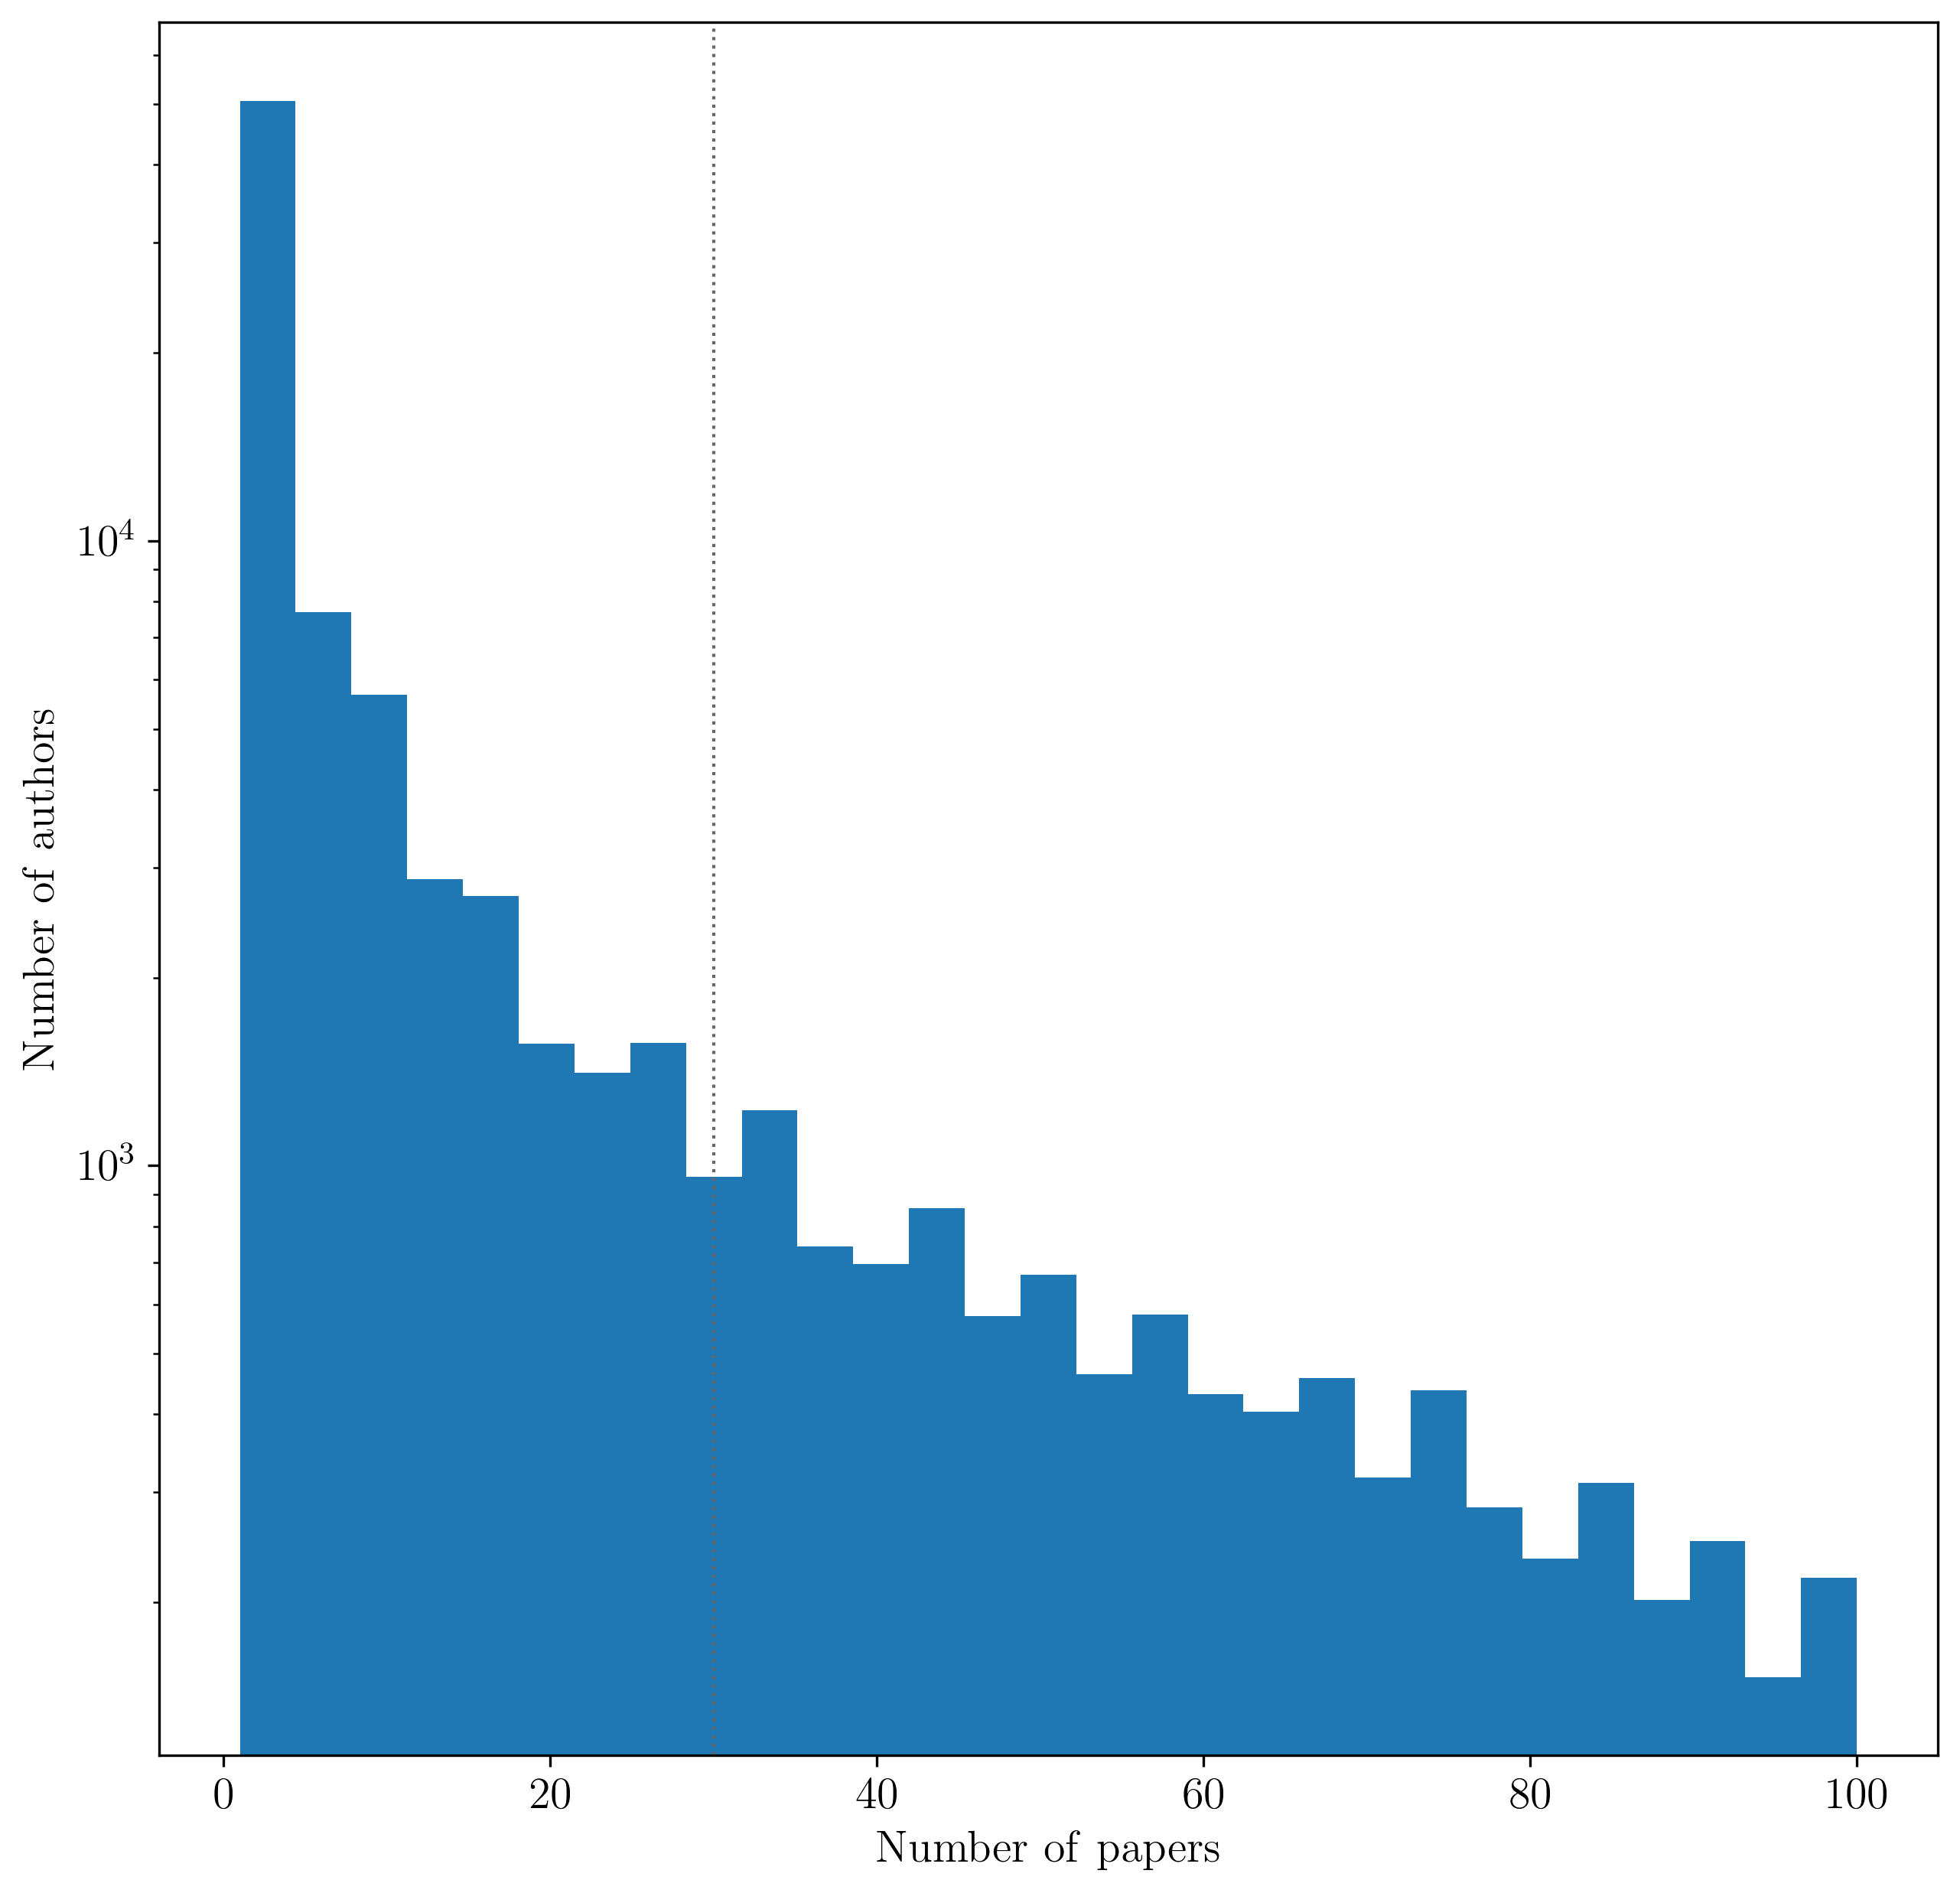

In [9]:
# Histogram the number of papers by 'unique' author so we get an idea of how much name ambiguity matters
too_many = 30

X = np.array([len(v) for k, v in profiles.items()])
fig, ax = plt.subplots()
ax.hist(
    X, 
    bins=np.linspace(1, 100, 30),
    log=True
)
ax.axvline(too_many, c="#666666", ls=":", lw=1, zorder=2)
ax.set_xlabel(r"$\mathrm{Number~of~papers}$")
ax.set_ylabel(r"$\mathrm{Number~of~authors}$")


In [127]:
# Make some attempt to remove multiple people grouped together with the same name
common_names = sorted([k for k, v in profiles.items() if len(v) >= too_many])
common_names.extend([k for k, v in profiles.items() if ("Collaborat" in k or "Team," in k or "," not in k or len(k.split(",")[0]) <= 3)])

In [128]:
def get_cohort(profiles, start_year, end_year, track_years=4, ignore=None):

    cohort_names = {}
    for author_name, profile in tqdm(profiles.items()):
        if ignore is not None and author_name in ignore:
            continue
        sorted_profile = sorted(profile, key=lambda _: _[0])

        # We want the first appearance of this author between the start years
        year, month = get_date(sorted_profile[0][0])
        if year >= start_year and year < end_year:
            # This is a suitable person for our cohort.
            # Find their first first author paper.
            p1, p1_year, p1_month = (None, None, None)
            n_first_author, n_nth_author = (0, 0)
            nth_author_arxiv_ids = []
            for arxiv_id, author_index in sorted_profile:
                if author_index == 0 and p1 is None:
                    p1 = arxiv_id
                    p1_year, p1_month = get_date(arxiv_id)

                    if p1_year >= end_year:
                        break
                        
                if p1 is None:
                    # No first author paper found yet, so keep going.
                    continue            

                # Check it is within range.
                year, month = get_date(arxiv_id)
                diff = (year + (month - 1)/12) - (p1_year + (p1_month - 1)/12)
                if diff >= track_years:
                    break

                # Count the number of 1st and nth author papers since p1
                if author_index == 0:
                    n_first_author += 1
                else:
                    n_nth_author += 1
                    nth_author_arxiv_ids.append(arxiv_id)

            if p1 is not None:
                # How 'involved' were the other authors from P1 to all the n-th authored papers?
                p1_authors = list(map(unique_ify, authors[p1]))
                
                one_or_more_overlap = 0
                for nth_author_arxiv_id in nth_author_arxiv_ids:
                    nth_authors = list(map(unique_ify, authors[nth_author_arxiv_id]))
                    F = set(nth_authors).intersection(p1_authors)
                    if len(F) > 1:
                        one_or_more_overlap += 1
                try:
                    ratio = one_or_more_overlap / n_nth_author
                except ZeroDivisionError:
                    ratio = 0
                
                cohort_names[author_name] = {
                    "p1": p1,
                    "n_first_author": n_first_author,
                    "n_nth_author": n_nth_author,
                    "n_author_overlap_with_p1": one_or_more_overlap,
                    "ratio_overlap_to_total": ratio,
                    "p1_year": p1_year,
                    "p1_month": p1_month,
                }
    return cohort_names


start_year, end_year, track_years = (2012, 2020, 4)

kwds = dict(track_years=4, ignore=common_names)
cohort = get_cohort(profiles, start_year, end_year, **kwds)

100%|██████████| 87608/87608 [01:02<00:00, 1402.25it/s]


In [12]:
len(cohort)

16580

In [130]:
a_start, a_end = (2011, 2012)
b_start, b_end = (2017, 2018)
kwds = dict(track_years=4, ignore=common_names)
cohort_a = get_cohort(profiles, a_start, a_end, **kwds)
cohort_b = get_cohort(profiles, b_start, b_end, **kwds)

100%|██████████| 87608/87608 [00:51<00:00, 1688.87it/s]


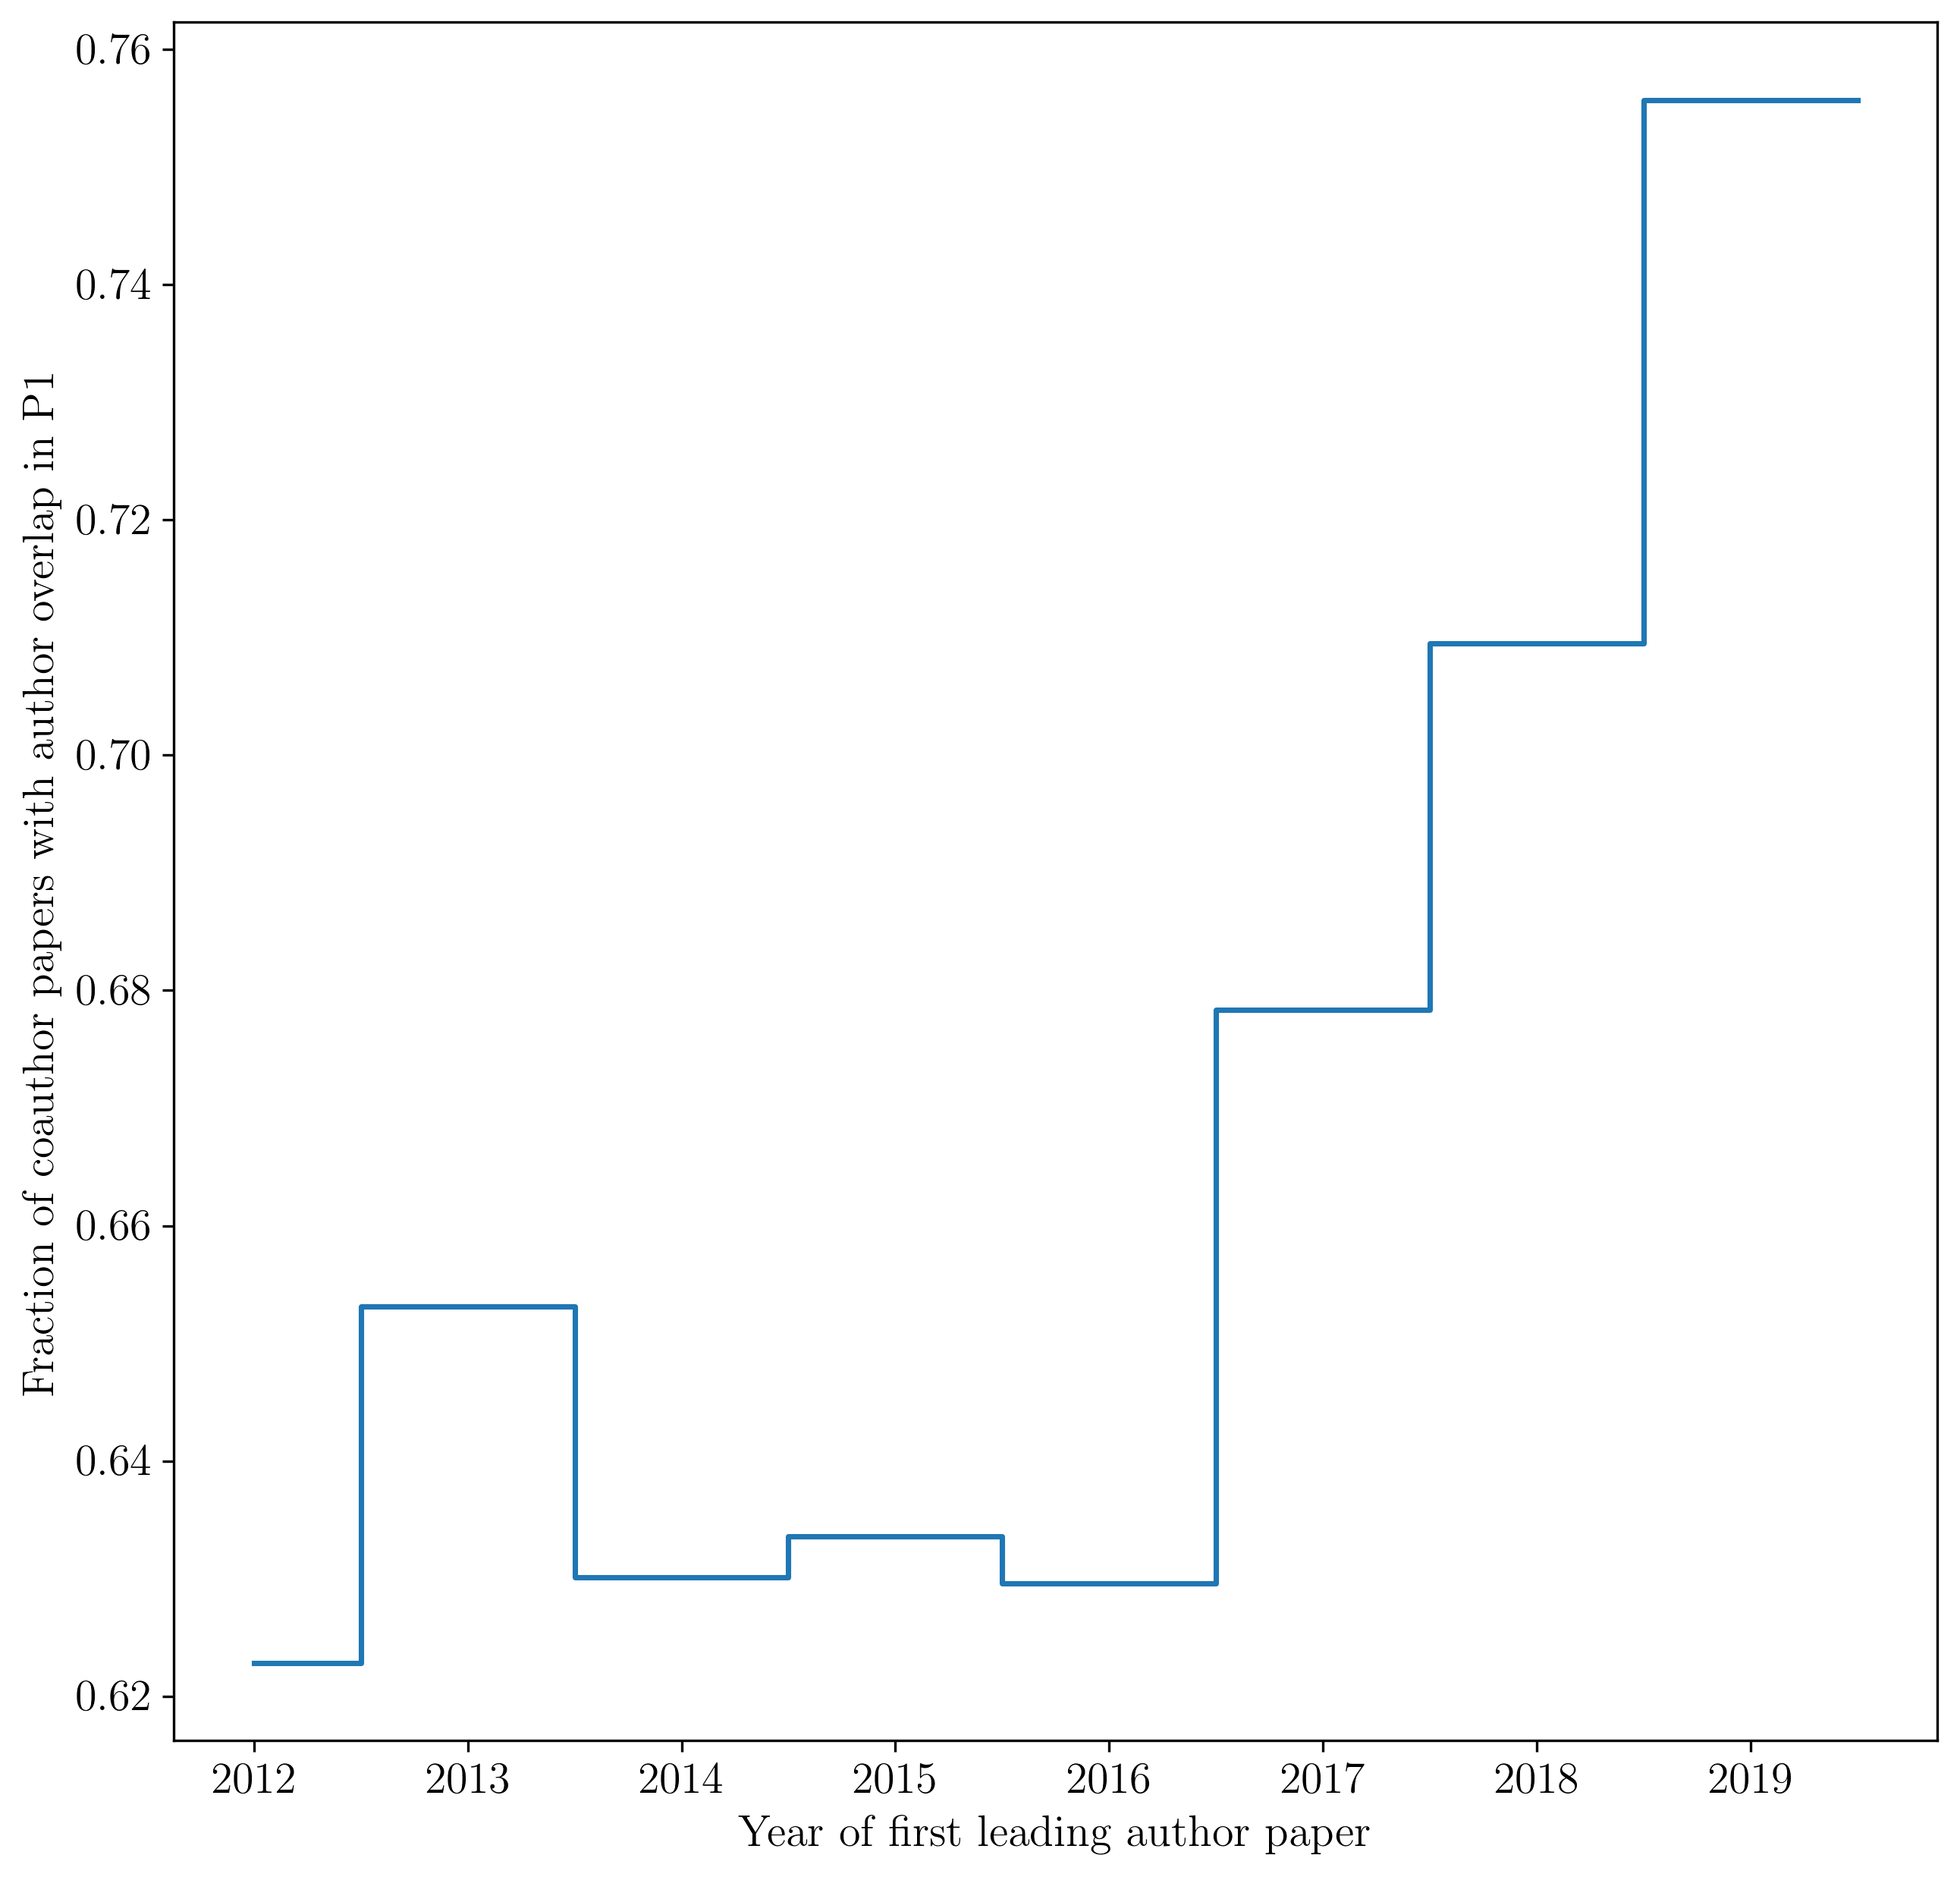

In [129]:
def plot_cohort_ratio(
        cohort,
        start_year,
        end_year,
        ax=None,
        label=None
    ):
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    
    x = np.array([e["p1_year"] + (e["p1_month"] - 1)/12. for e in cohort.values()])

    y_numer = np.array([e["n_author_overlap_with_p1"] for e in cohort.values()])
    y_denom = np.array([e["n_nth_author"] for e in cohort.values()])
    #y = np.array([((e["n_author_overlap_with_p1"] / e["n_nth_author"]) if e["n_nth_author"] > 0 else np.nan) for e in cohort.values()])

    
    # Calculate some summary value at each.
    xs = np.arange(start_year, end_year + 0.5, 1)
    ys = np.nan * np.ones(xs.size)

    idx = np.digitize(x, xs)

    for i, xs_ in enumerate(xs[:-1]):
        ok = (idx == (i + 1))
        ys[i] = np.sum(y_numer[ok]) / np.sum(y_denom[ok])
        #ys[i] = np.nanmean(y[ok])

        # Sanity check because I never trust digitize.
        assert np.all(x[ok] >= xs_) and np.all(xs[i + 1] >= x[ok])

    ax.plot(xs, ys, drawstyle="steps-mid", label=None)

    ax.set_xlabel(r"$\textrm{Year~of~first~leading~author~paper}$")
    ax.set_ylabel(r"$\textrm{Fraction~of~coauthor~papers~with~author~overlap~in~P1}$")
    
    return fig

fig = plot_cohort_ratio(
    cohort,
    start_year=start_year,
    end_year=end_year
)

In [120]:
v

{'p1': '1108.2199',
 'n_first_author': 1,
 'n_nth_author': 0,
 'n_author_overlap_with_p1': 0,
 'ratio_overlap_to_total': 0,
 'p1_year': 2011,
 'p1_month': 8}

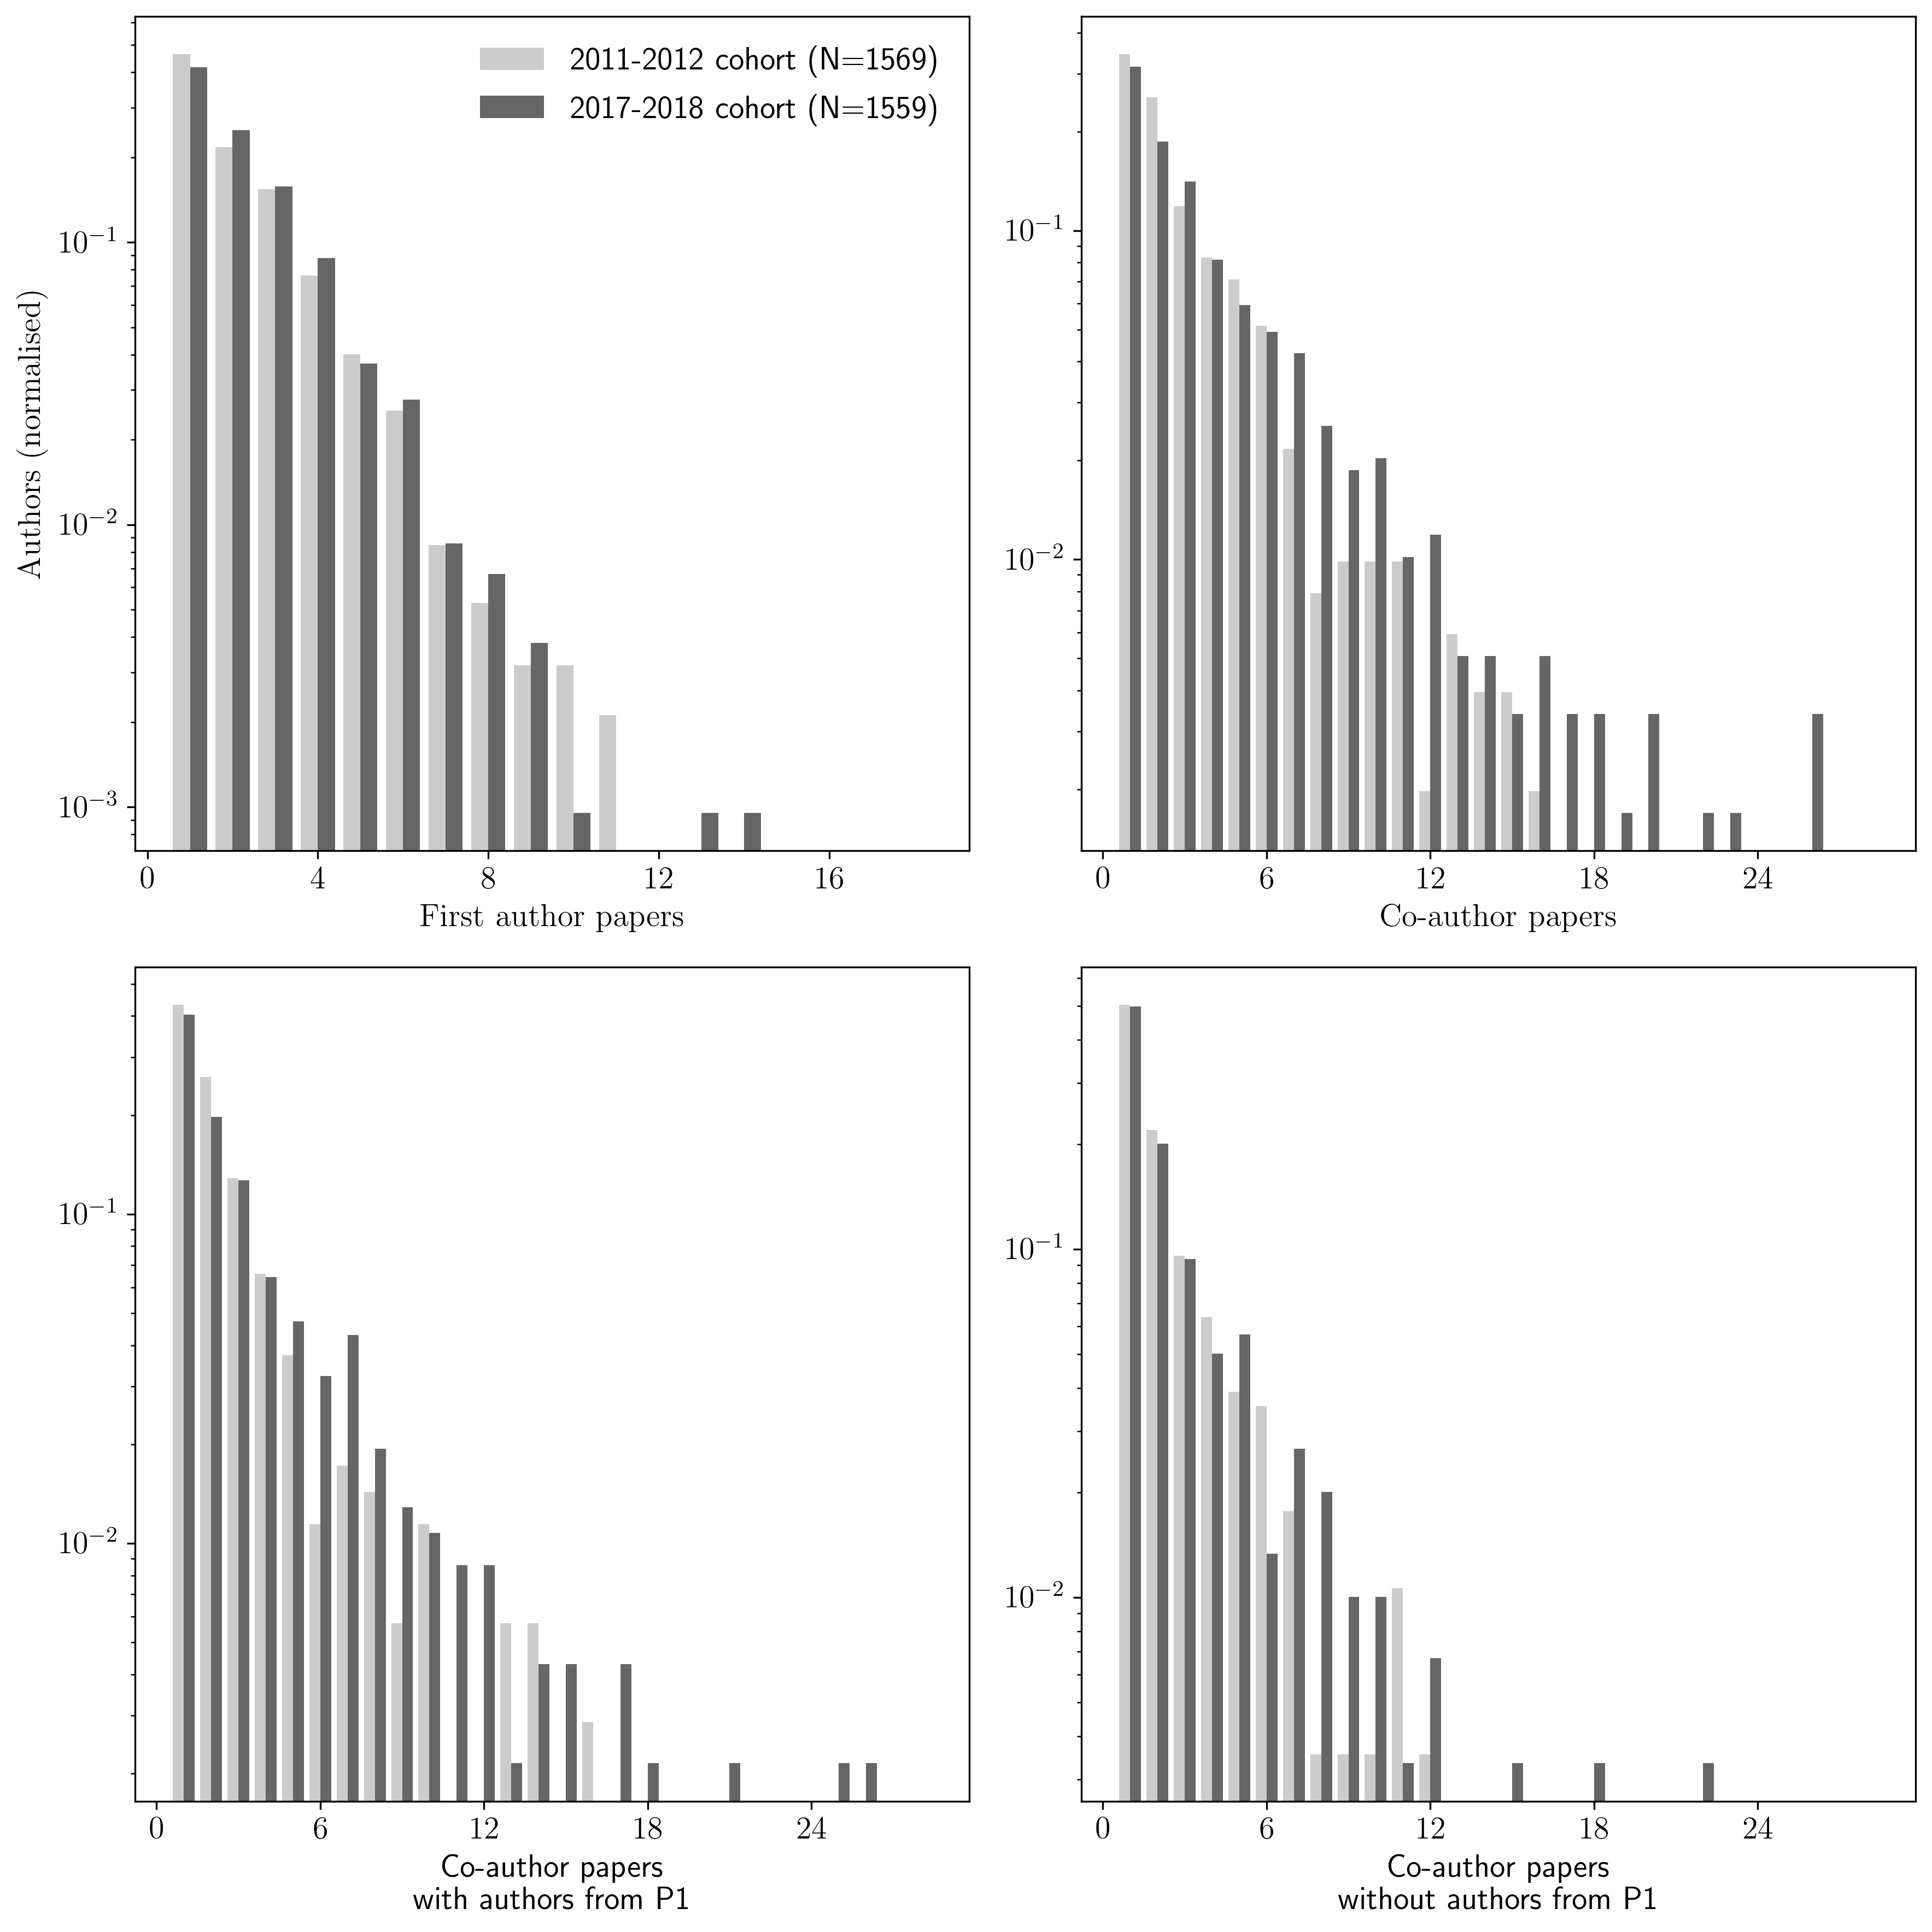

In [131]:
def plot_cohort_comparisons(
        cohort_A, 
        cohort_B, 
        density=True, log=True, label=None,
        bin_max_first=20, bin_max_nth=30,
        **kwargs
    ):
    
    # Figures:
    # - 1st author papers
    # - nth-author papers
    # - nth-author-papers with overlap with P1
    # - nth-author-papers without overlap from P1
    
    kwds = dict(density=density, log=log)
    kwds.update(color=["#CCCCCC", "#666666"])
    
    #fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = np.array(axes).flatten()
    ax_first, ax_nth, ax_nth_with, ax_nth_without = axes
    
    A_first = np.array([each["n_first_author"] for each in cohort_a.values()])
    B_first = np.array([each["n_first_author"] for each in cohort_b.values()])    
        
    ax_first.hist(
        [A_first, B_first],
        bins=np.arange(1, bin_max_first) - 0.5,
        label=label,
        **kwds
    )
    #ax_first.set_xticks(np.arange(1, bin_max_first))
    if label is not None:
        ax_first.legend(loc="upper right", frameon=False)
        
    ax_first.set_xlabel(r"$\textrm{First~author~papers}$")
    if density:
        ax_first.set_ylabel(r"$\textrm{Authors~(normalised)}$")
    else:
        ax_first.set_ylabel(r"$\textrm{Authors}$")
    
    
    # N-th author
    A_nth = np.array([each["n_nth_author"] for each in cohort_a.values()])
    B_nth = np.array([each["n_nth_author"] for each in cohort_b.values()])
    
    ax_nth.hist(
        [A_nth, B_nth],
        bins=np.arange(1, bin_max_nth) - 0.5,
        **kwds
    )
    #ax_nth.set_xticks(np.arange(1, bin_max_nth))
    ax_nth.set_xlabel(r"$\textrm{Co-author~papers}$")
    
    #if density:
    #    ax_nth.set_ylabel(r"$\textrm{Authors~(normalised)}$")
    #else:
    #    ax_nth.set_ylabel(r"$\textrm{Authors}$")
    
    # With overlap.
    A_nth_with_overlap = np.array([each["n_author_overlap_with_p1"] for each in cohort_a.values()])
    B_nth_with_overlap = np.array([each["n_author_overlap_with_p1"] for each in cohort_b.values()])

    ax_nth_with.hist(
        [A_nth_with_overlap, B_nth_with_overlap],
        bins=np.arange(1, bin_max_nth) - 0.5,
        **kwds
    )
    
    #ax_nth_with.set_xticks(np.arange(1, bin_max_nth))
    ax_nth_with.set_xlabel("Co-author papers\nwith authors from P1")

    
    # Without overlap.
    A_nth_without_overlap = np.array([each["n_nth_author"] - each["n_author_overlap_with_p1"] for each in cohort_a.values()])
    B_nth_without_overlap = np.array([each["n_nth_author"] - each["n_author_overlap_with_p1"] for each in cohort_b.values()])

    ax_nth_without.hist(
        [A_nth_without_overlap, B_nth_without_overlap],
        bins=np.arange(1, bin_max_nth) - 0.5,
        **kwds
    )
    
    #ax_nth_without.set_xticks(np.arange(1, bin_max_nth))
    ax_nth_without.set_xlabel("Co-author papers\nwithout authors from P1")
    
    for ax in axes:
        ax.xaxis.set_major_locator(MaxNLocator(6))
    fig.tight_layout()
    return fig
    
    
label = [f"{a_start}-{a_end} cohort (N={len(cohort_a)})", f"{b_start}-{b_end} cohort (N={len(cohort_b)})"]

fig = plot_cohort_comparisons(cohort_a, cohort_b, label=label, log=True)


In [49]:
# Build profiles for all categories
all_profiles = {}
ppcs = sorted(set(records["primary_parent_category"]))
for ppc in tqdm(ppcs):
    mask_ppc = (records["primary_parent_category"] == ppc)
    all_profiles[ppc] = get_author_profiles(
        records[mask_ppc],
        authors
    )


100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


In [50]:
# Get common names per field
too_many_default = 30
too_many_limits = {}

all_common_names = {}
for ppc in tqdm(ppcs):
    # Make some attempt to remove multiple people grouped together with the same name

    too_many = too_many_limits.get(ppc, too_many_default)
    common_names = sorted([k for k, v in all_profiles[ppc].items() if len(v) >= too_many])
    common_names.extend([k for k, v in all_profiles[ppc].items() if ("Collaborat" in k or "Team," in k or "," not in k or len(k.split(",")[0]) <= 3)])

    all_common_names[ppc] = common_names

100%|██████████| 20/20 [00:00<00:00, 41.05it/s]


In [52]:
# Build cohorts in all.
start_year, end_year, track_years = (2010, 2020, 4)

all_cohorts = {}
for ppc in ppcs:
    print(ppc)
    kwds = dict(ignore=all_common_names[ppc])
    all_cohorts[ppc] = get_cohort(all_profiles[ppc], start_year, end_year, track_years=track_years, **kwds)

  0%|          | 144/87608 [00:00<01:01, 1424.39it/s]

astro-ph


  1%|          | 690/108372 [00:00<00:15, 6892.20it/s]

cond-mat


  0%|          | 507/172711 [00:00<00:33, 5065.23it/s]

cs


  7%|▋         | 1834/28103 [00:00<00:01, 18336.13it/s]

econ
eess


 17%|█▋        | 2841/16680 [00:00<00:00, 28405.76it/s]

gr-qc


  2%|▏         | 680/27394 [00:00<00:03, 6796.46it/s]

hep-ex


 10%|█         | 2279/22714 [00:00<00:00, 22782.47it/s]

hep-lat
hep-ph


 23%|██▎       | 3537/15203 [00:00<00:00, 35350.90it/s]

hep-th


  1%|          | 727/98569 [00:00<00:13, 7257.88it/s]

math


 46%|████▌     | 6007/13084 [00:00<00:00, 60064.04it/s]

math-ph


  0%|          | 0/19375 [00:00<?, ?it/s]

nlin
nucl-ex


  0%|          | 0/140571 [00:00<?, ?it/s]

nucl-th
physics


 11%|█         | 3623/34084 [00:00<00:00, 36221.66it/s]

q-bio


  0%|          | 0/32966 [00:00<?, ?it/s]

q-fin
quant-ph


  9%|▉         | 2771/31376 [00:00<00:01, 27706.13it/s]

stat


100%|██████████| 31376/31376 [00:01<00:00, 26745.29it/s]


<ipython-input-81-86455744542b>:29: RuntimeWarning: invalid value encountered in long_scalars
  ys[i] = np.sum(y_numer[ok]) / np.sum(y_denom[ok])
<ipython-input-81-86455744542b>:29: RuntimeWarning: invalid value encountered in long_scalars
  ys[i] = np.sum(y_numer[ok]) / np.sum(y_denom[ok])
<ipython-input-81-86455744542b>:29: RuntimeWarning: invalid value encountered in long_scalars
  ys[i] = np.sum(y_numer[ok]) / np.sum(y_denom[ok])
<ipython-input-81-86455744542b>:29: RuntimeWarning: invalid value encountered in long_scalars
  ys[i] = np.sum(y_numer[ok]) / np.sum(y_denom[ok])
<ipython-input-81-86455744542b>:29: RuntimeWarning: invalid value encountered in long_scalars
  ys[i] = np.sum(y_numer[ok]) / np.sum(y_denom[ok])
<ipython-input-81-86455744542b>:29: RuntimeWarning: invalid value encountered in long_scalars
  ys[i] = np.sum(y_numer[ok]) / np.sum(y_denom[ok])
<ipython-input-81-86455744542b>:29: RuntimeWarning: invalid value encountered in long_scalars
  ys[i] = np.sum(y_numer[ok]) 

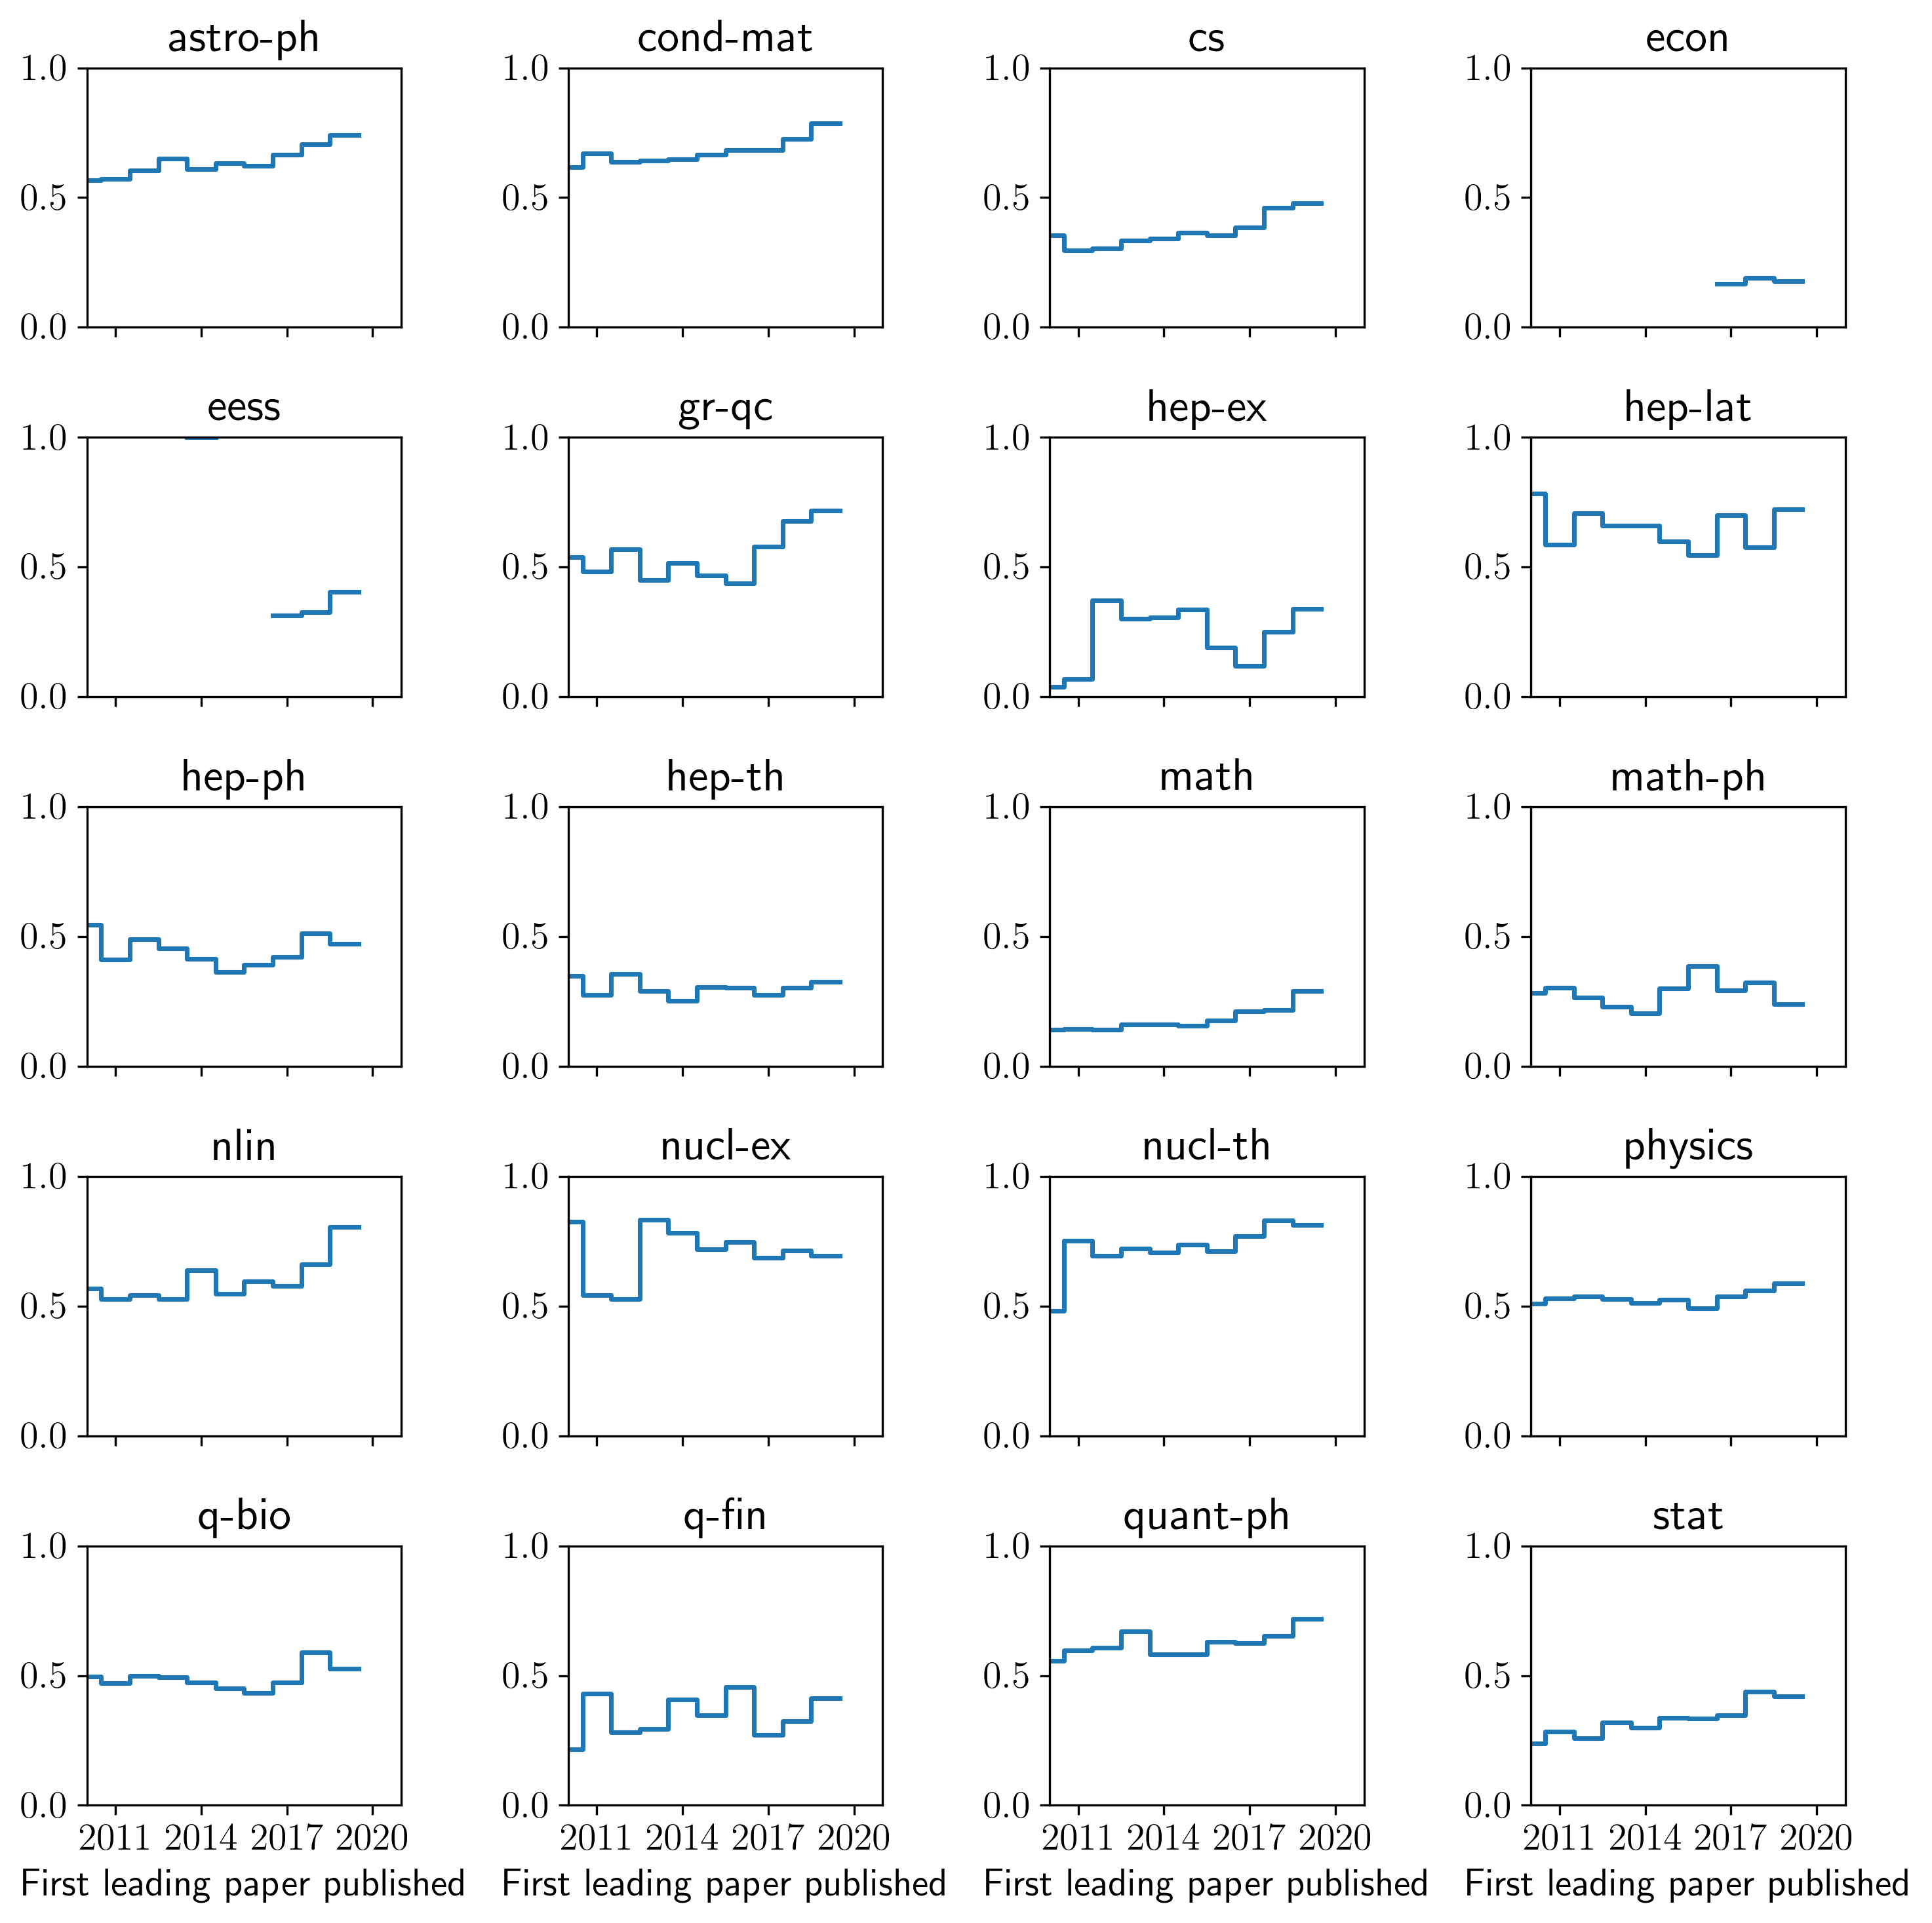

In [83]:
# Plot ratios in all fields.
fig, axes = plt.subplots(5, 4)
axes = np.array(axes).flatten()

for i, (ax, ppc) in enumerate(zip(axes, ppcs)):
    
    plot_cohort_ratio(
        all_cohorts[ppc],
        start_year=start_year,
        end_year=end_year + 1,
        ax=ax
    )
    ax.set_title(ppc)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    
for ax in axes:
    if not ax.is_first_col():
        ax.set_ylabel("")
    if not ax.is_last_row():
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("First leading paper published")
    ax.set_xlim(start_year, end_year + 1)
    ax.set_ylabel(None)
    ax.set_ylim(0, 1)

fig.tight_layout()


In [63]:
# Construct A/B cohorts.
a_start, a_end = (2010, 2014)
b_start, b_end = (2015, 2019)
cohort_abs = {}
for ppc in ppcs:
    print(ppc)
    kwds = dict(ignore=all_common_names[ppc])

    cohort_abs[ppc] = [
        get_cohort(all_profiles[ppc], a_start, a_end, **kwds),
        get_cohort(all_profiles[ppc], b_start, b_end, **kwds)
    ]
    

  0%|          | 175/87608 [00:00<00:50, 1745.21it/s]

astro-ph


  1%|          | 542/108372 [00:00<00:19, 5418.69it/s]

cond-mat


  0%|          | 642/172711 [00:00<00:26, 6415.05it/s]

cs


  7%|▋         | 2091/28103 [00:00<00:01, 20904.34it/s]

econ
eess


 17%|█▋        | 2883/16680 [00:00<00:00, 28826.52it/s]

gr-qc


  2%|▏         | 550/27394 [00:00<00:04, 5499.72it/s]

hep-ex


  8%|▊         | 1831/22714 [00:00<00:01, 18302.16it/s]

hep-lat
hep-ph


 46%|████▋     | 7056/15203 [00:00<00:00, 35929.32it/s]

hep-th


  1%|          | 649/98569 [00:00<00:15, 6480.92it/s]

math


100%|██████████| 13084/13084 [00:00<00:00, 66119.12it/s]


math-ph


  0%|          | 0/9917 [00:00<?, ?it/s]

nlin


 10%|▉         | 1899/19375 [00:00<00:00, 18985.27it/s]

nucl-ex


  0%|          | 0/8144 [00:00<?, ?it/s]

nucl-th


  0%|          | 541/140571 [00:00<00:25, 5397.15it/s]

physics


 21%|██        | 7007/34084 [00:00<00:00, 35649.23it/s]

q-bio


  0%|          | 0/7818 [00:00<?, ?it/s]

q-fin


 12%|█▏        | 4010/32966 [00:00<00:01, 19046.63it/s]

quant-ph


  9%|▉         | 2750/31376 [00:00<00:01, 27479.13it/s]

stat


100%|██████████| 31376/31376 [00:01<00:00, 28929.31it/s]


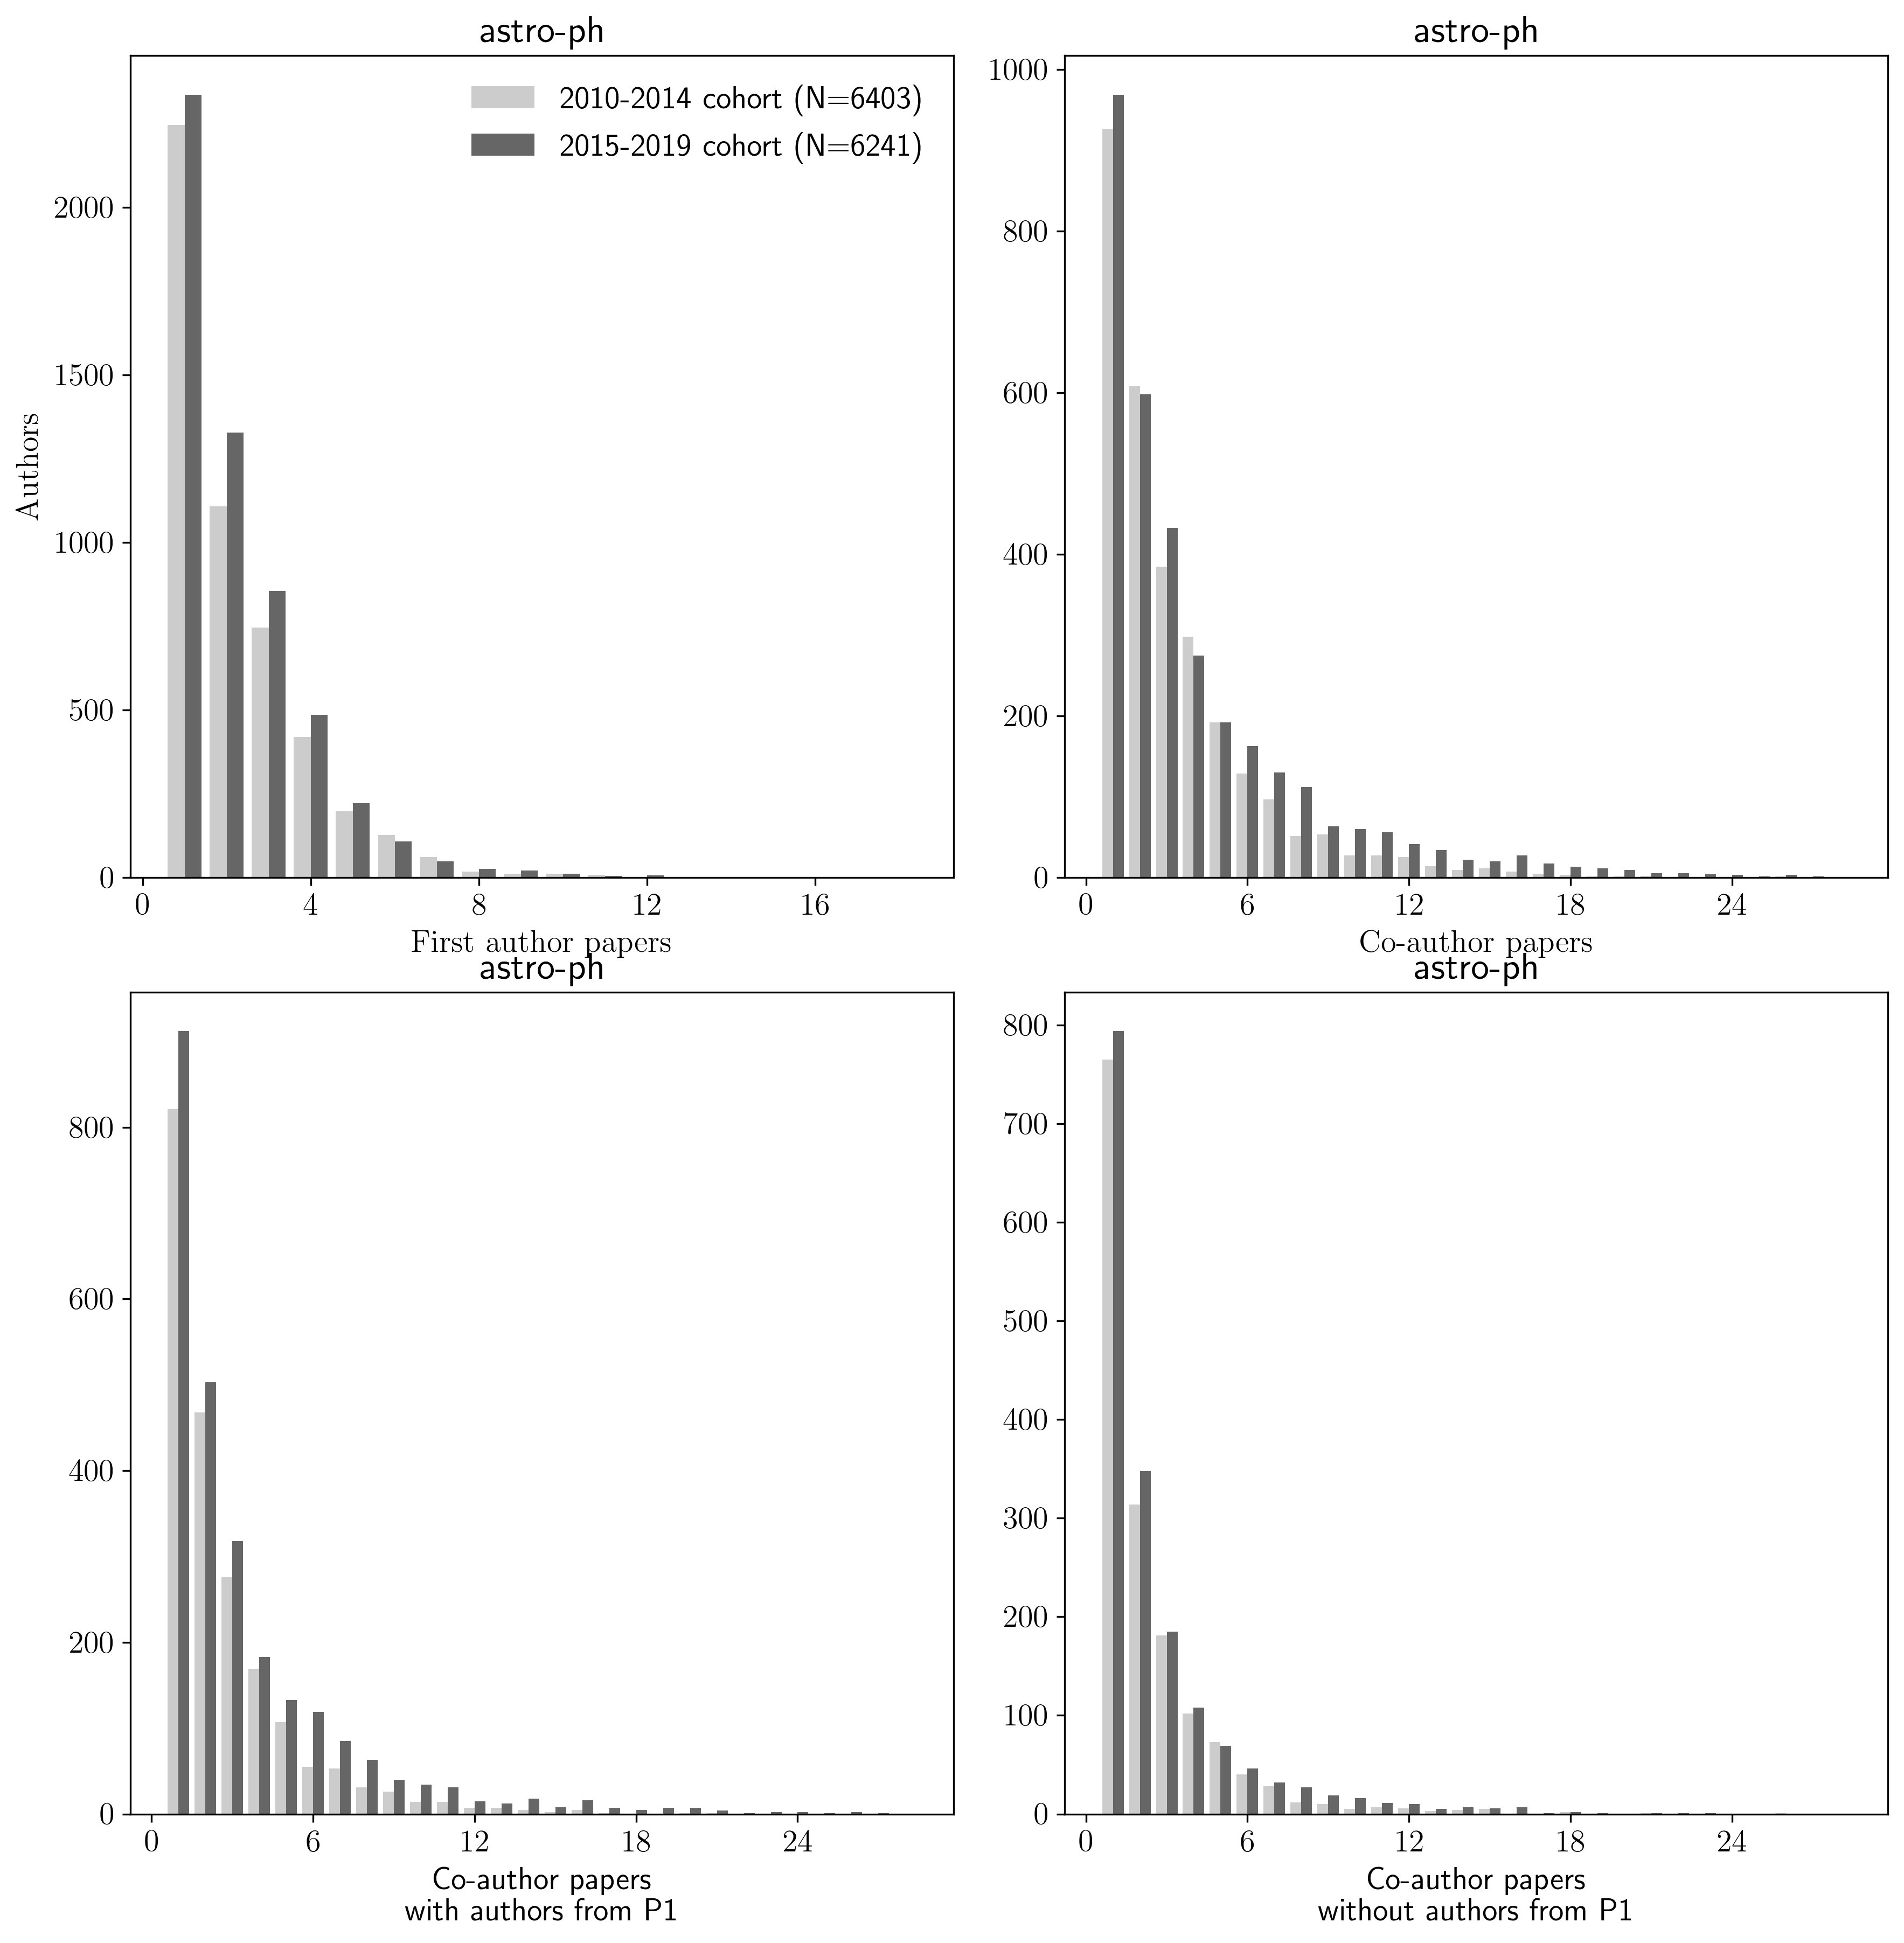

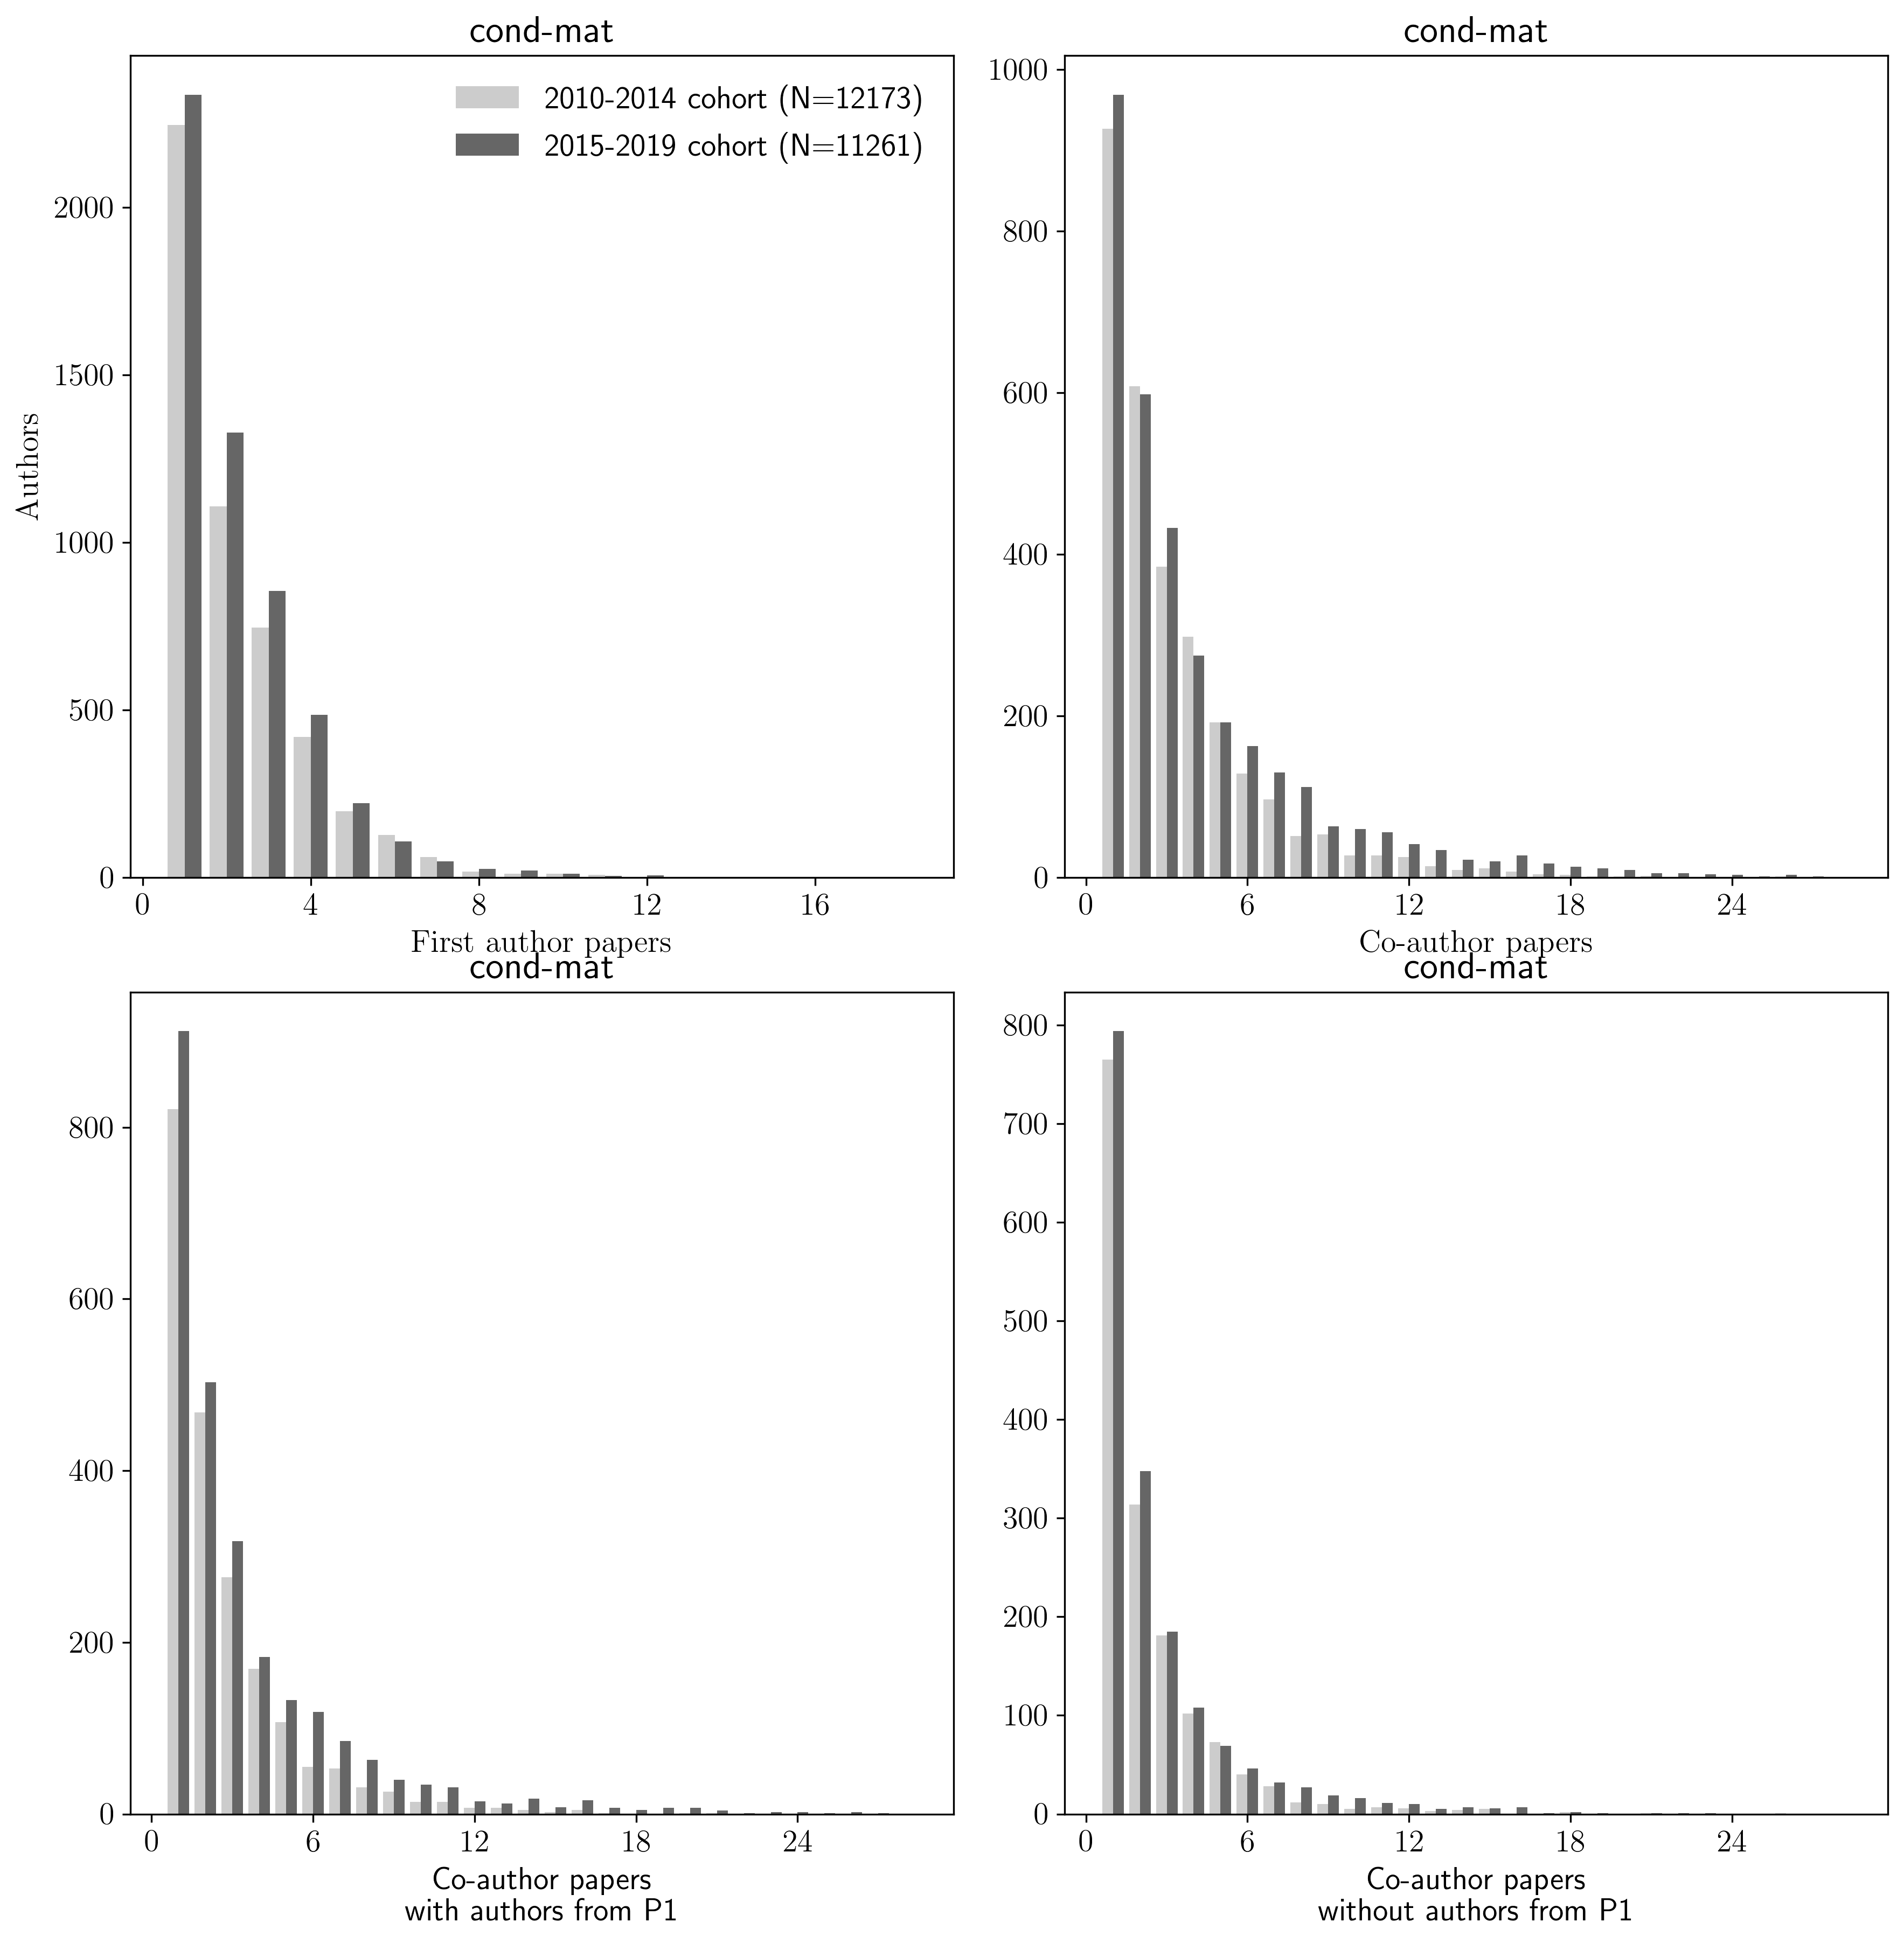

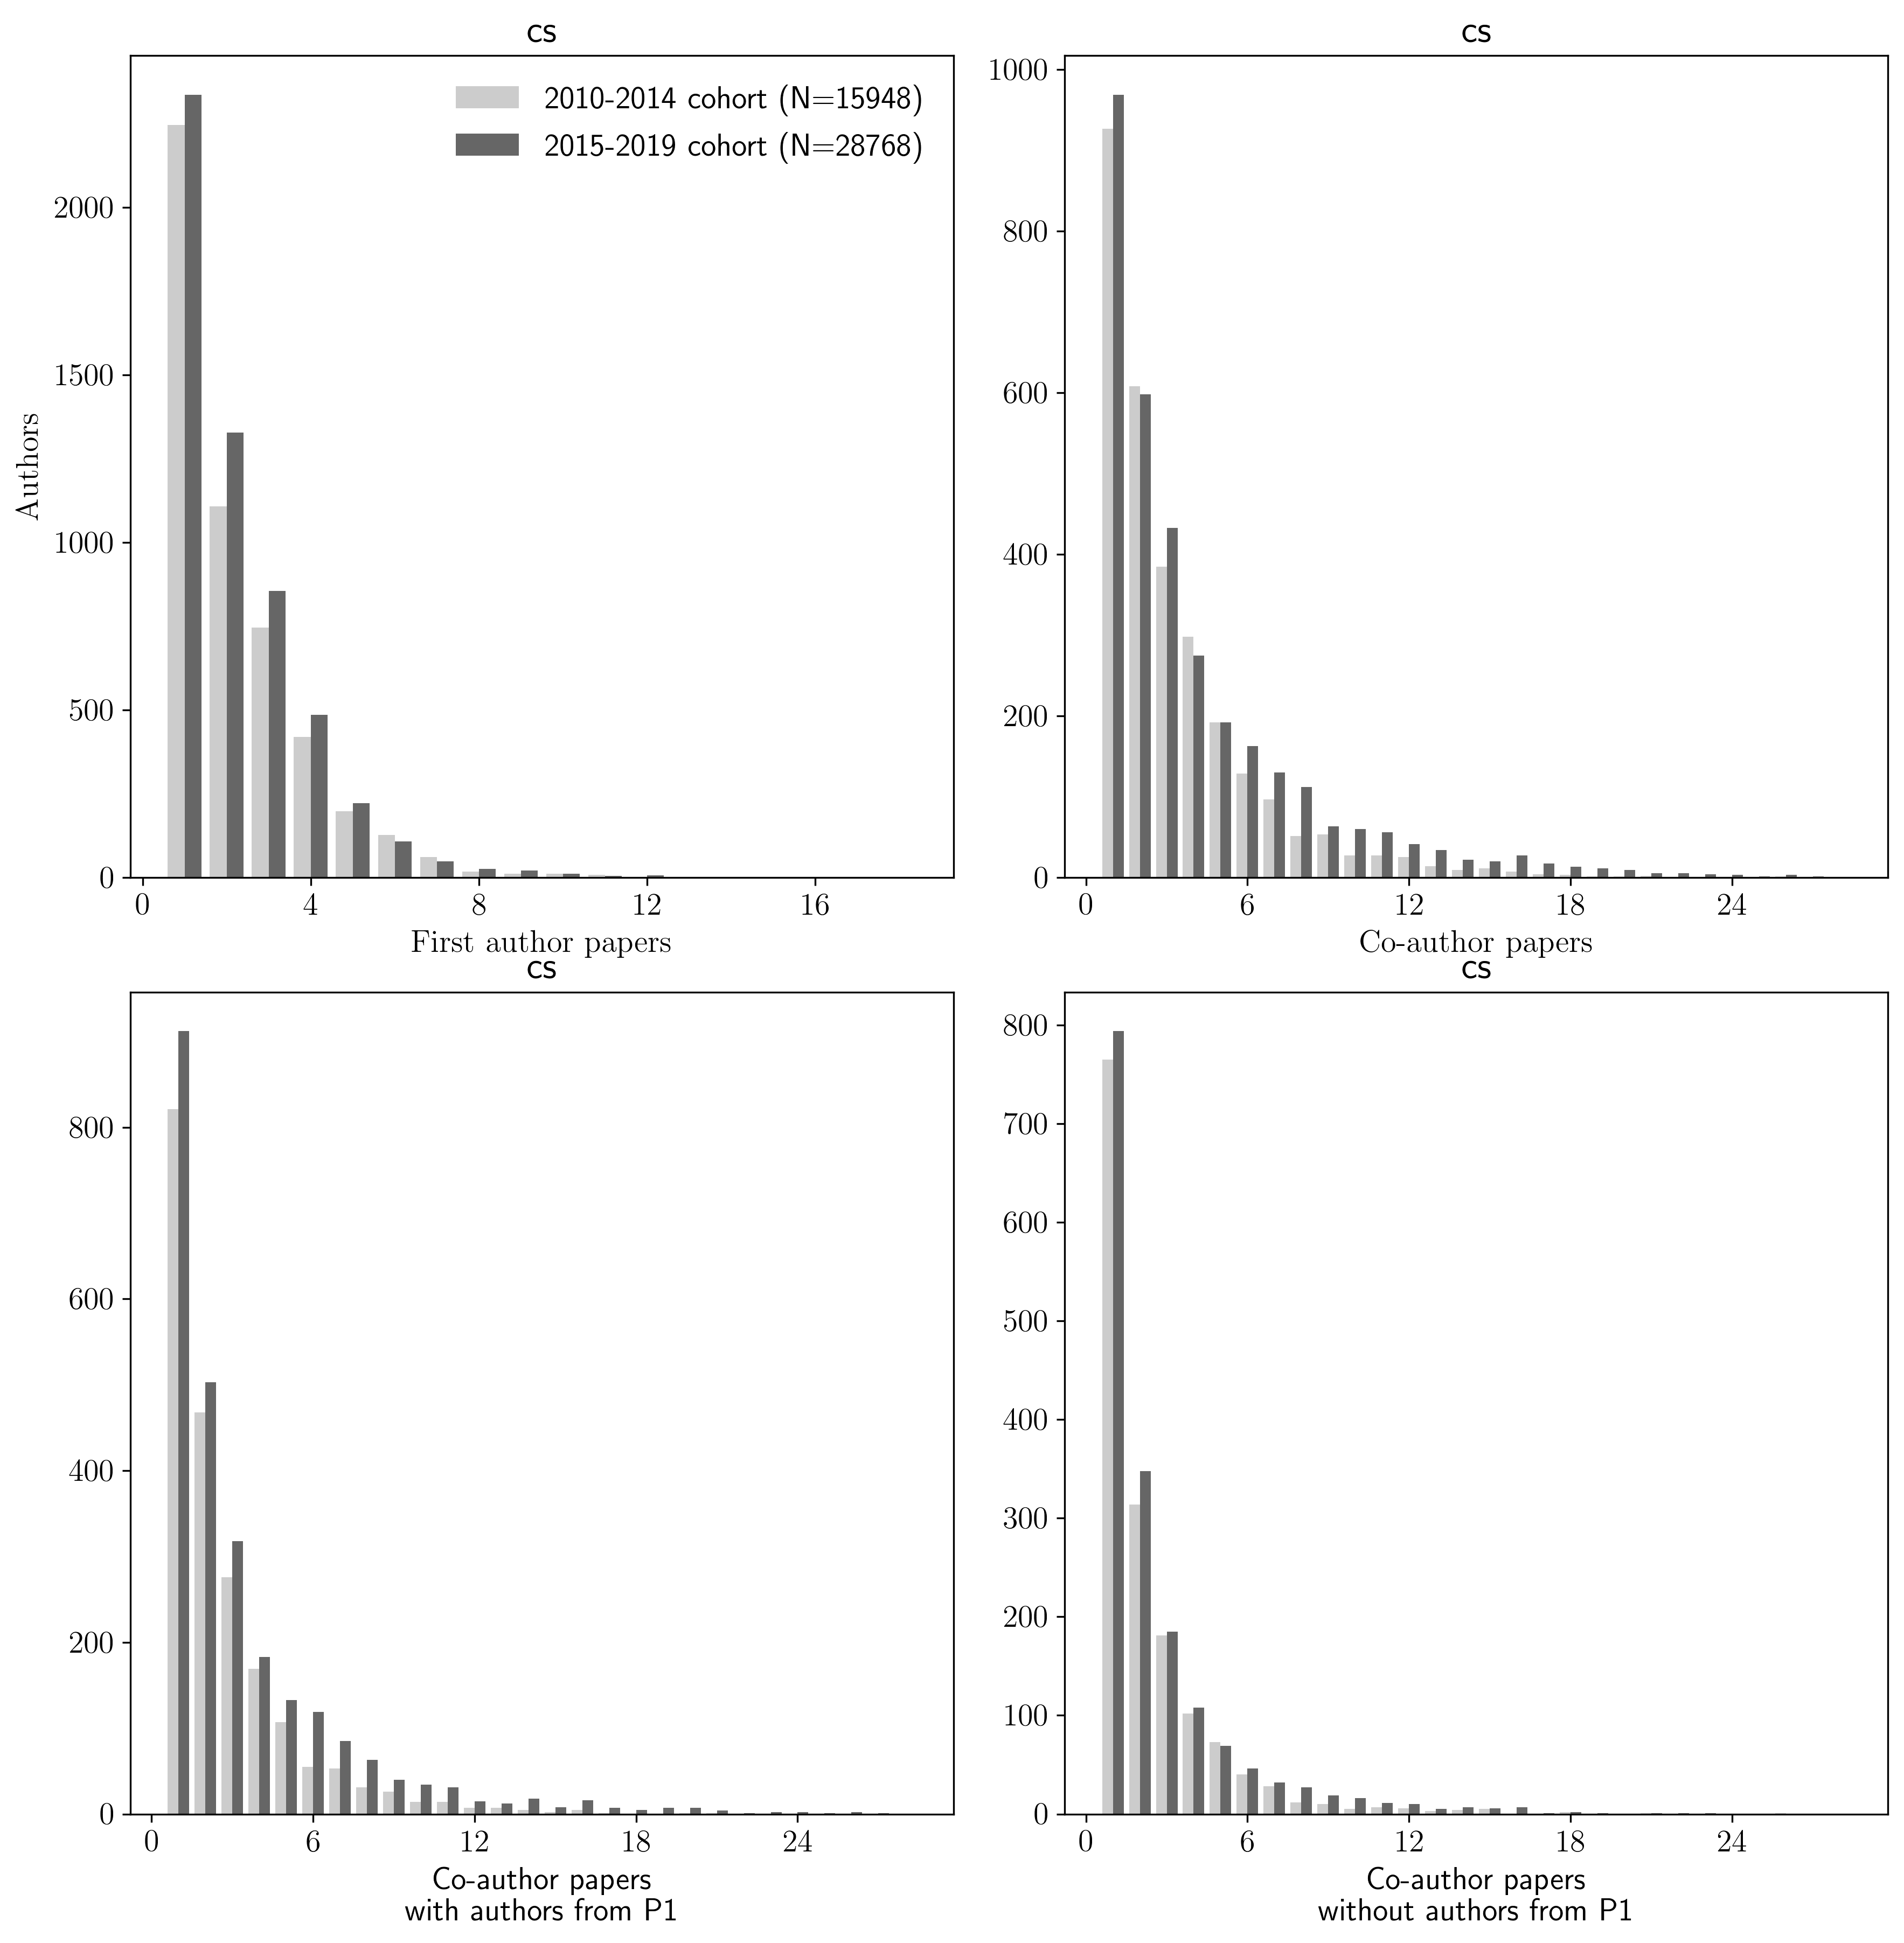

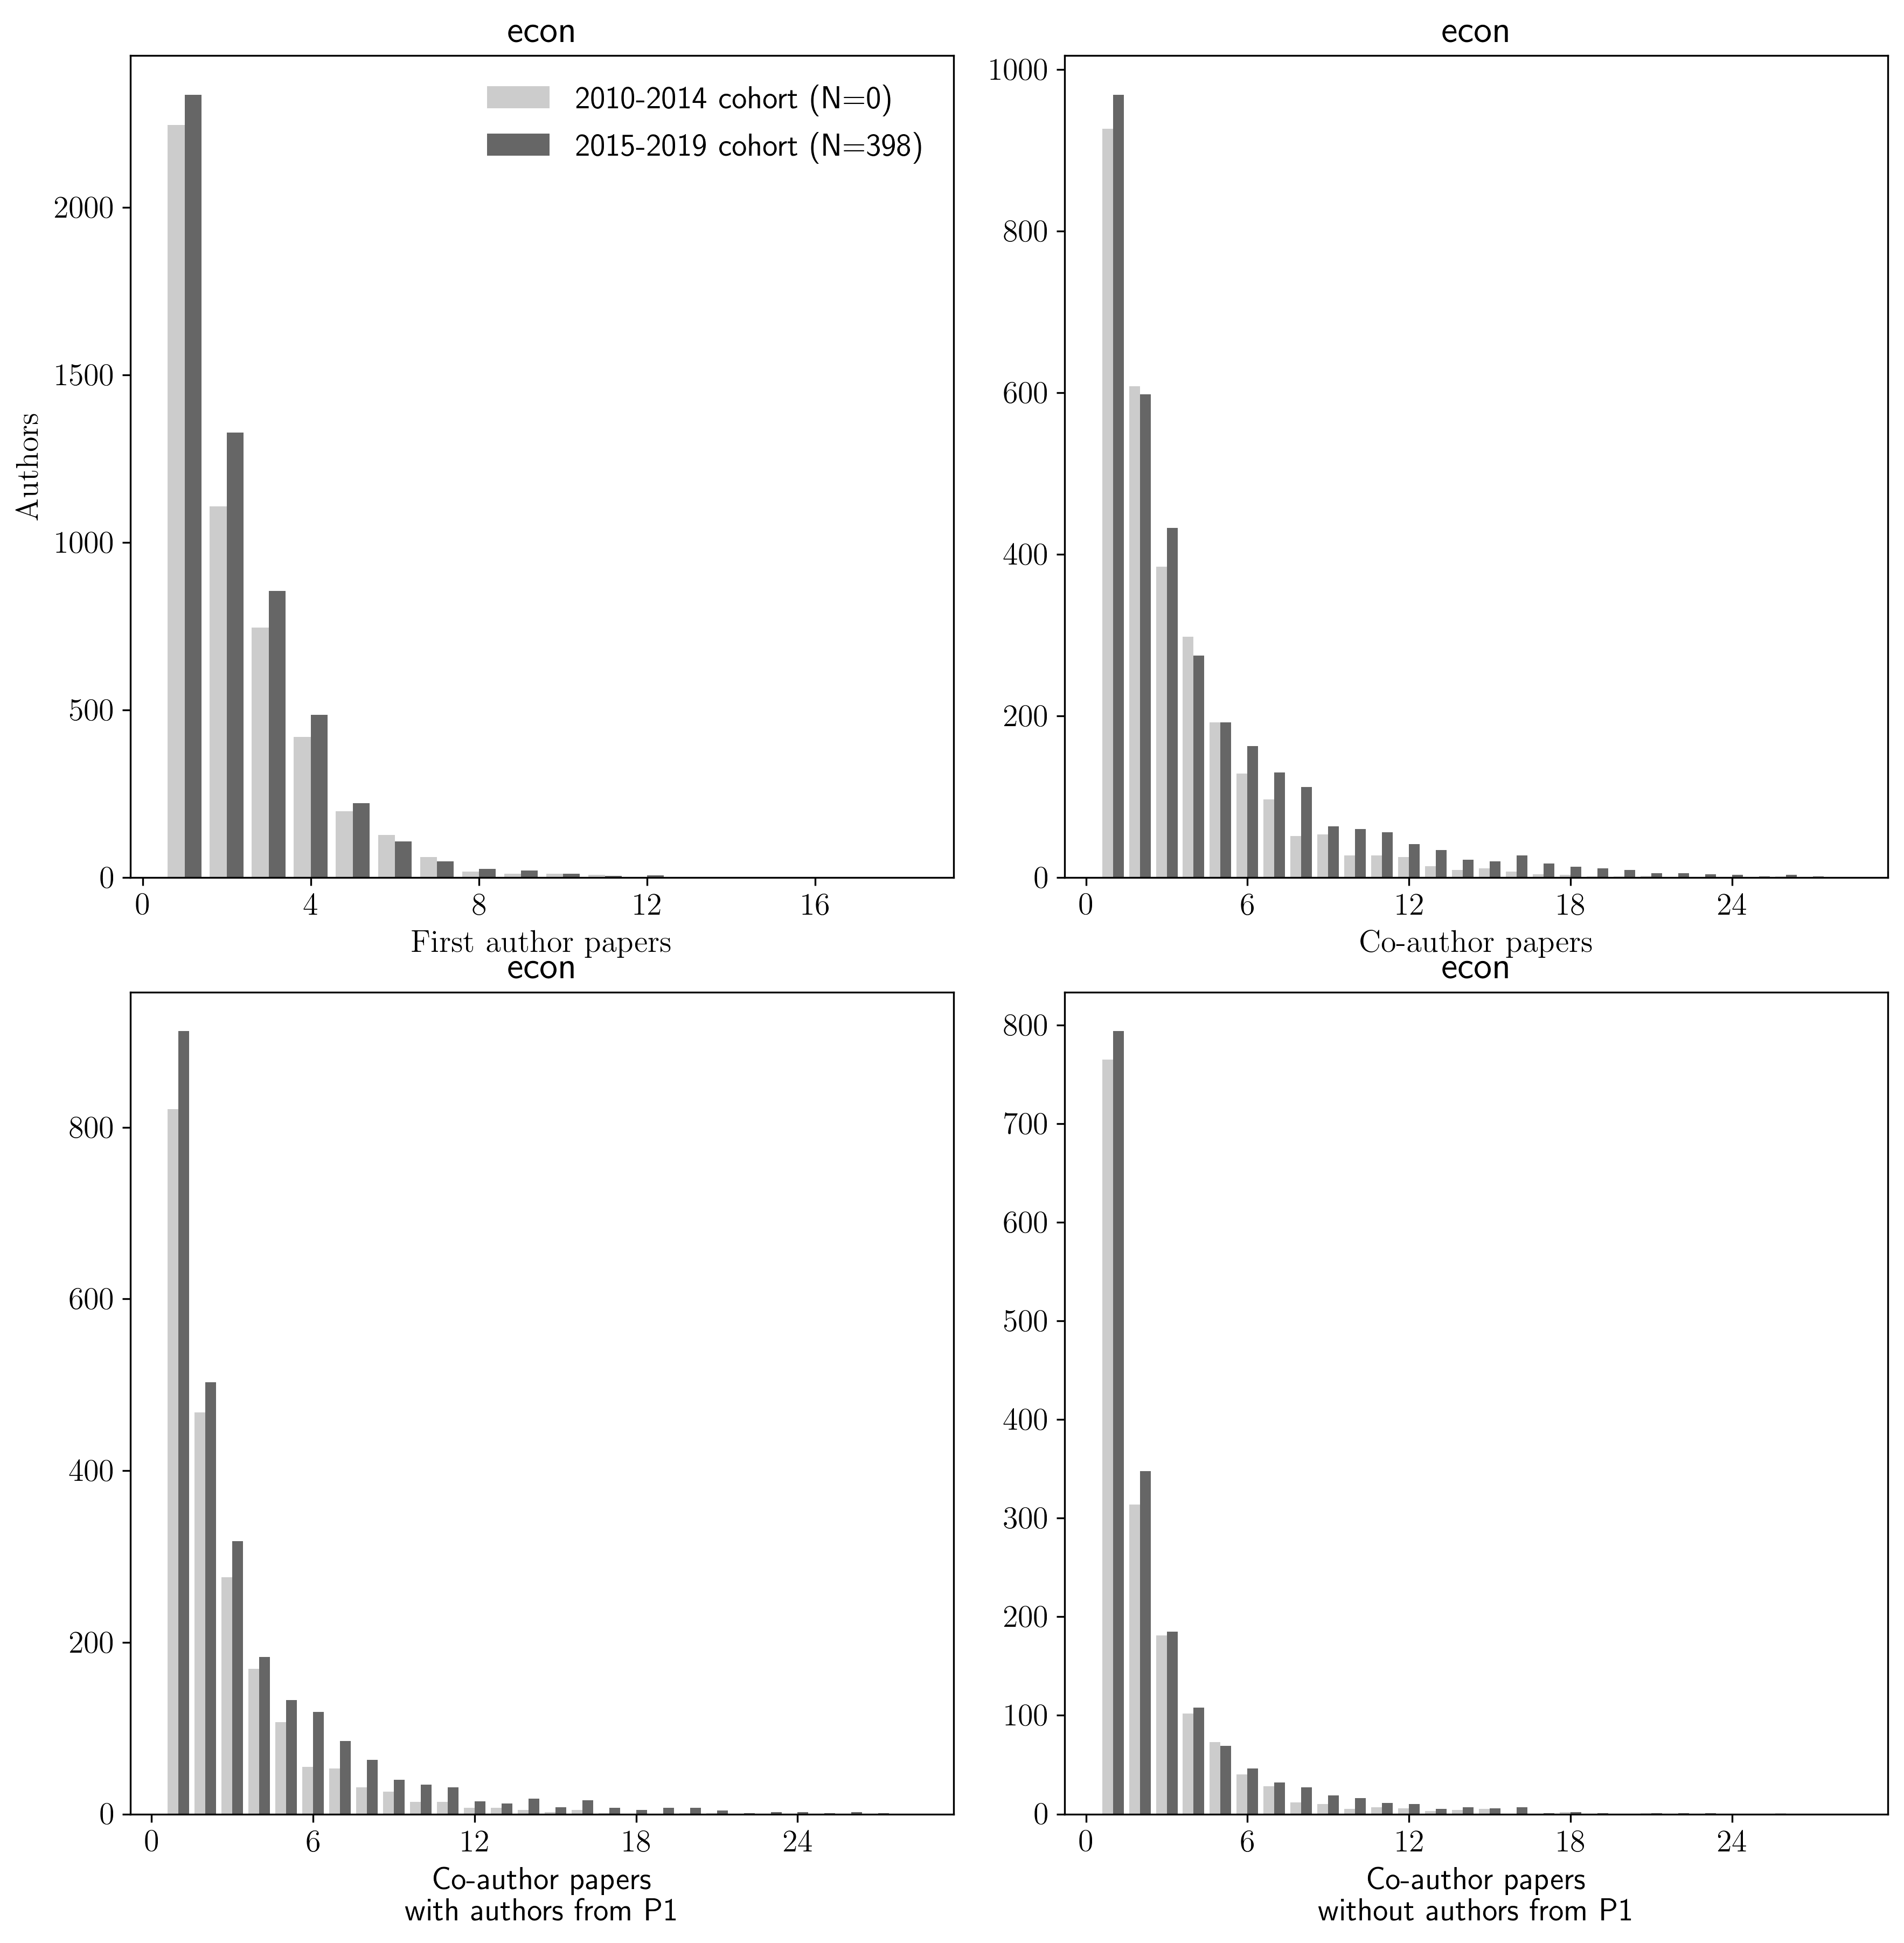

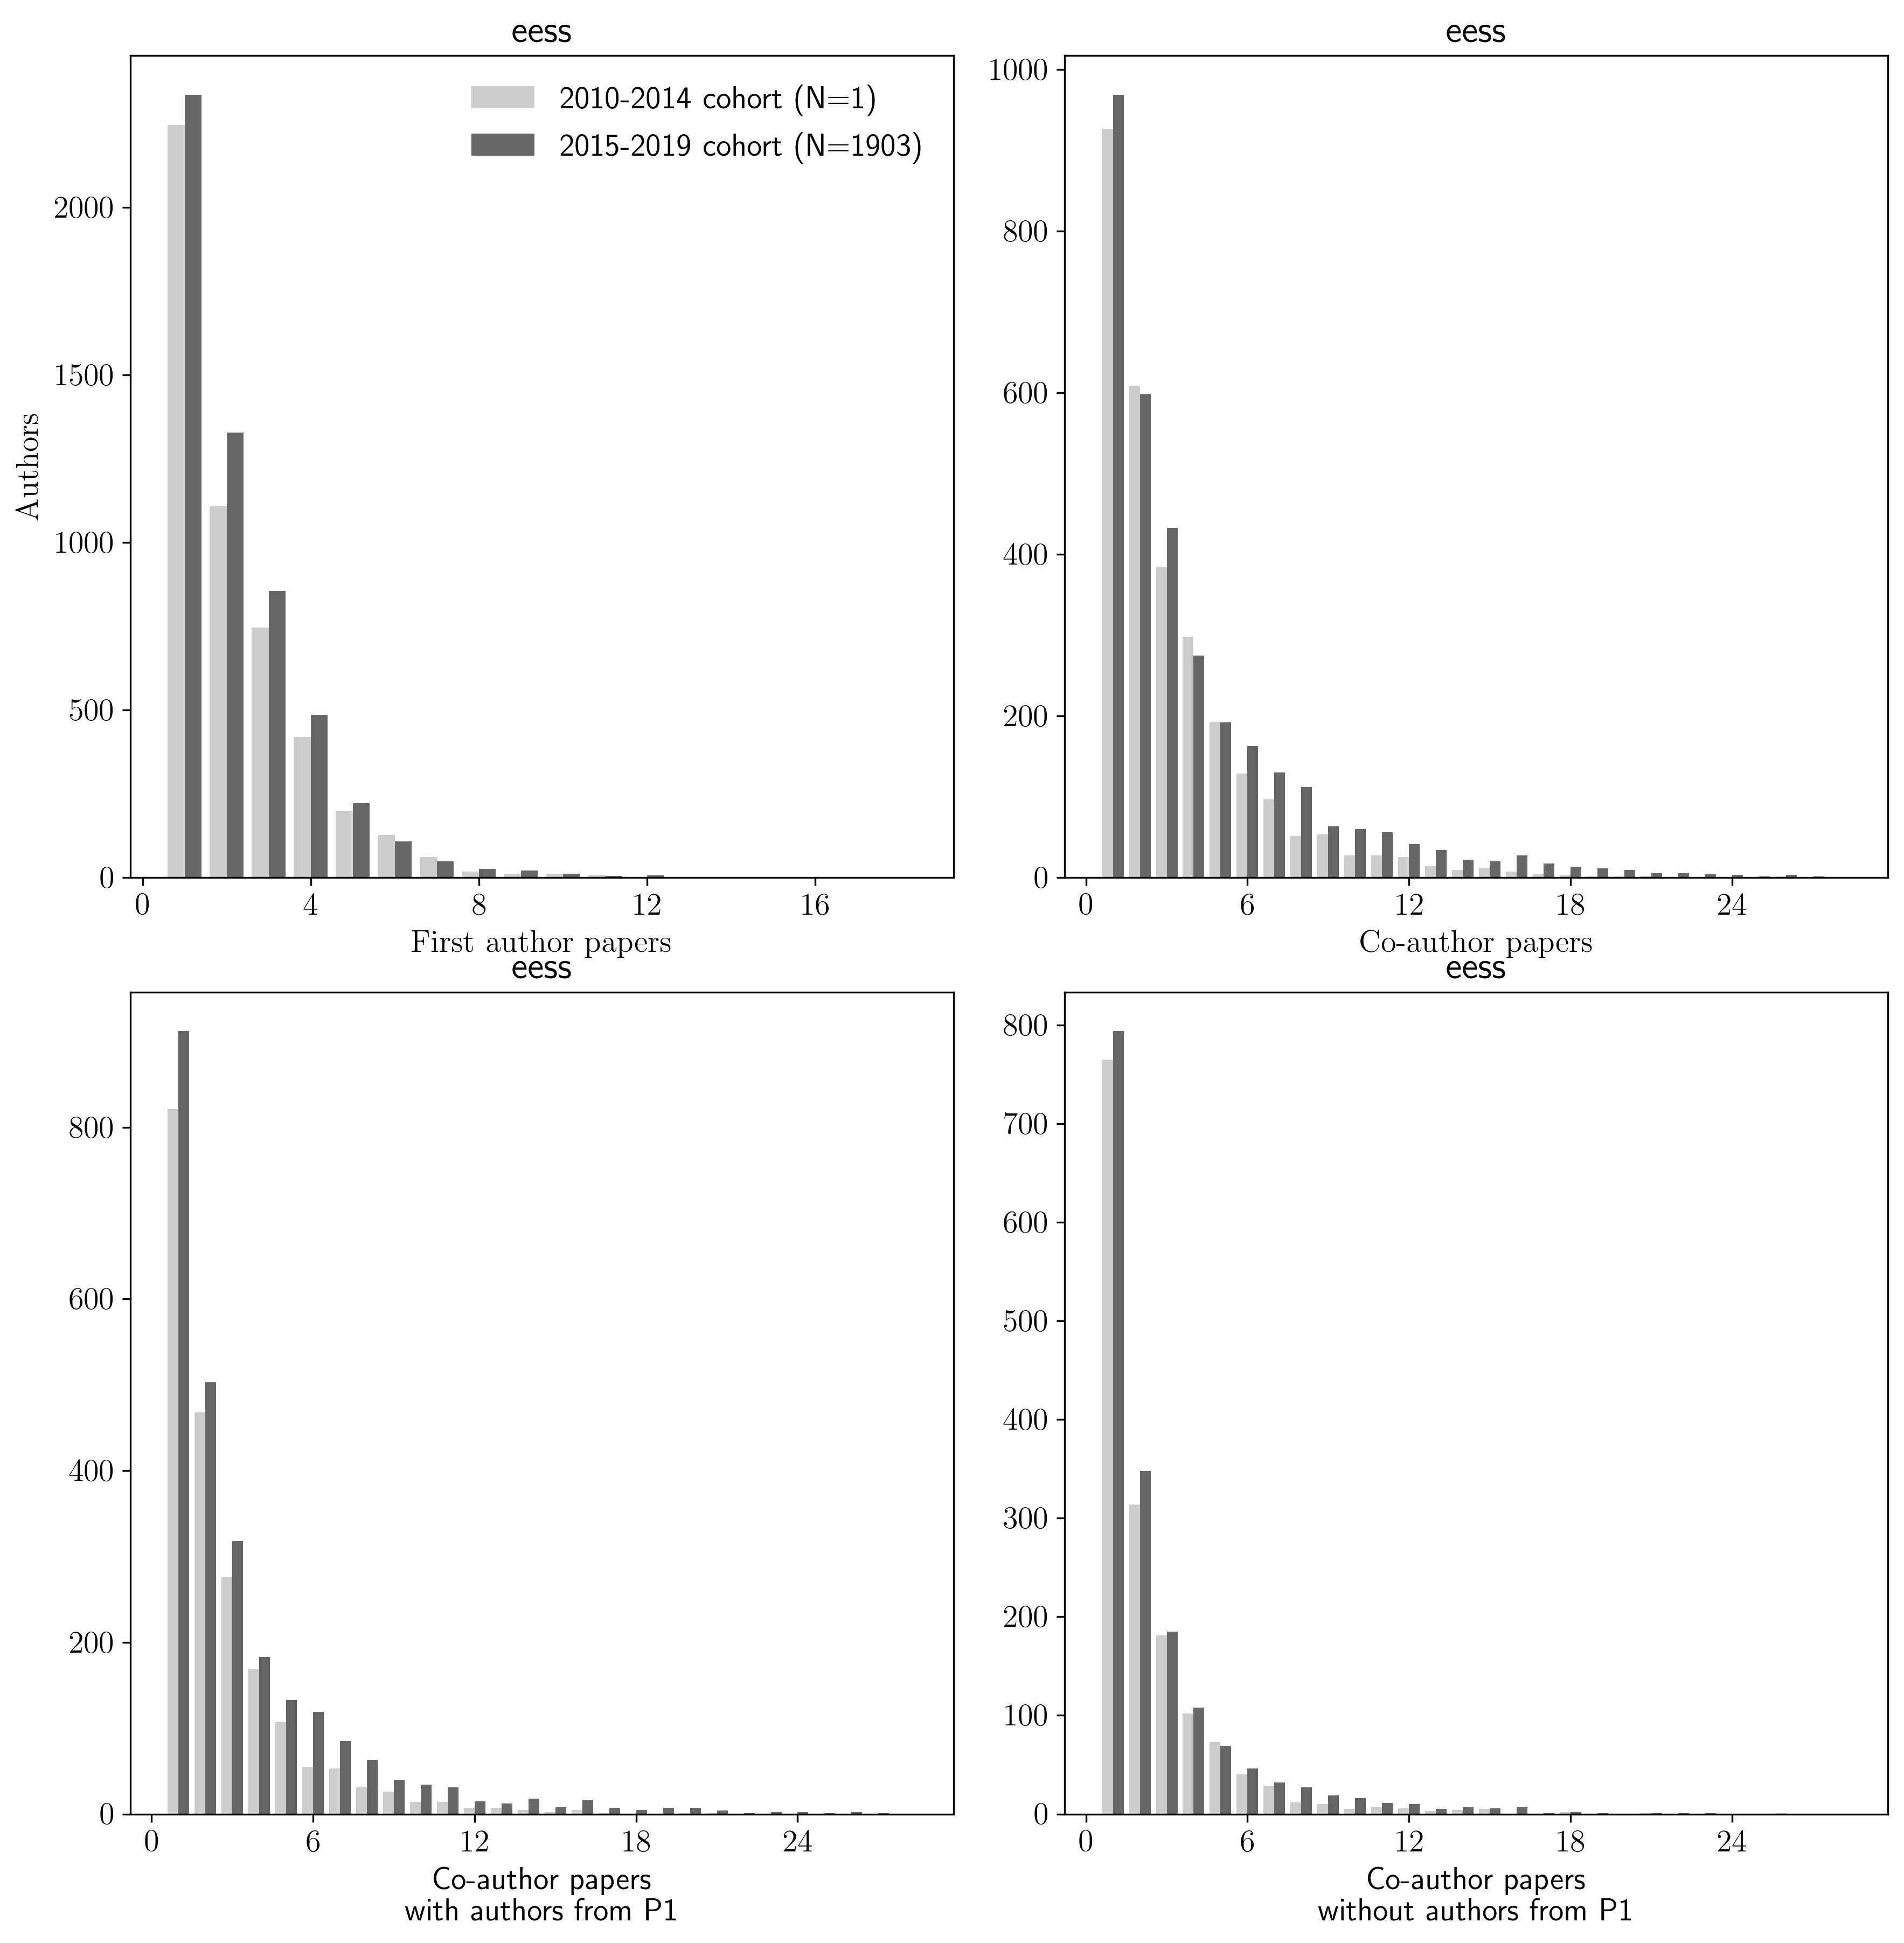

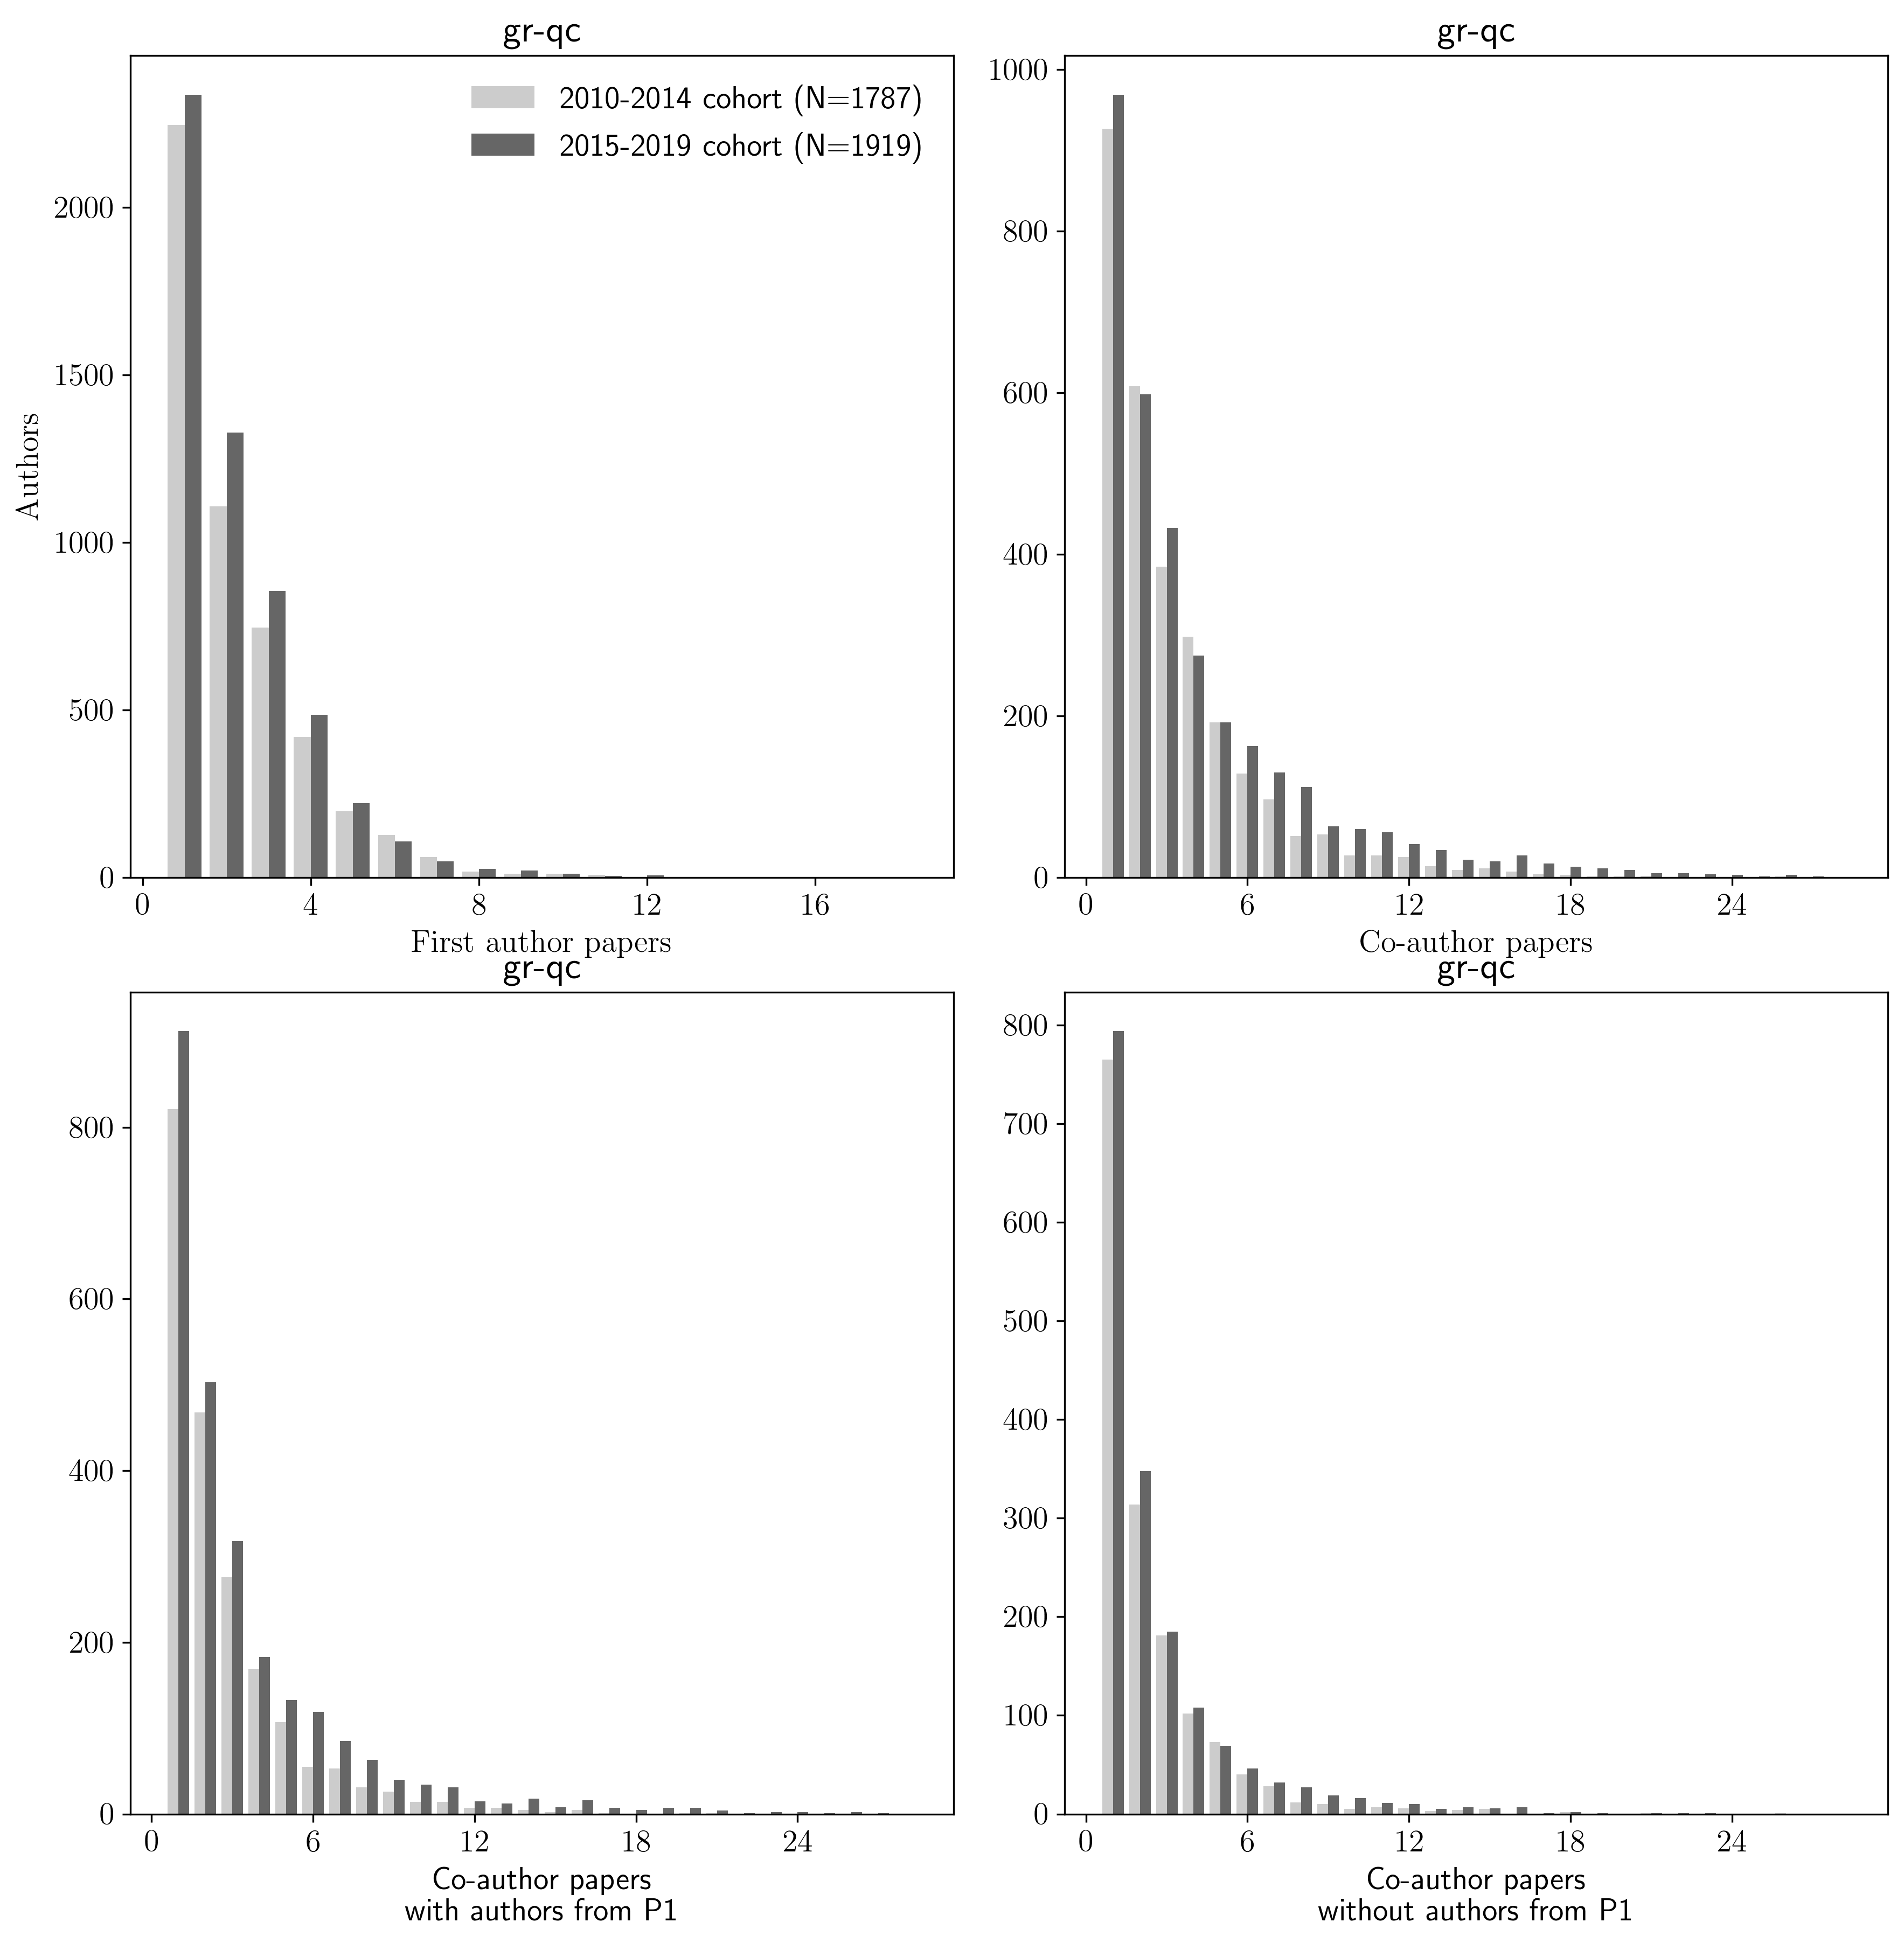

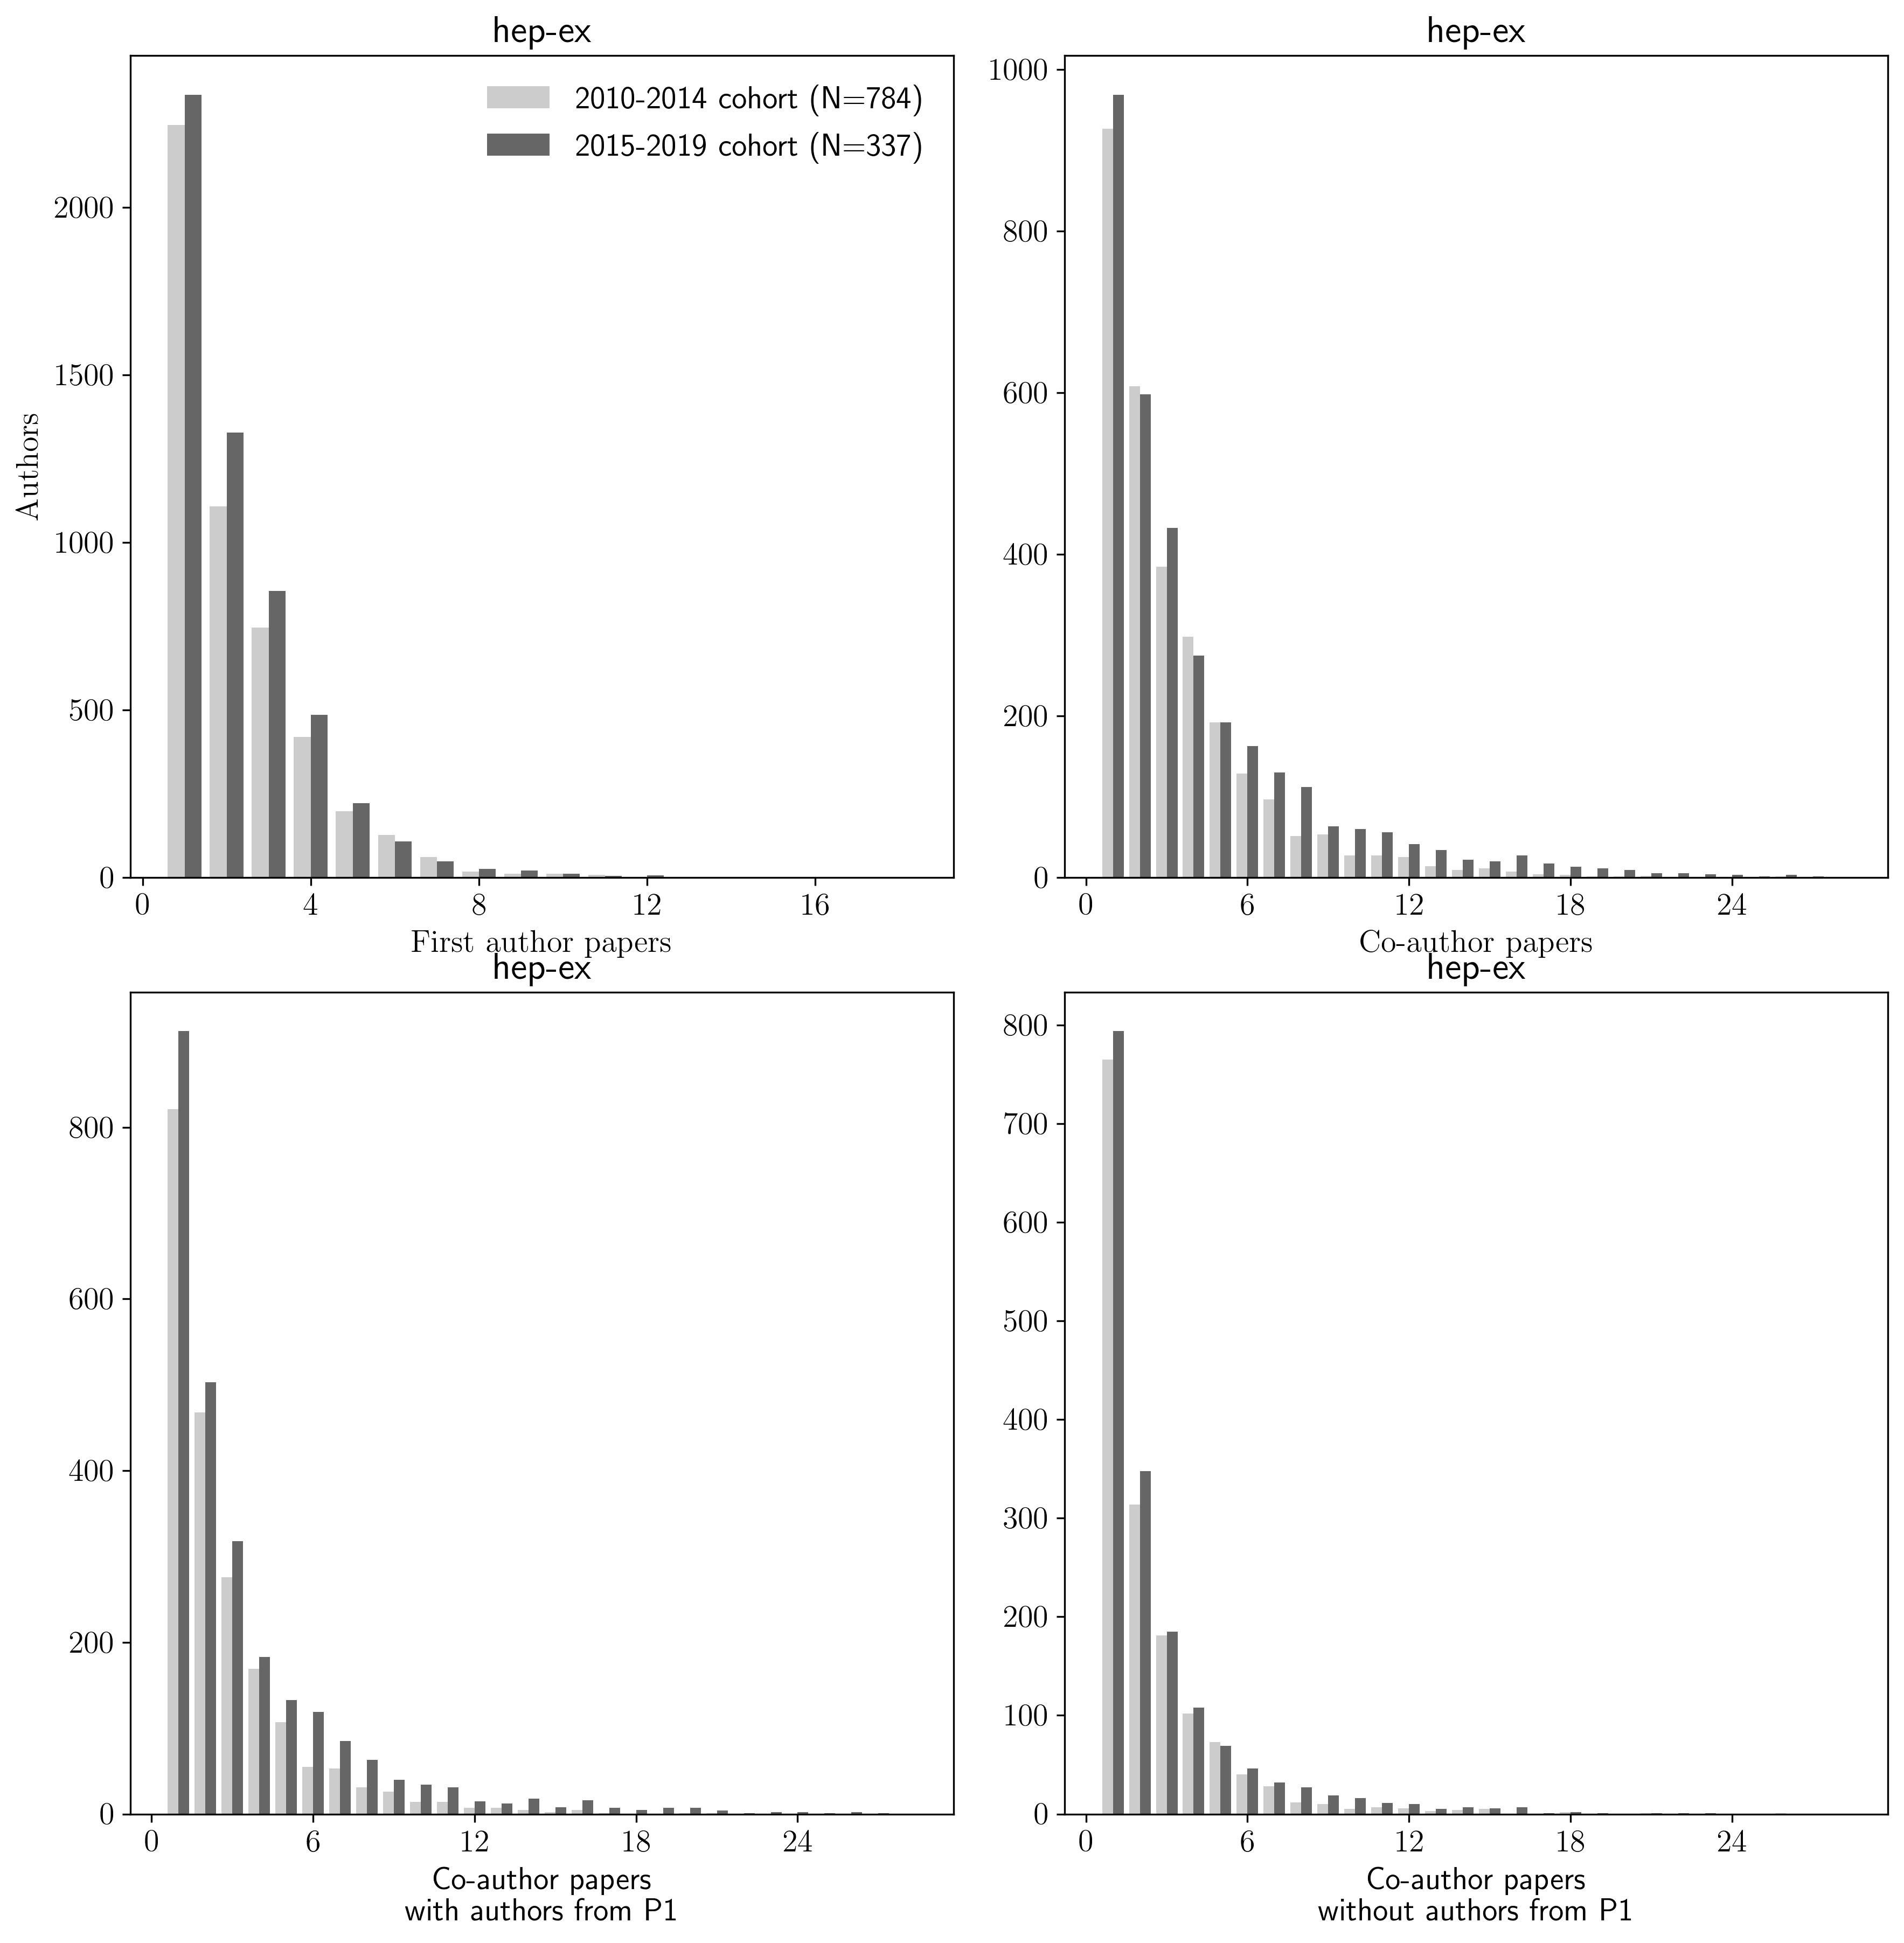

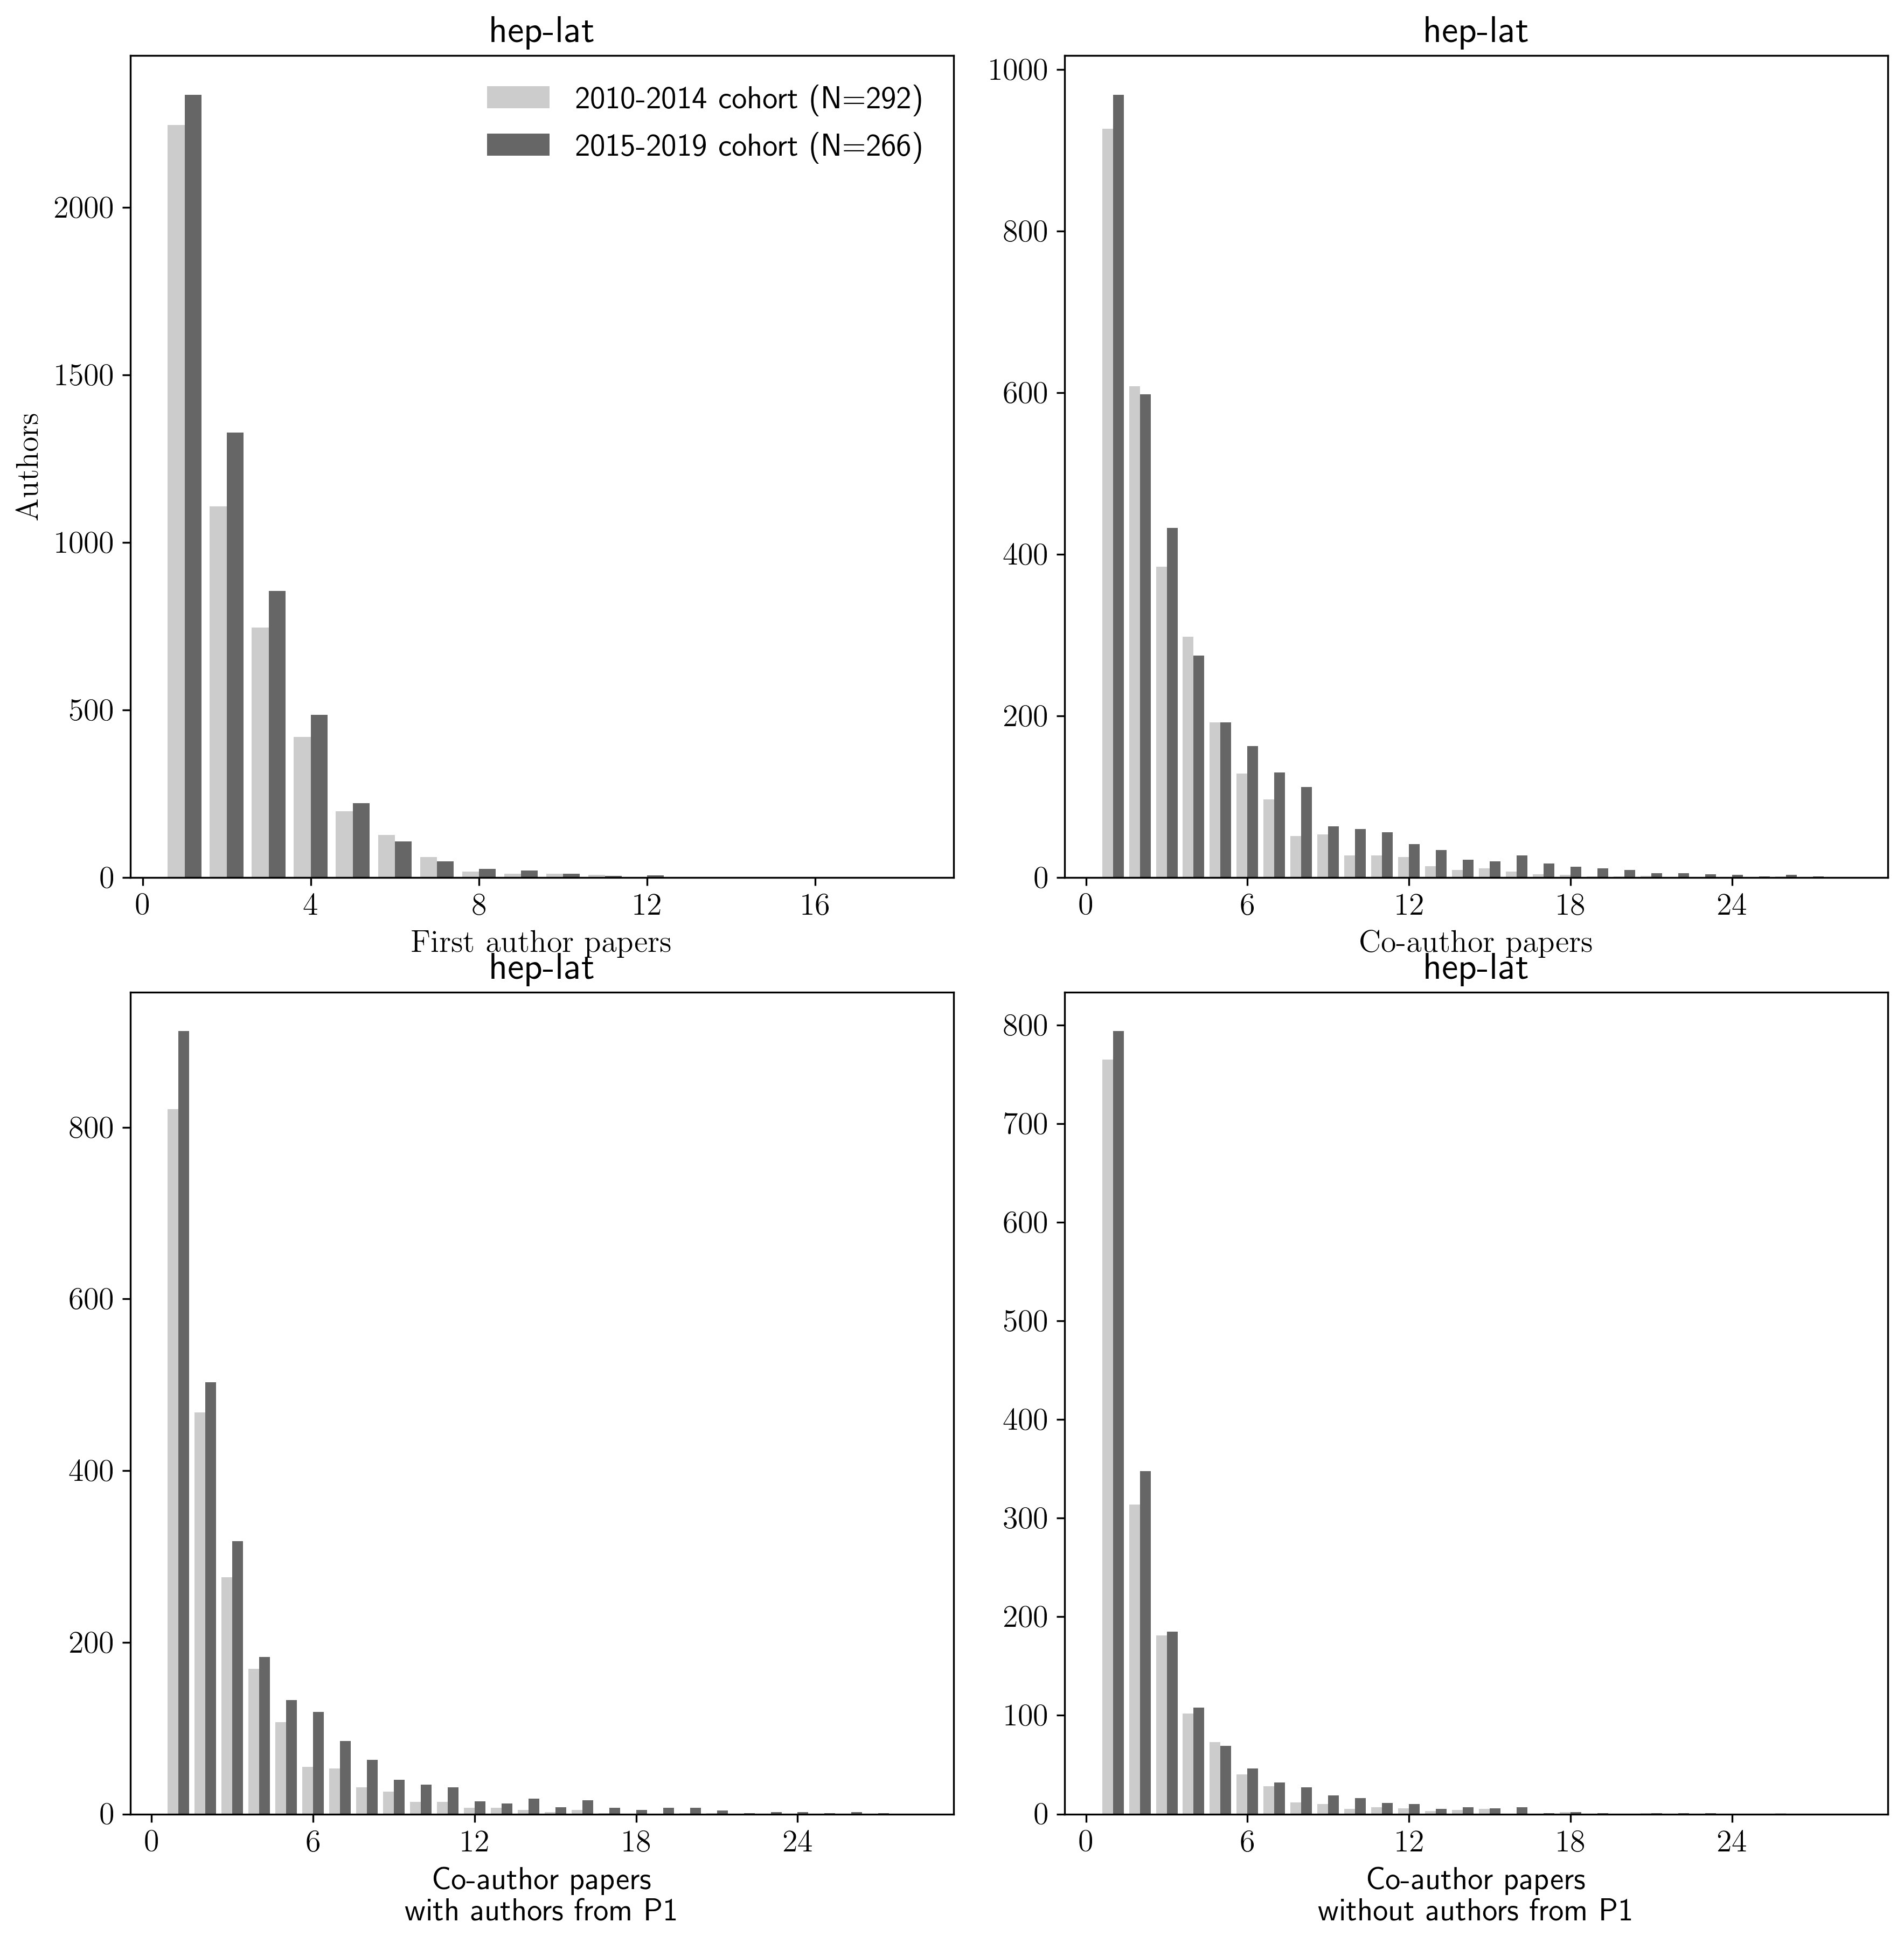

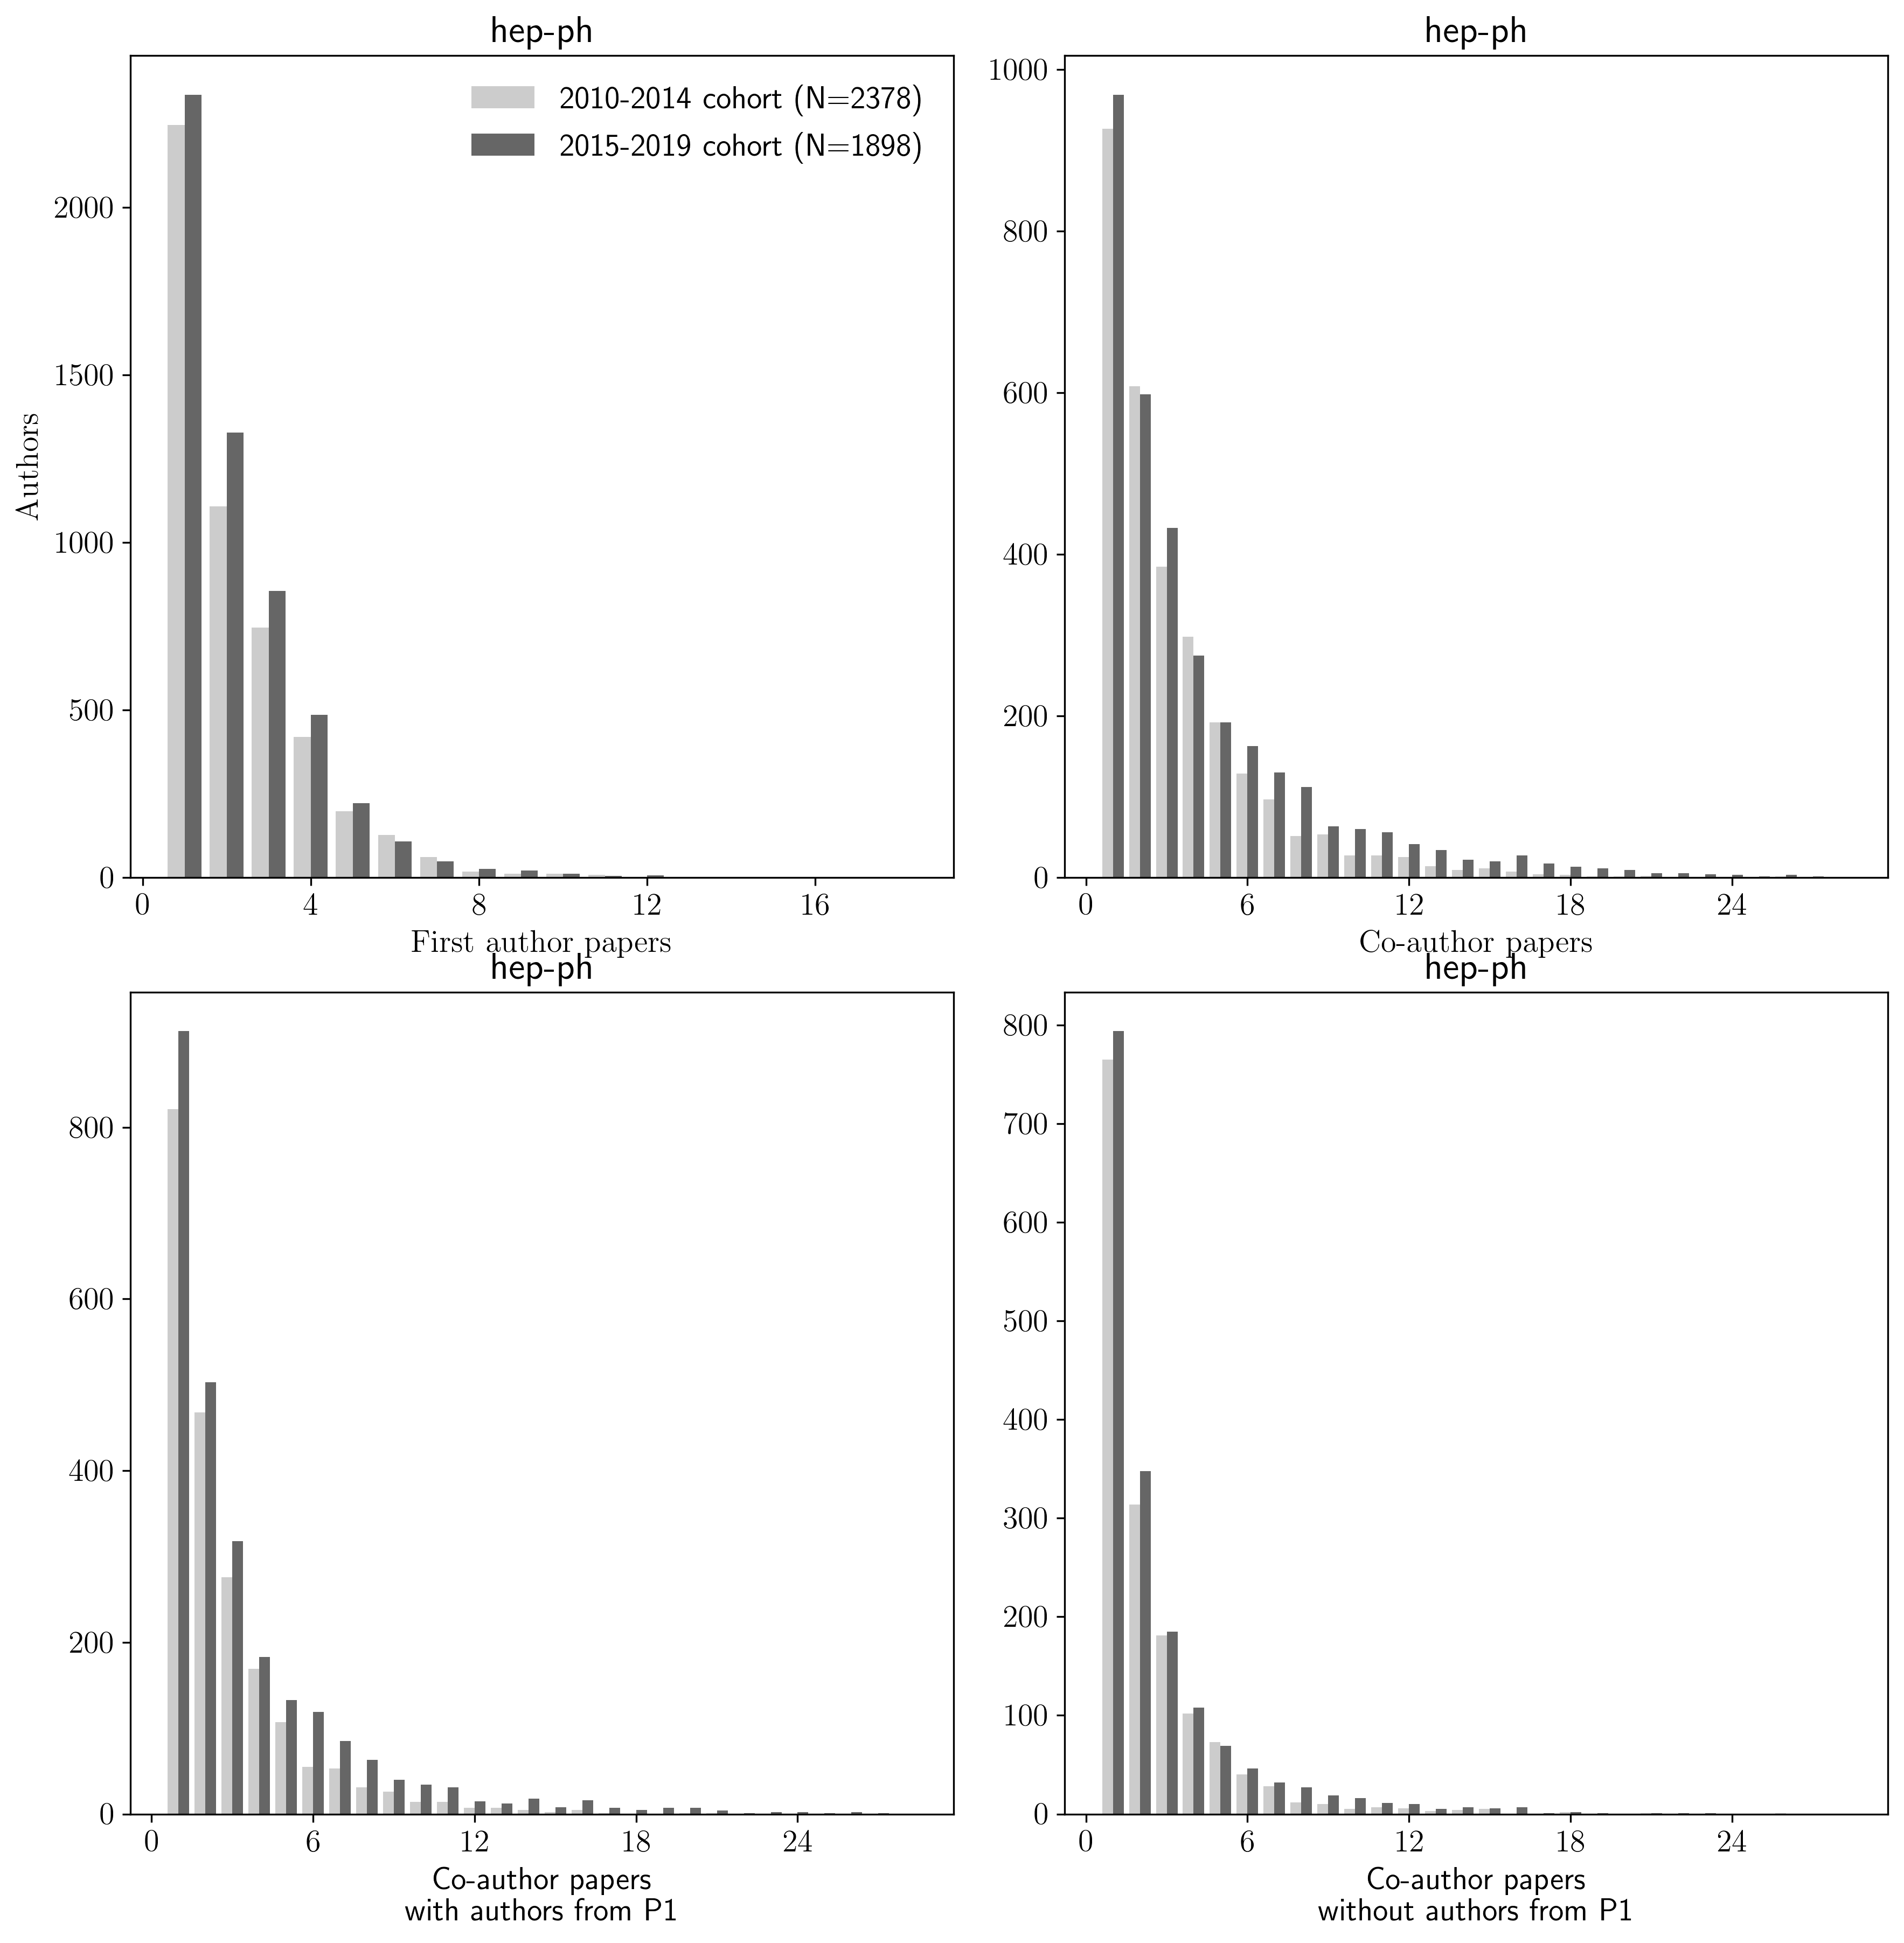

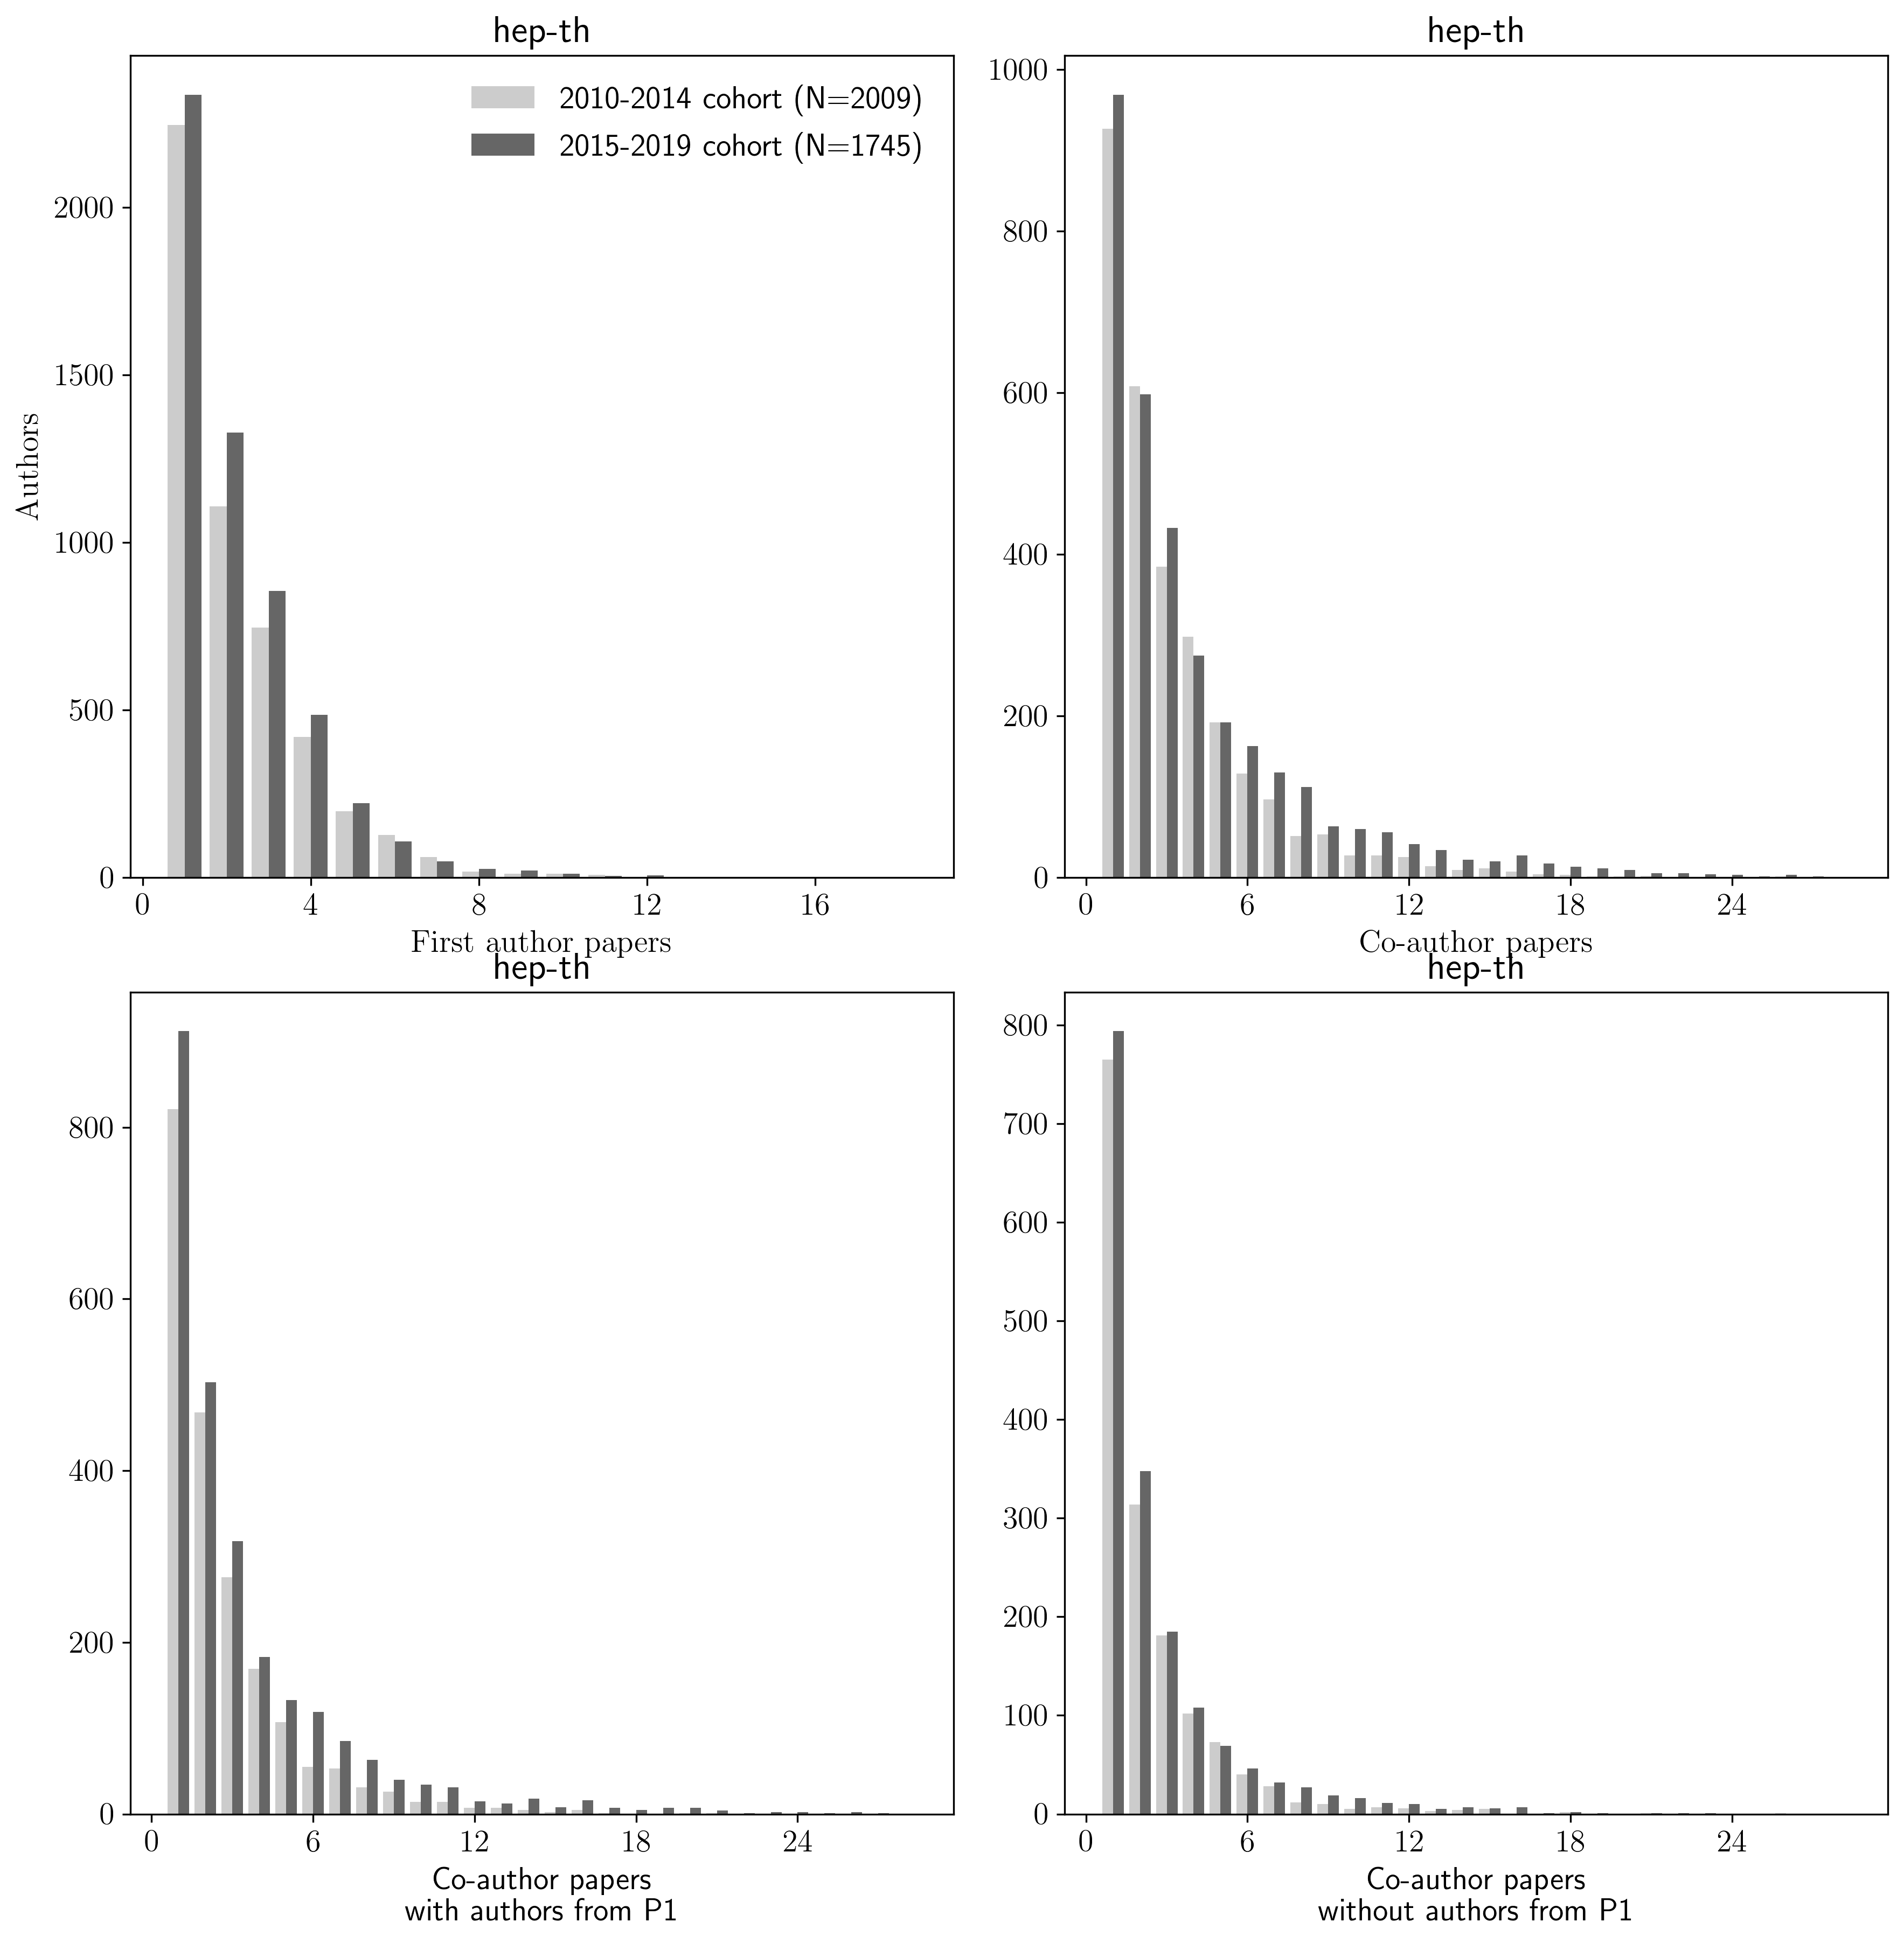

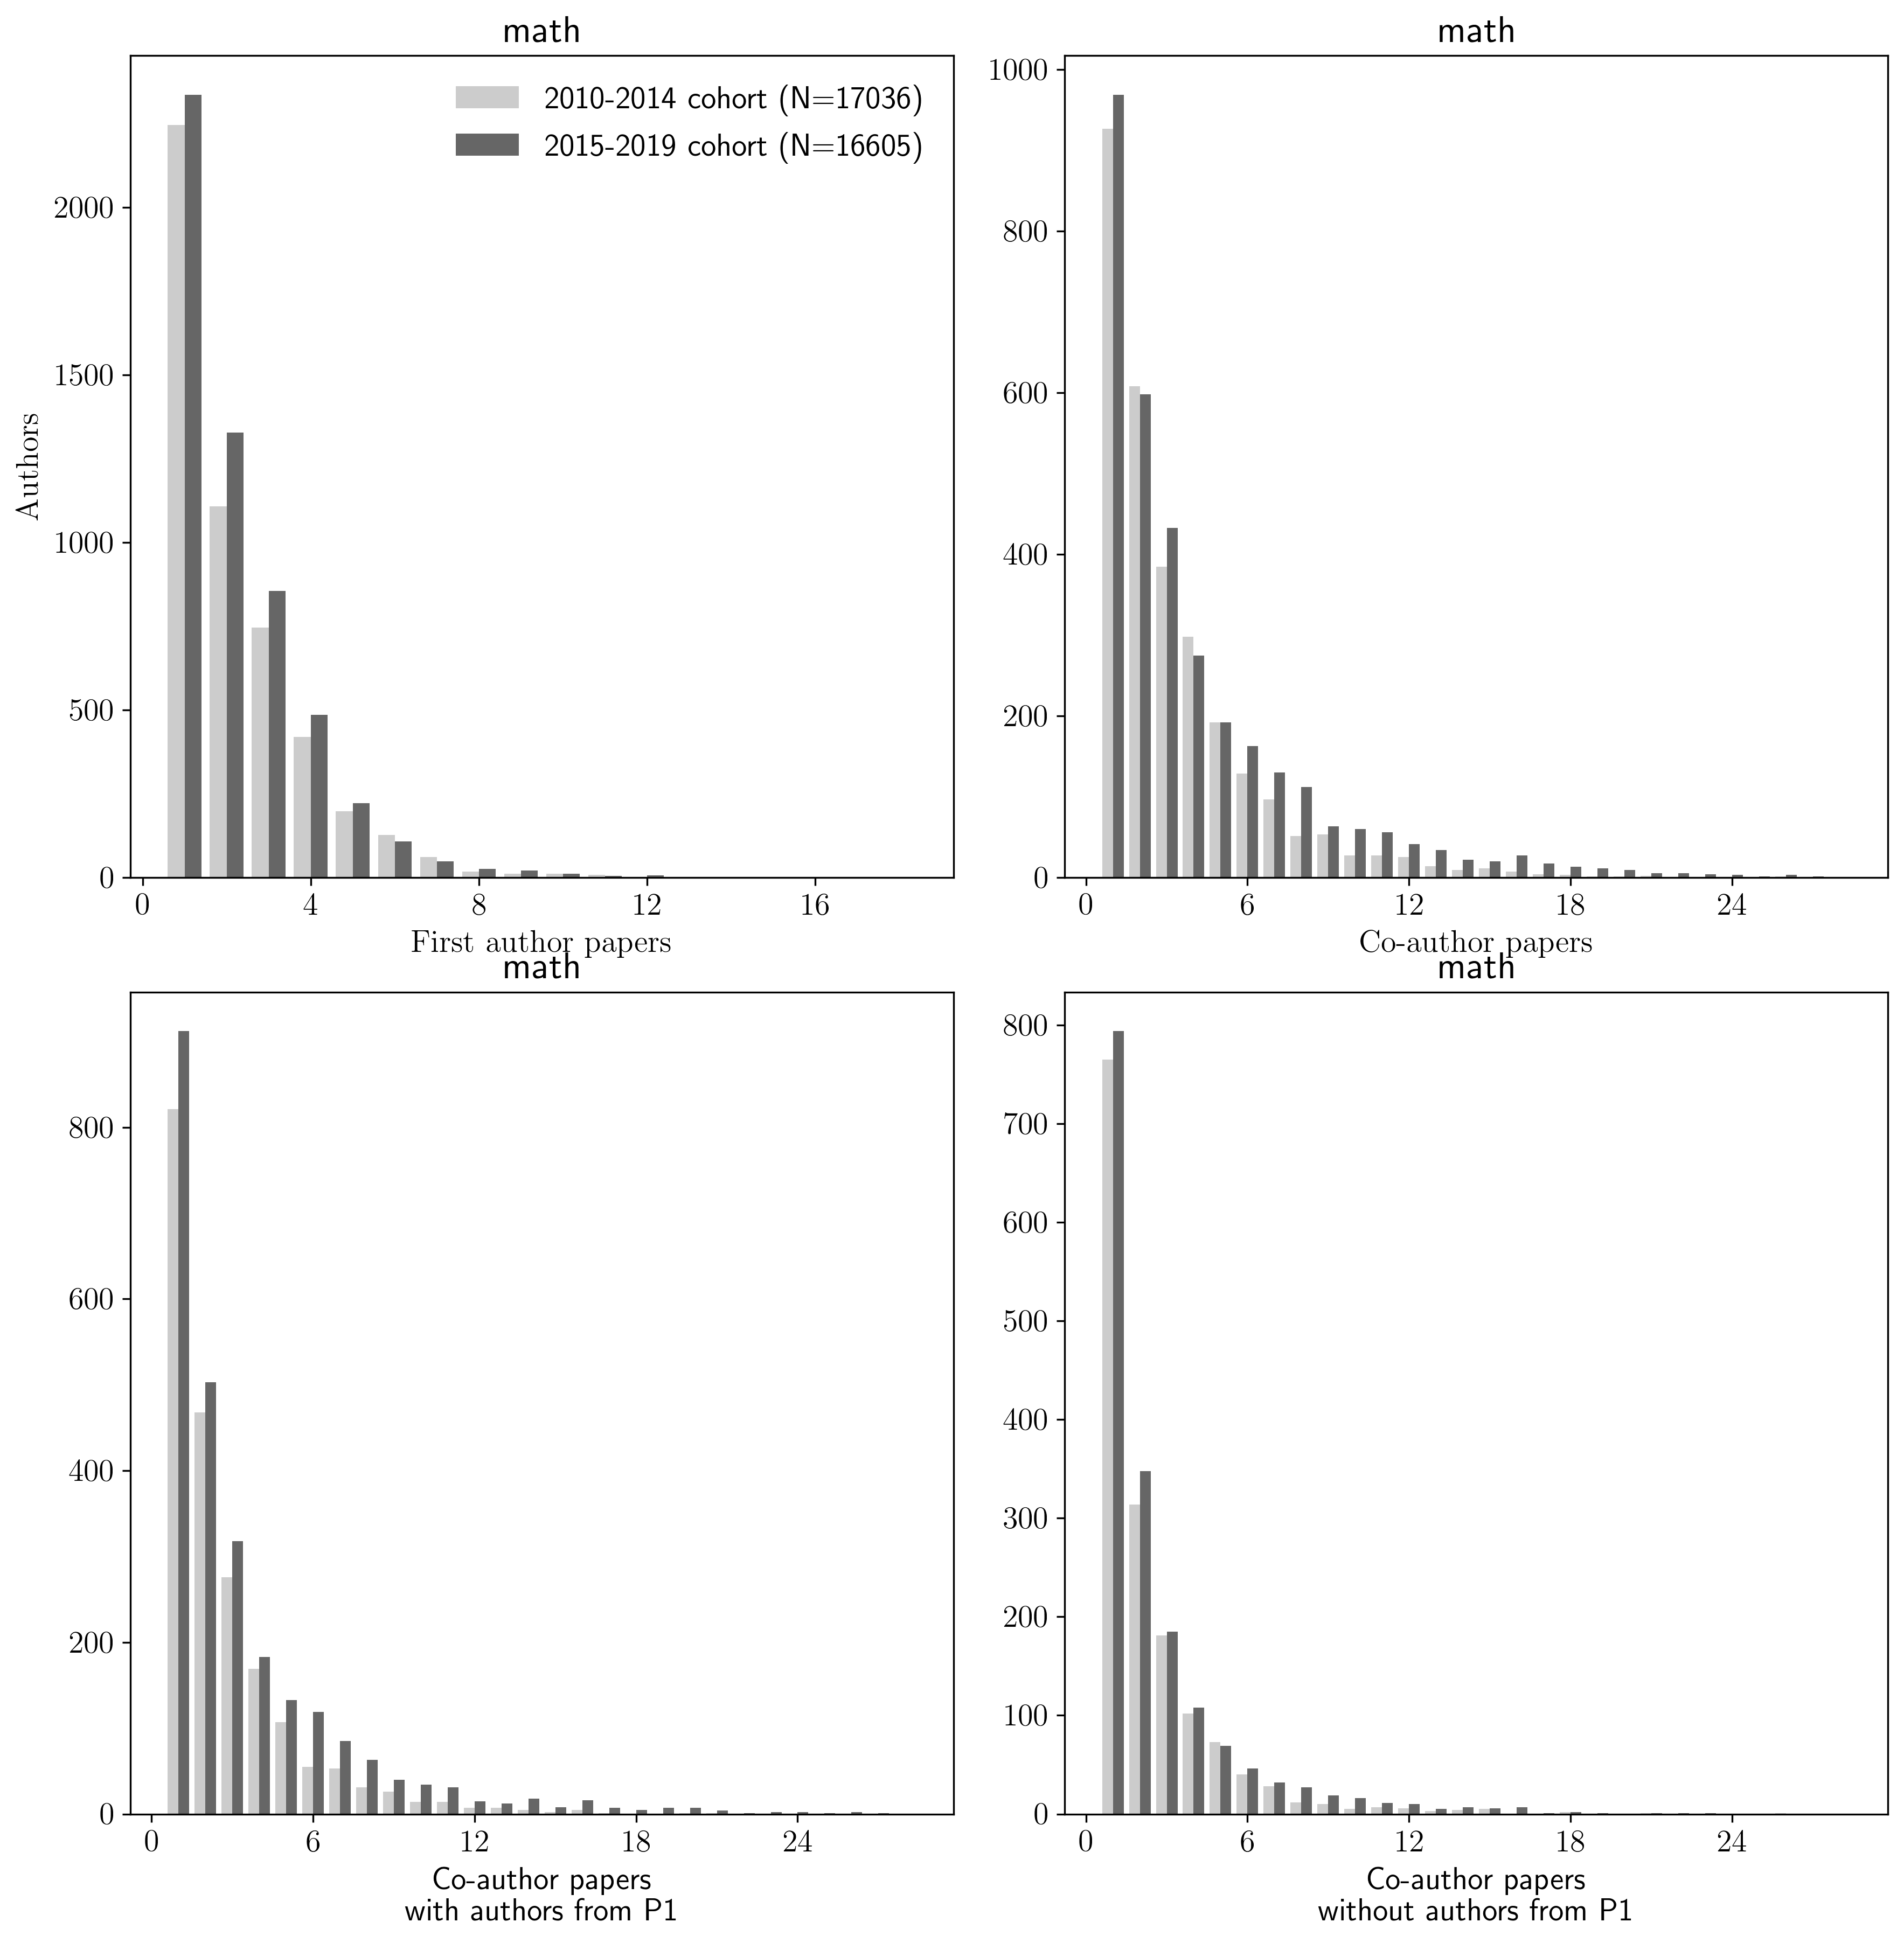

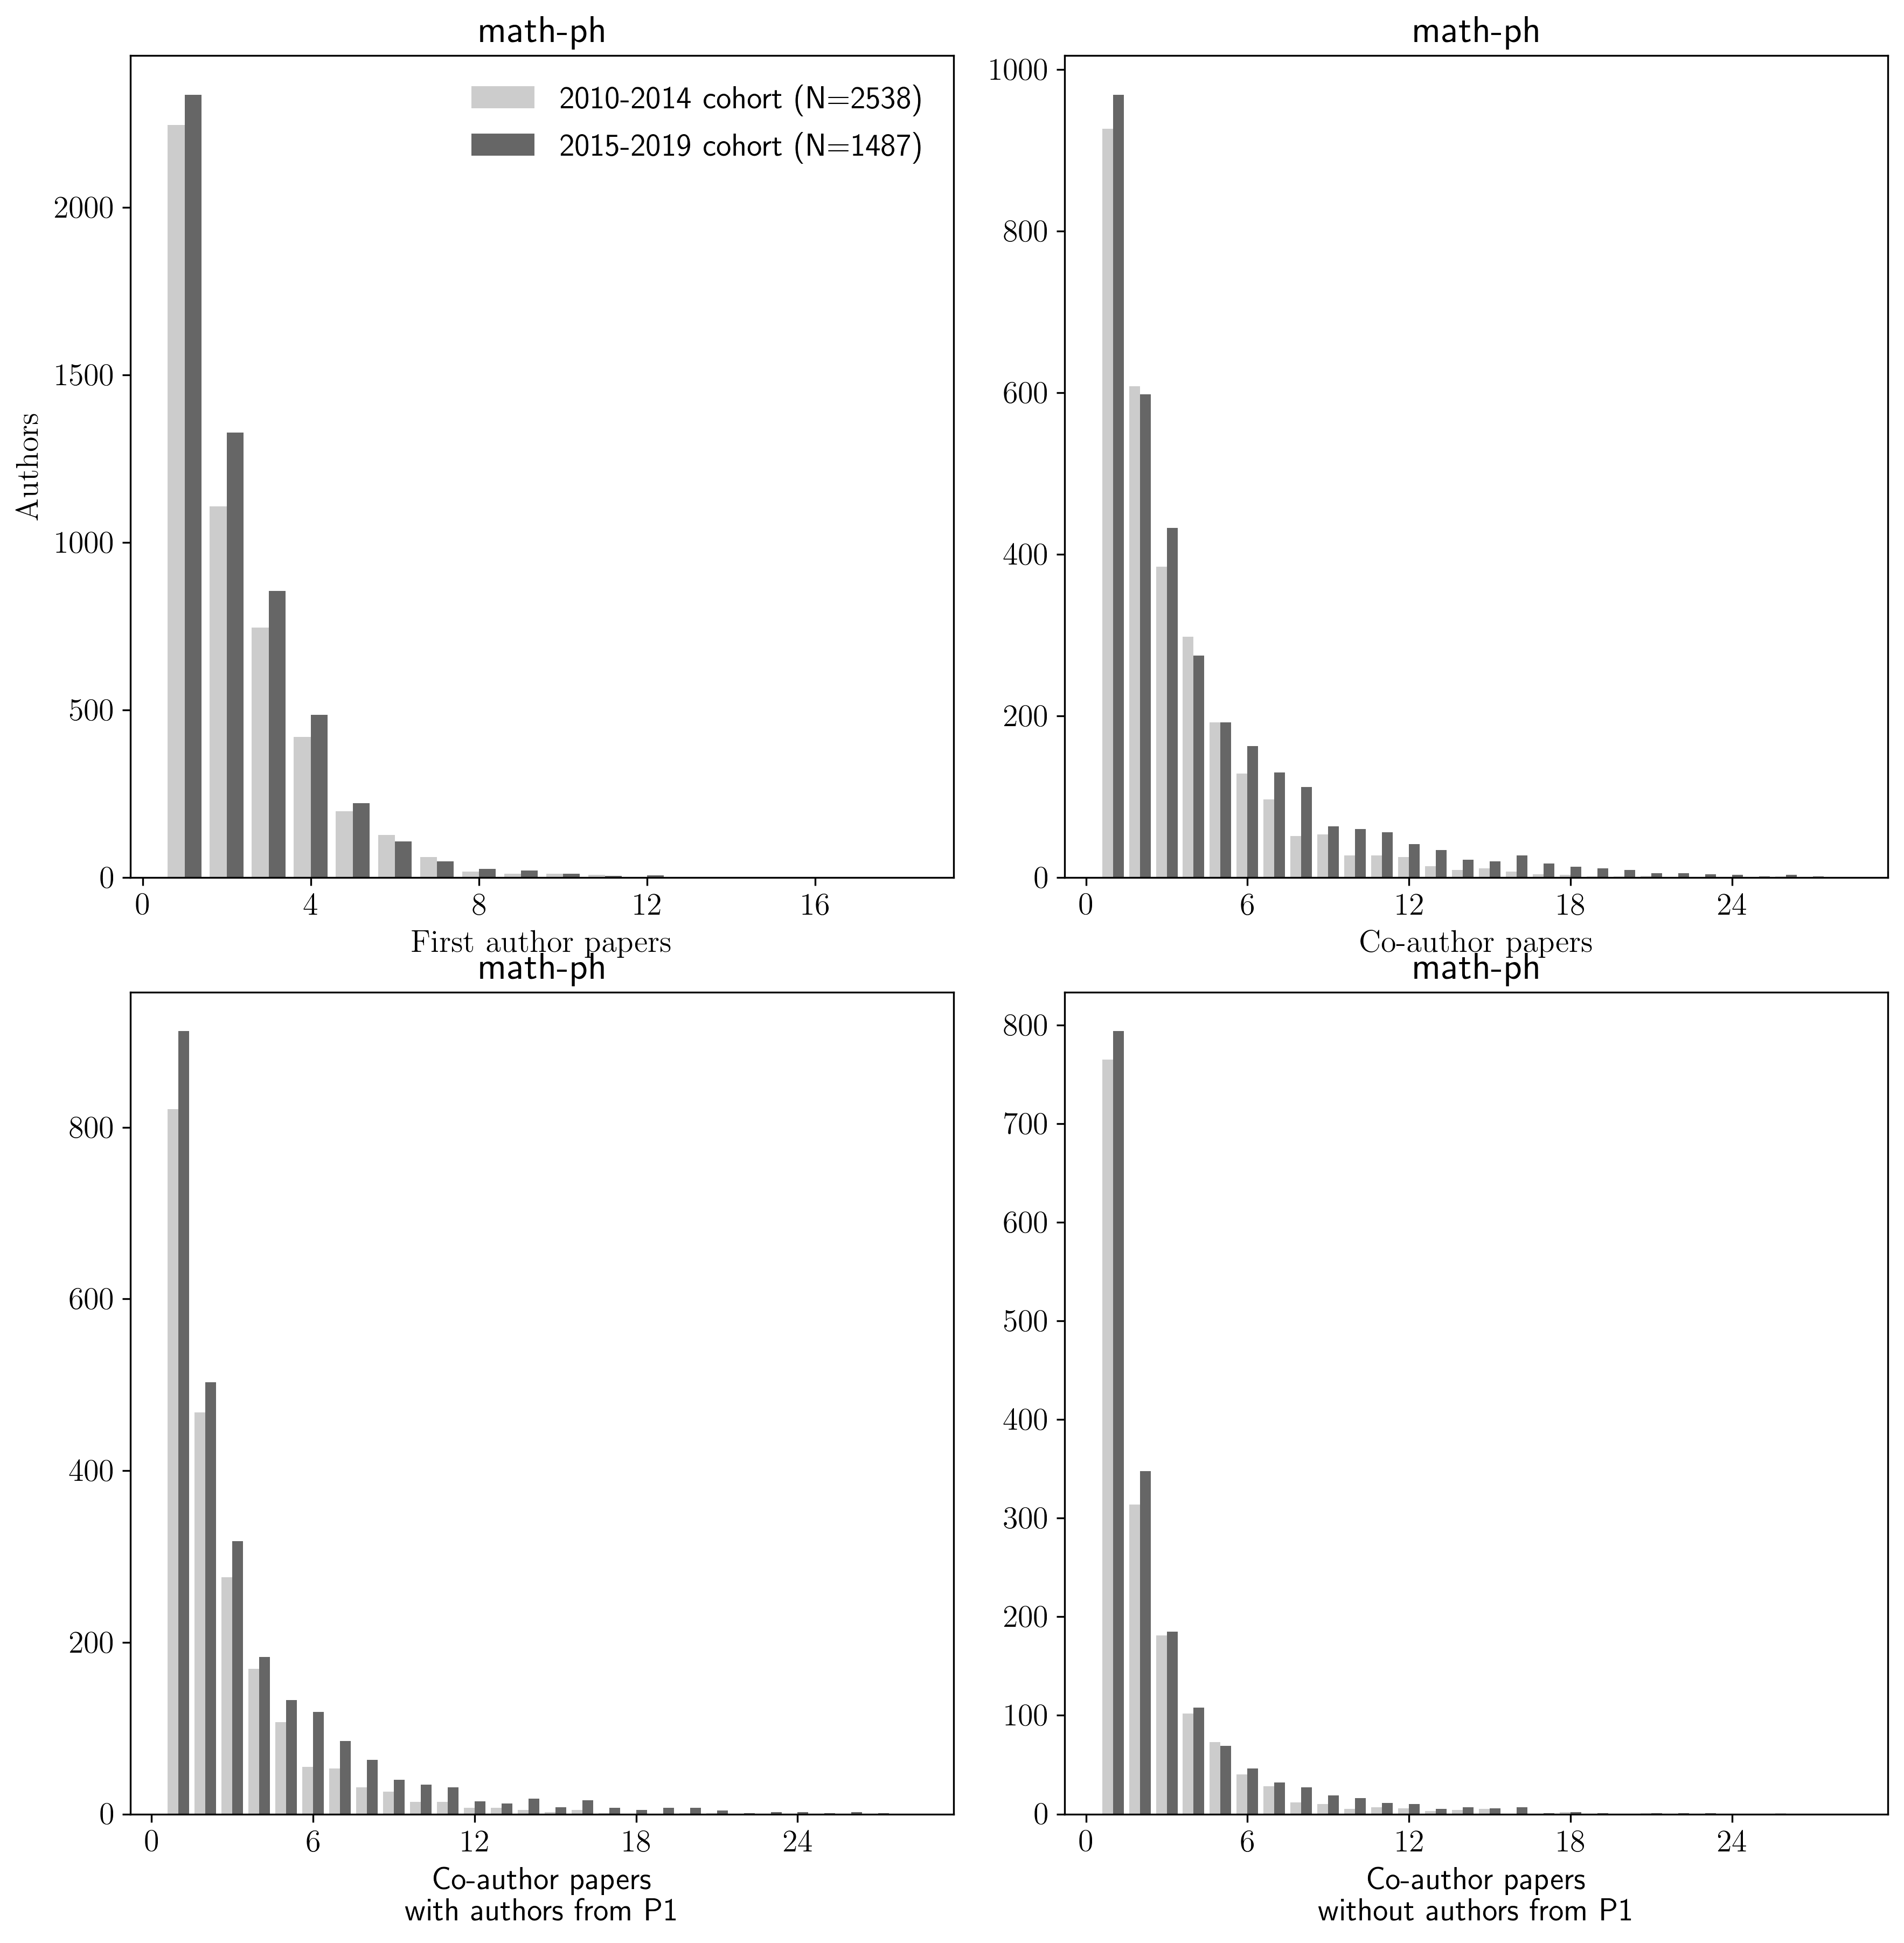

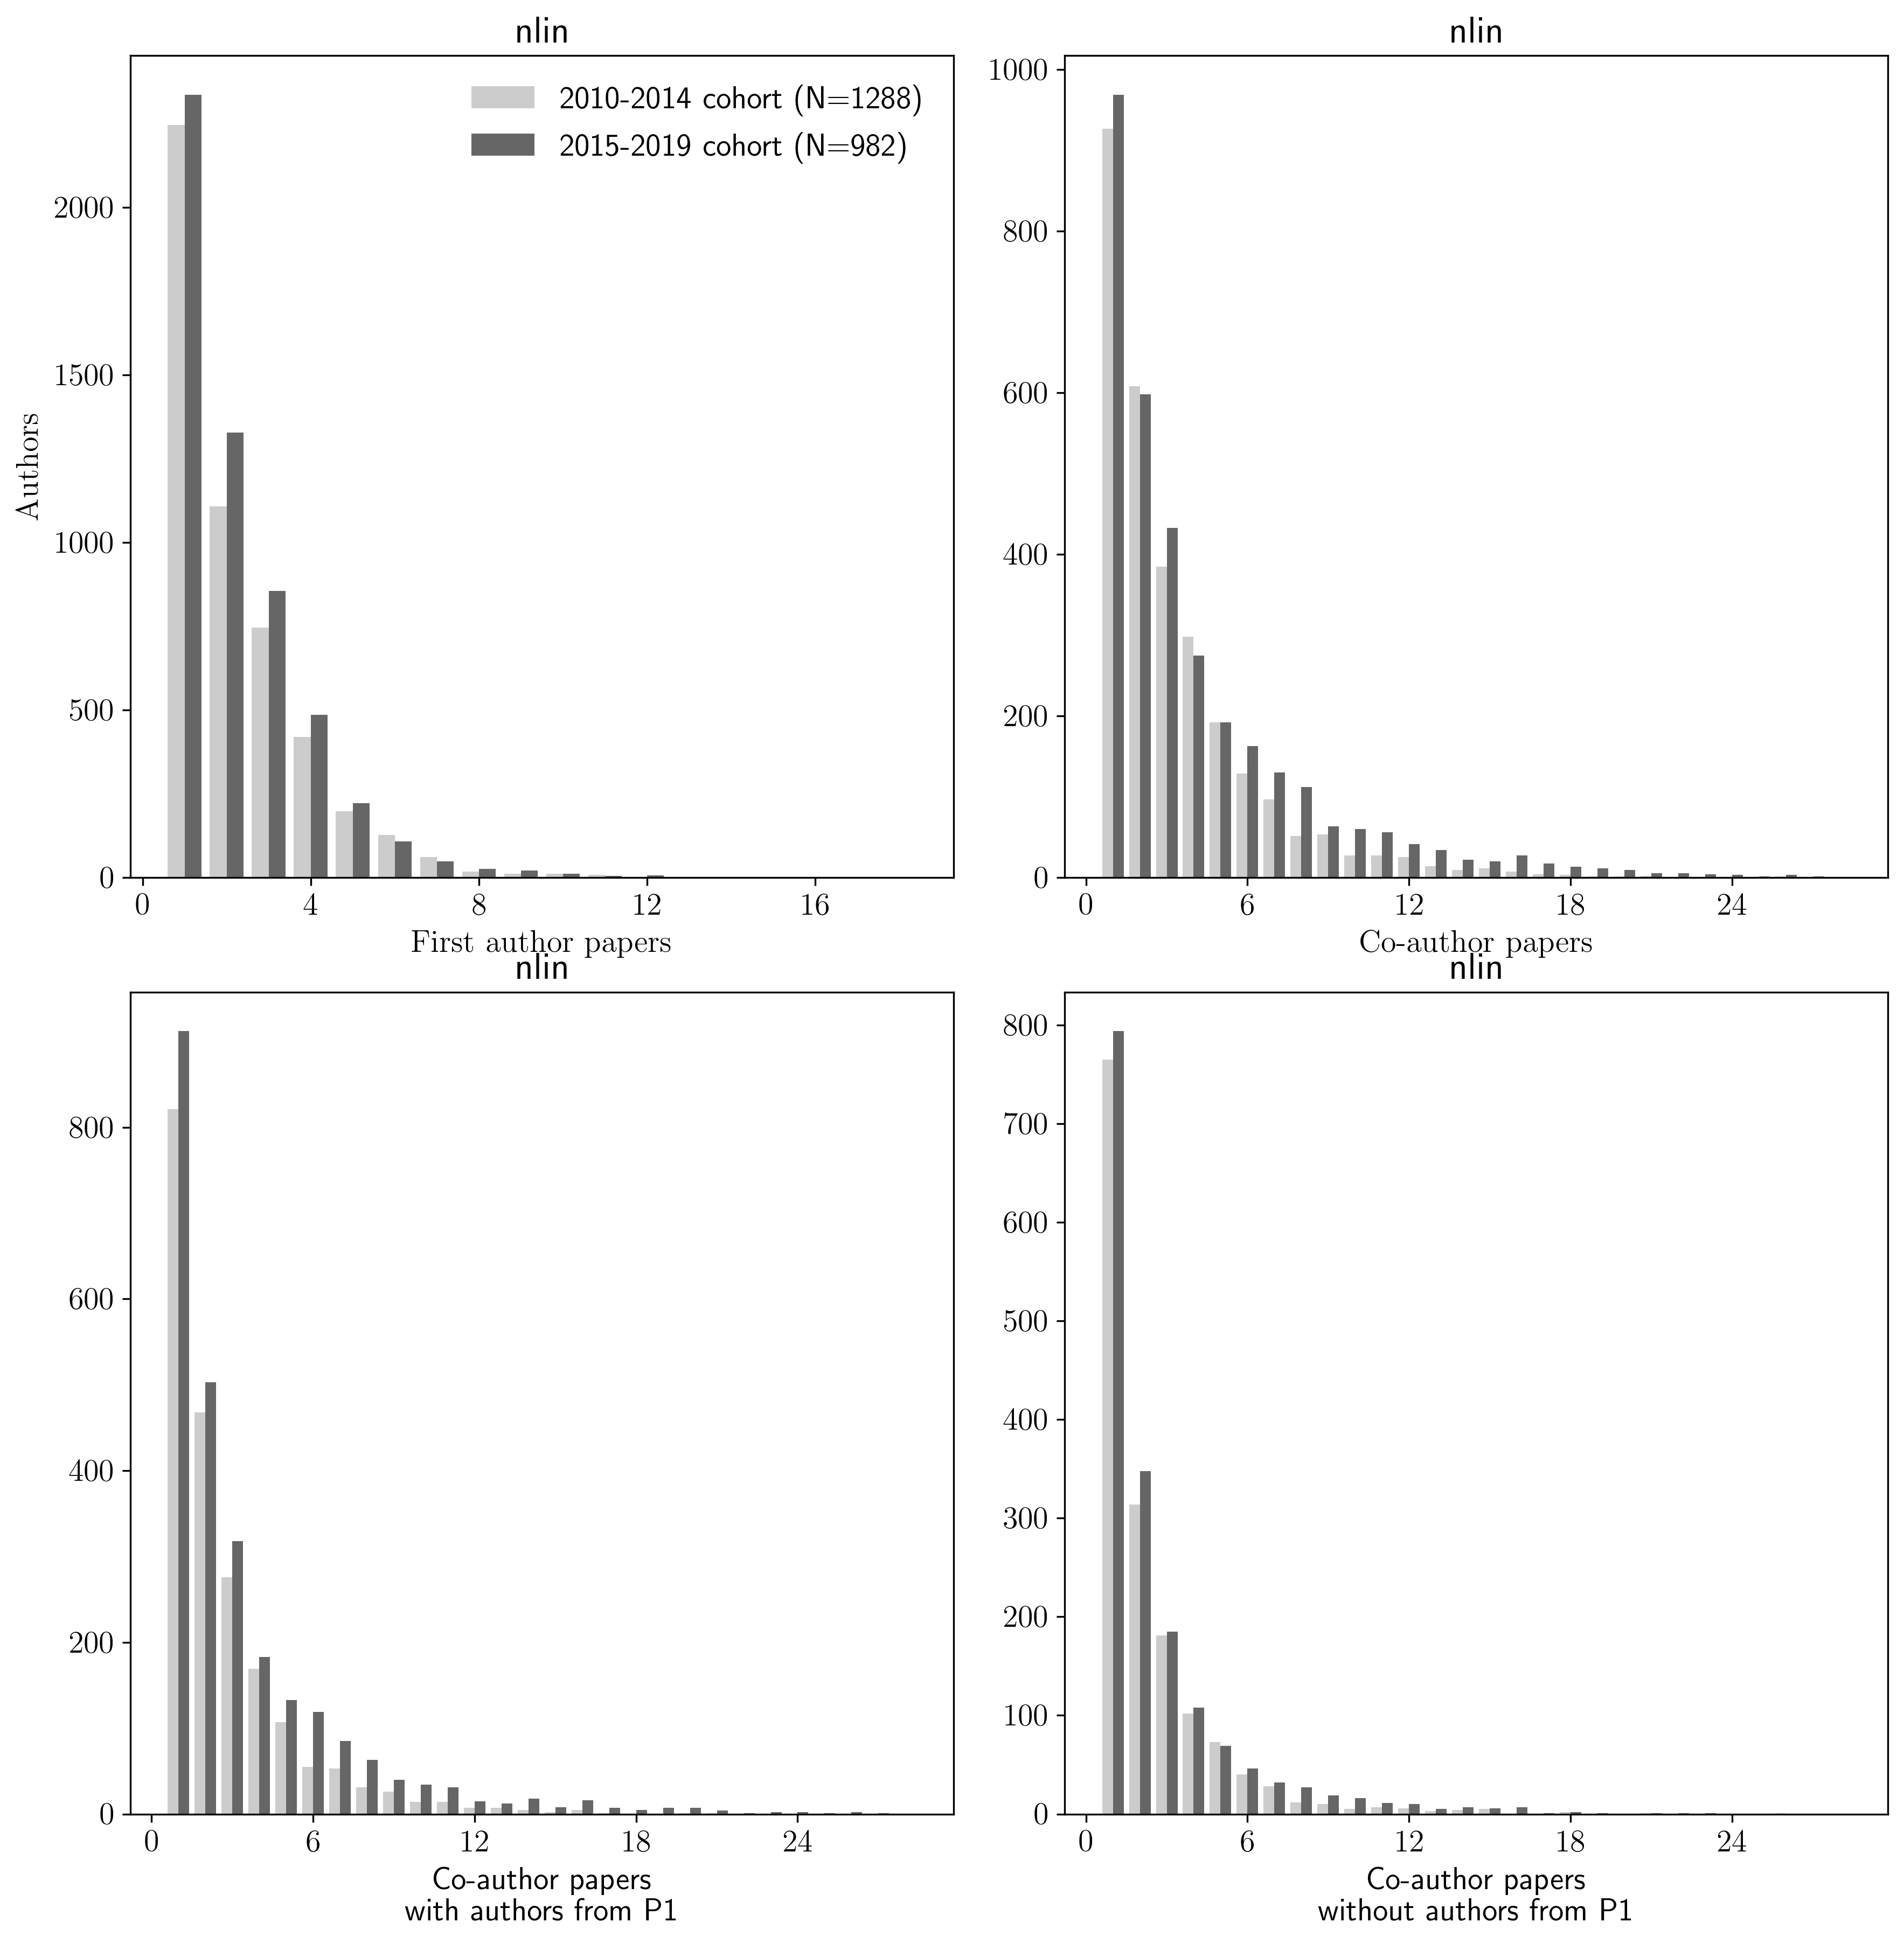

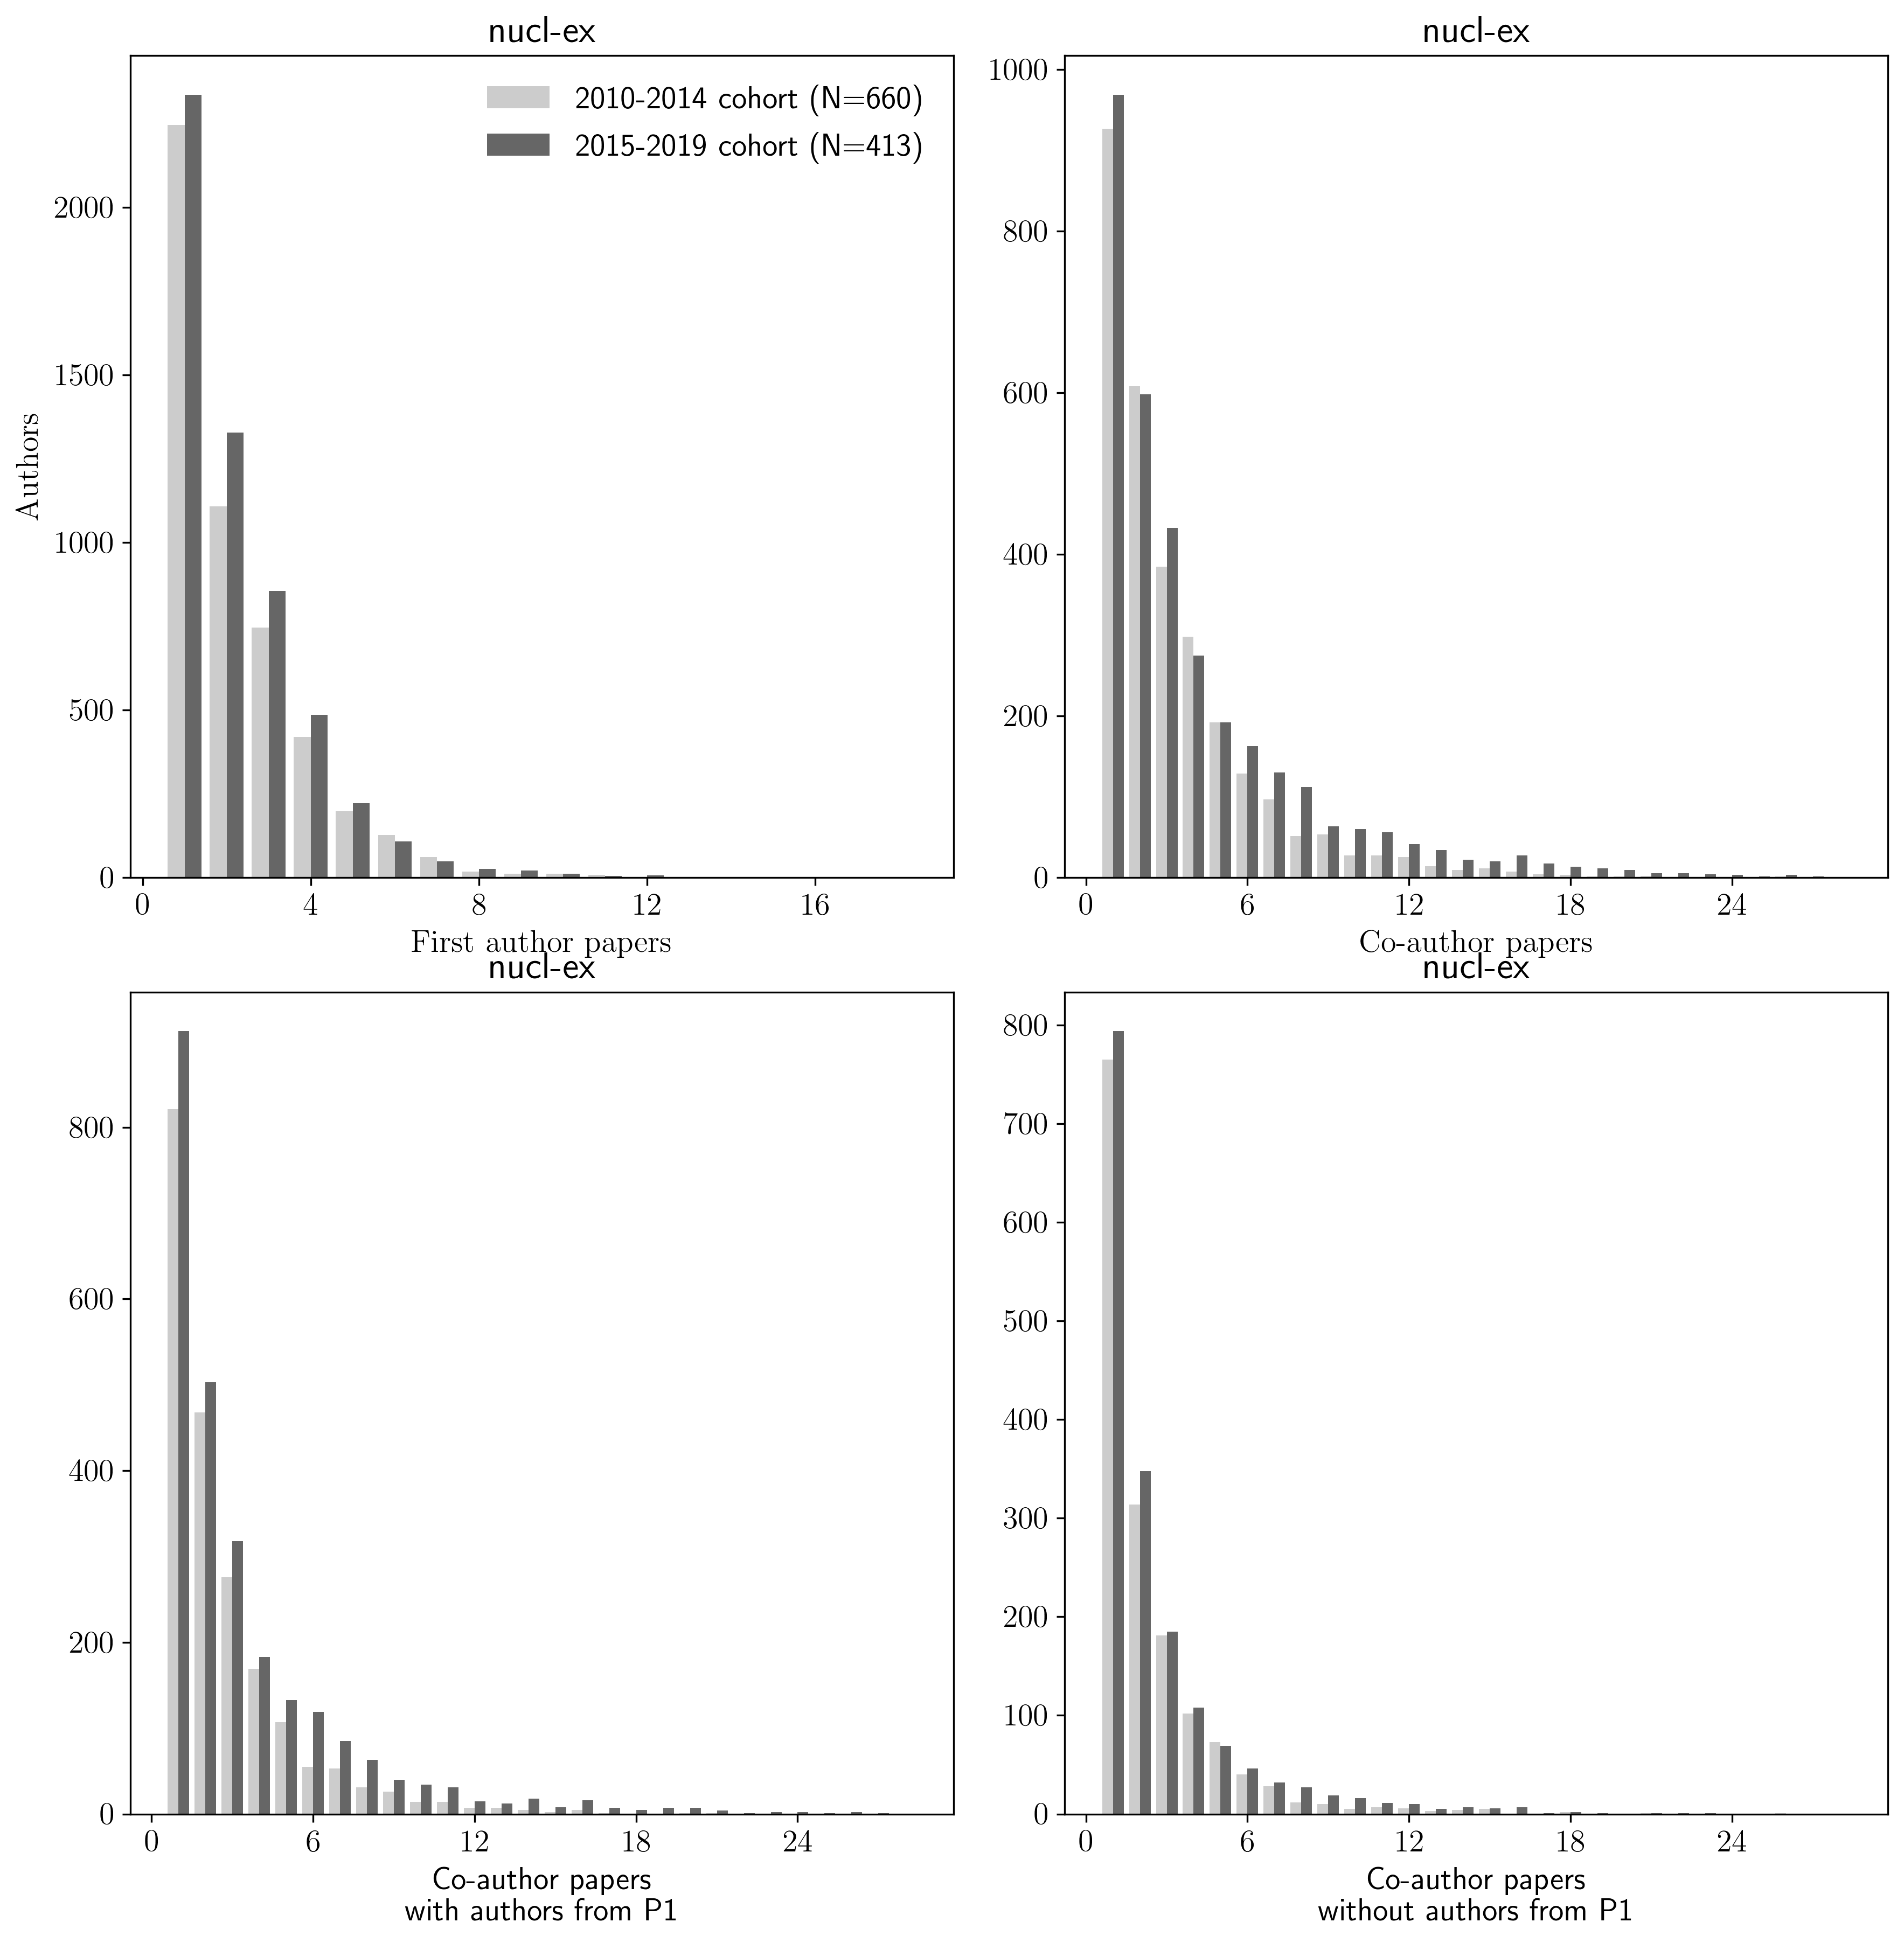

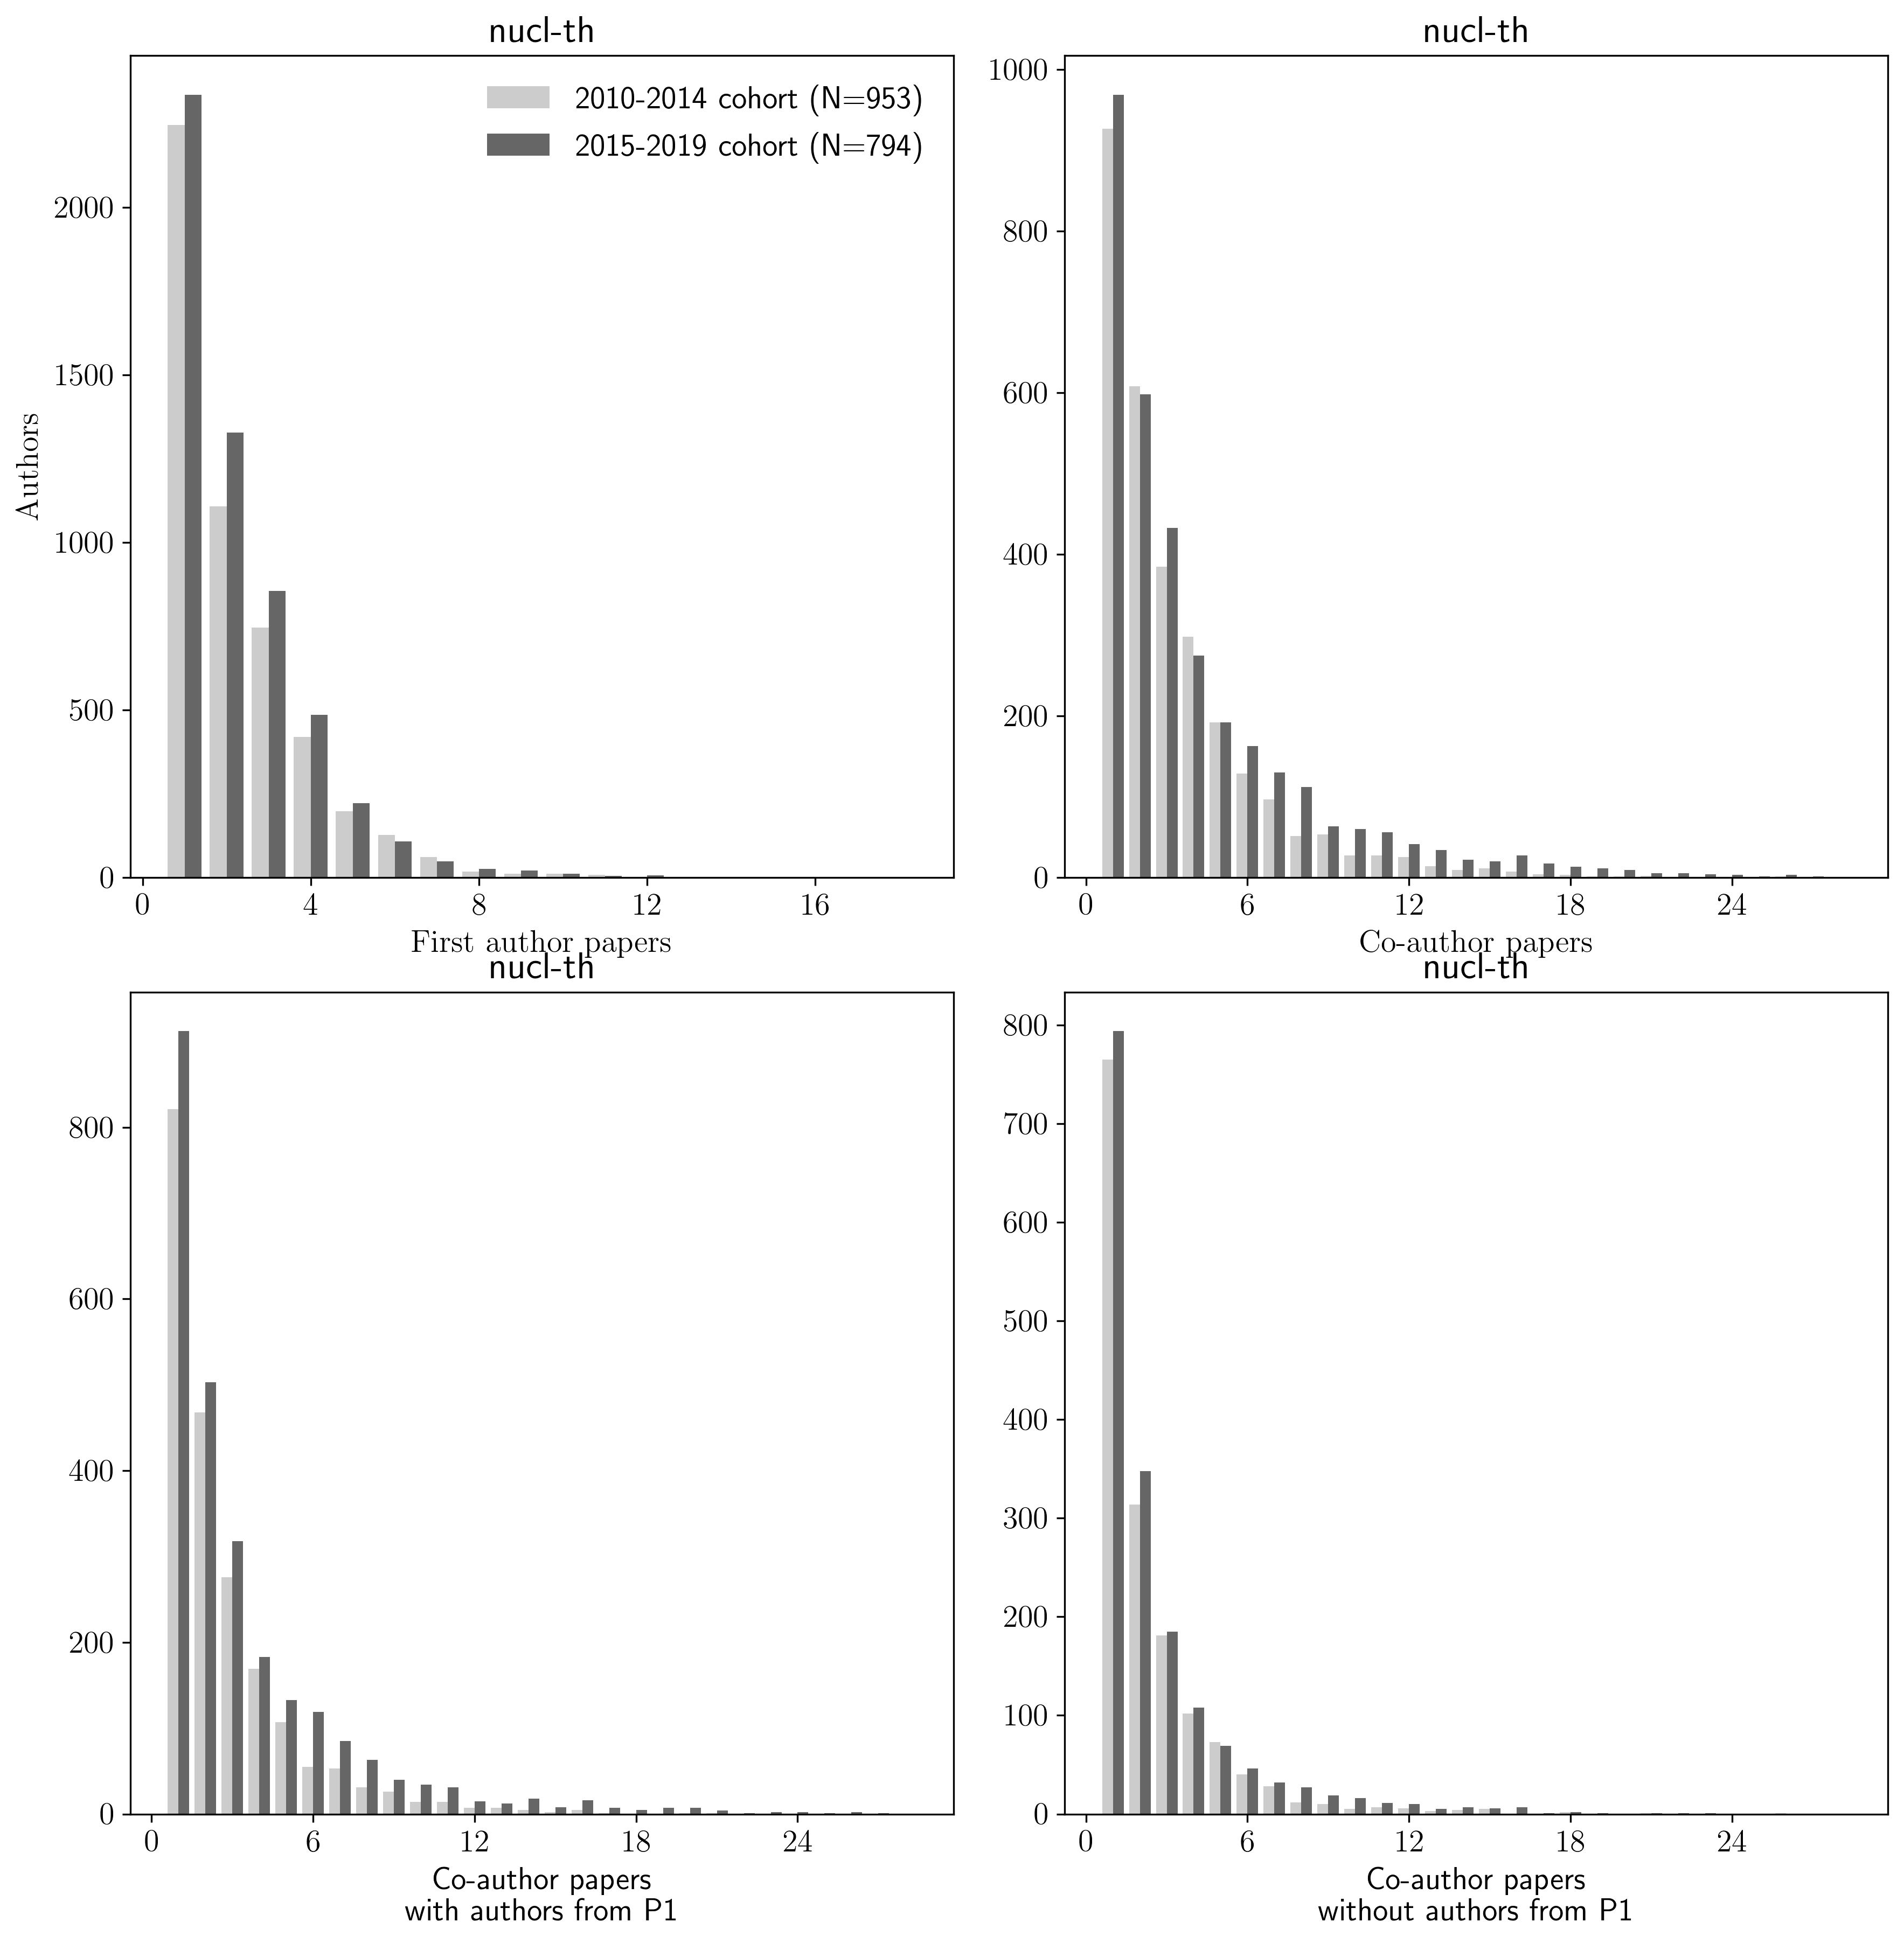

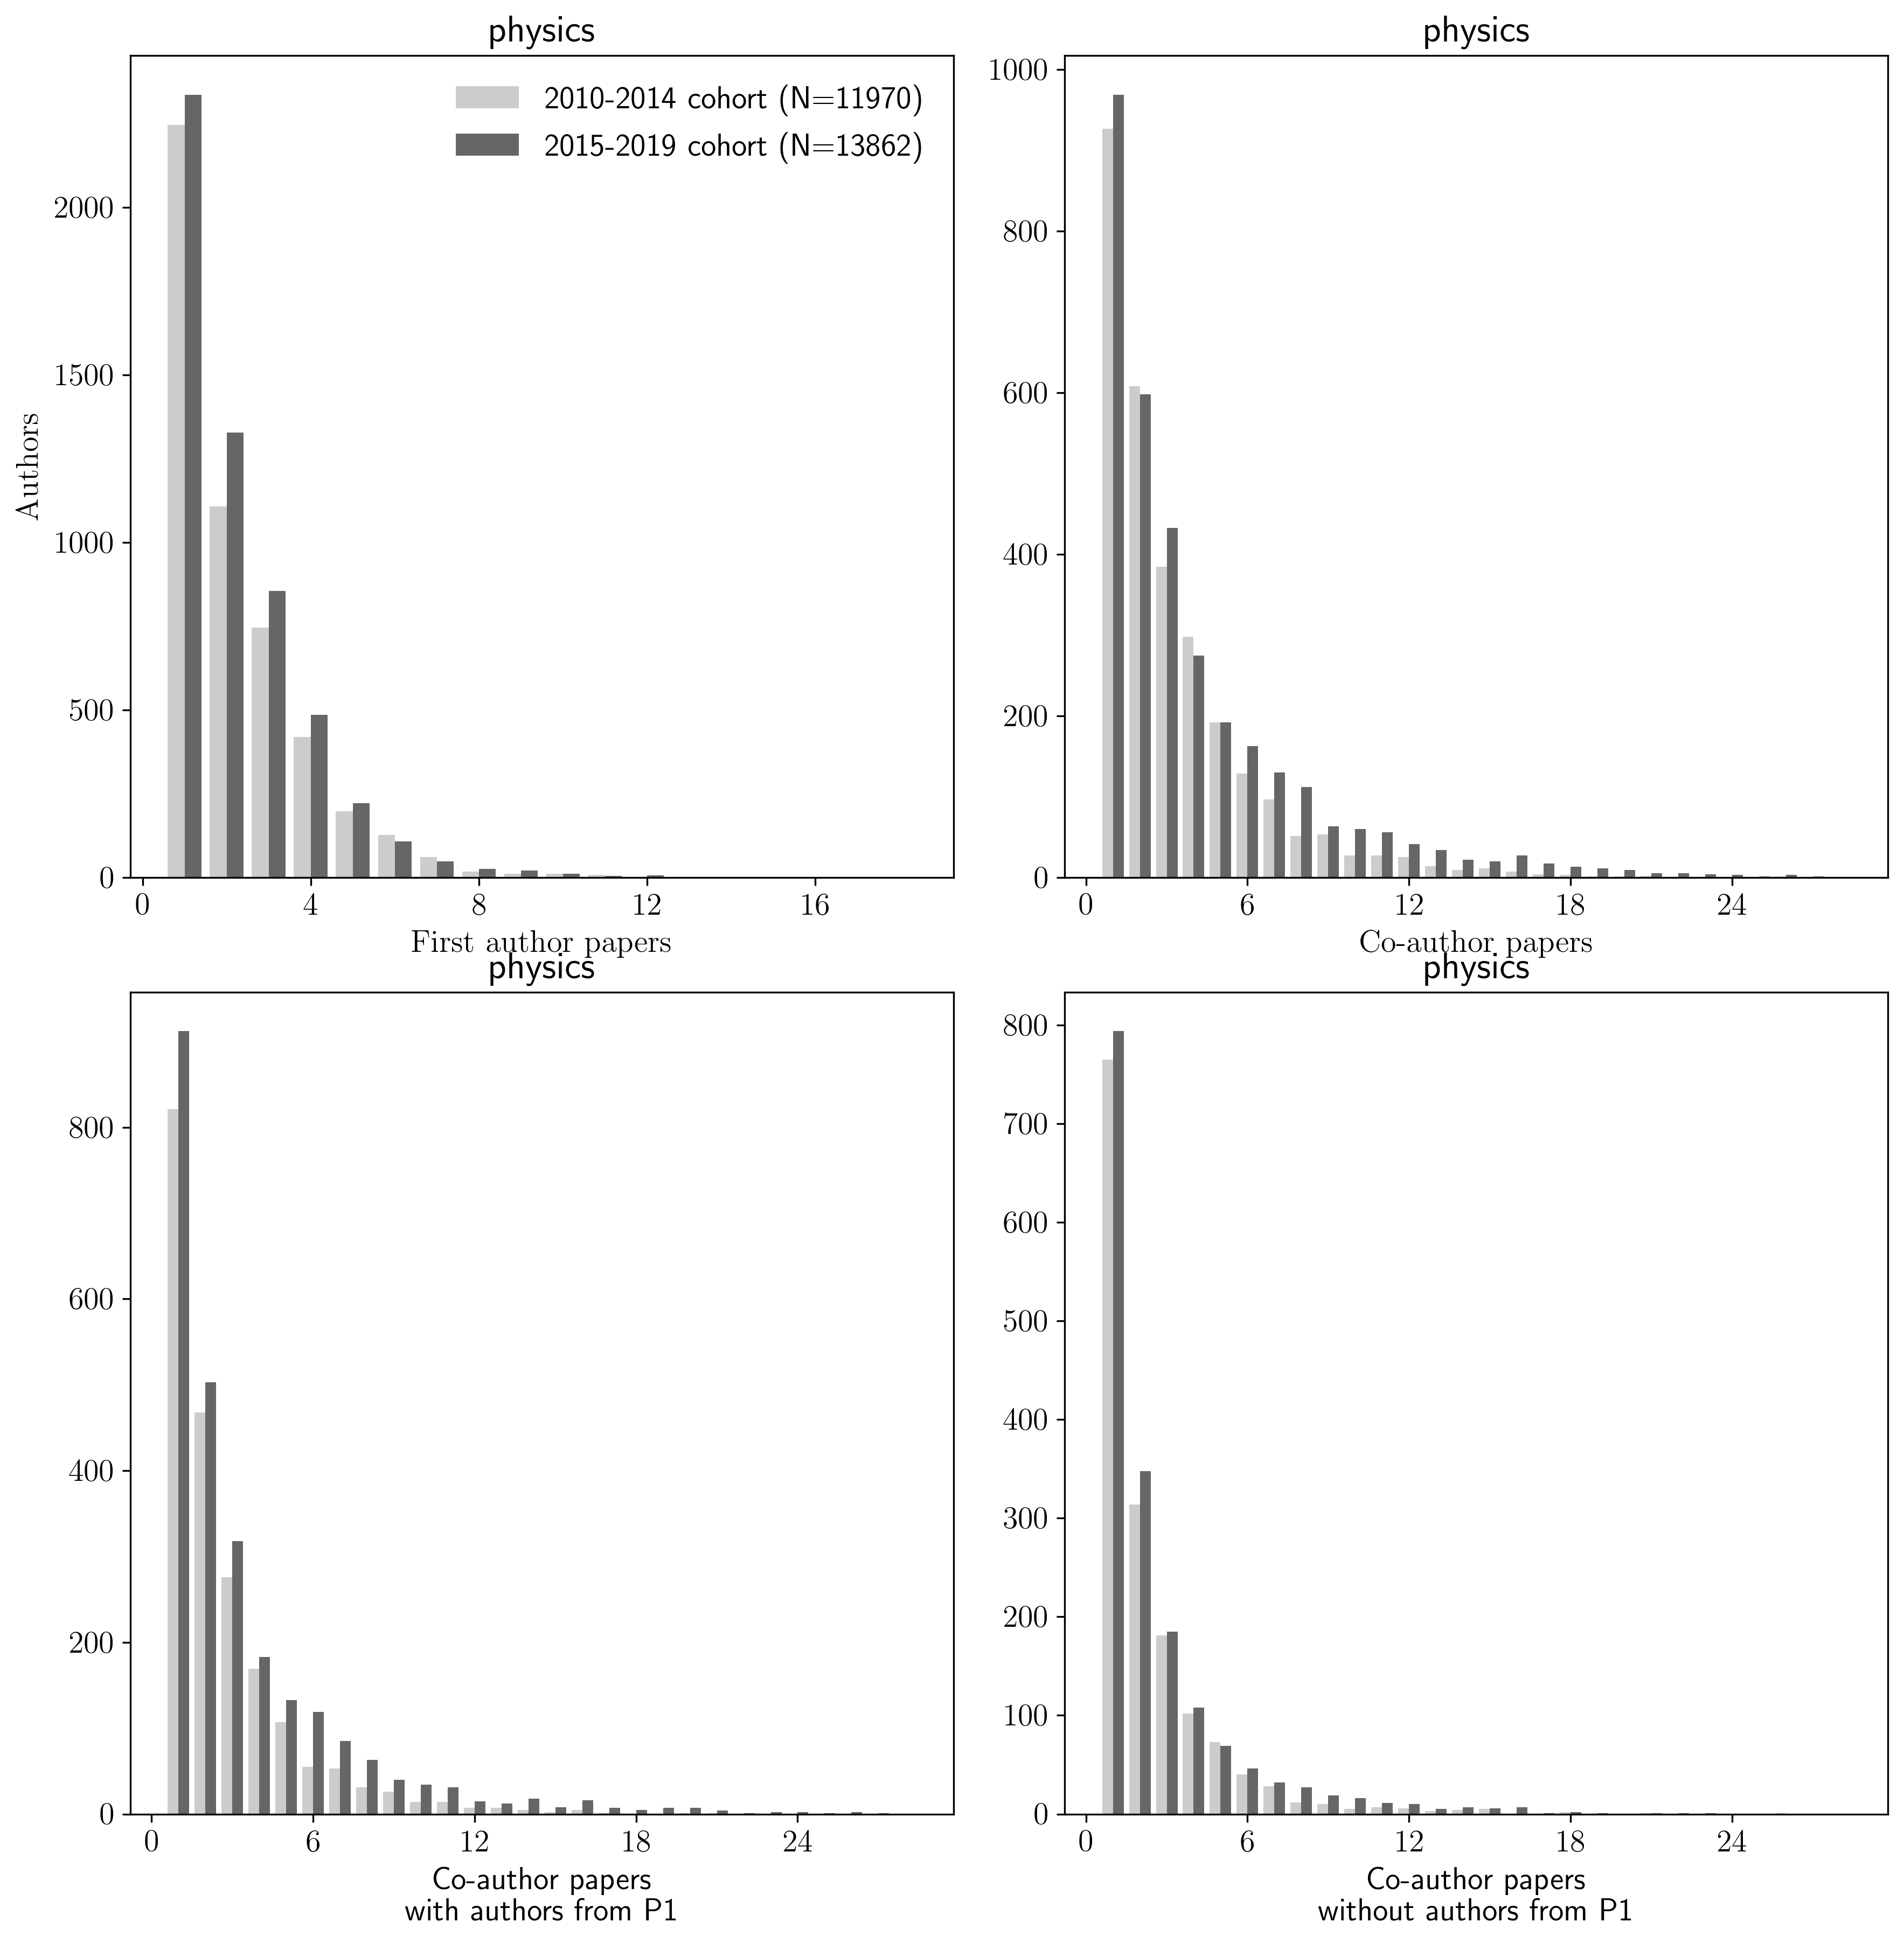

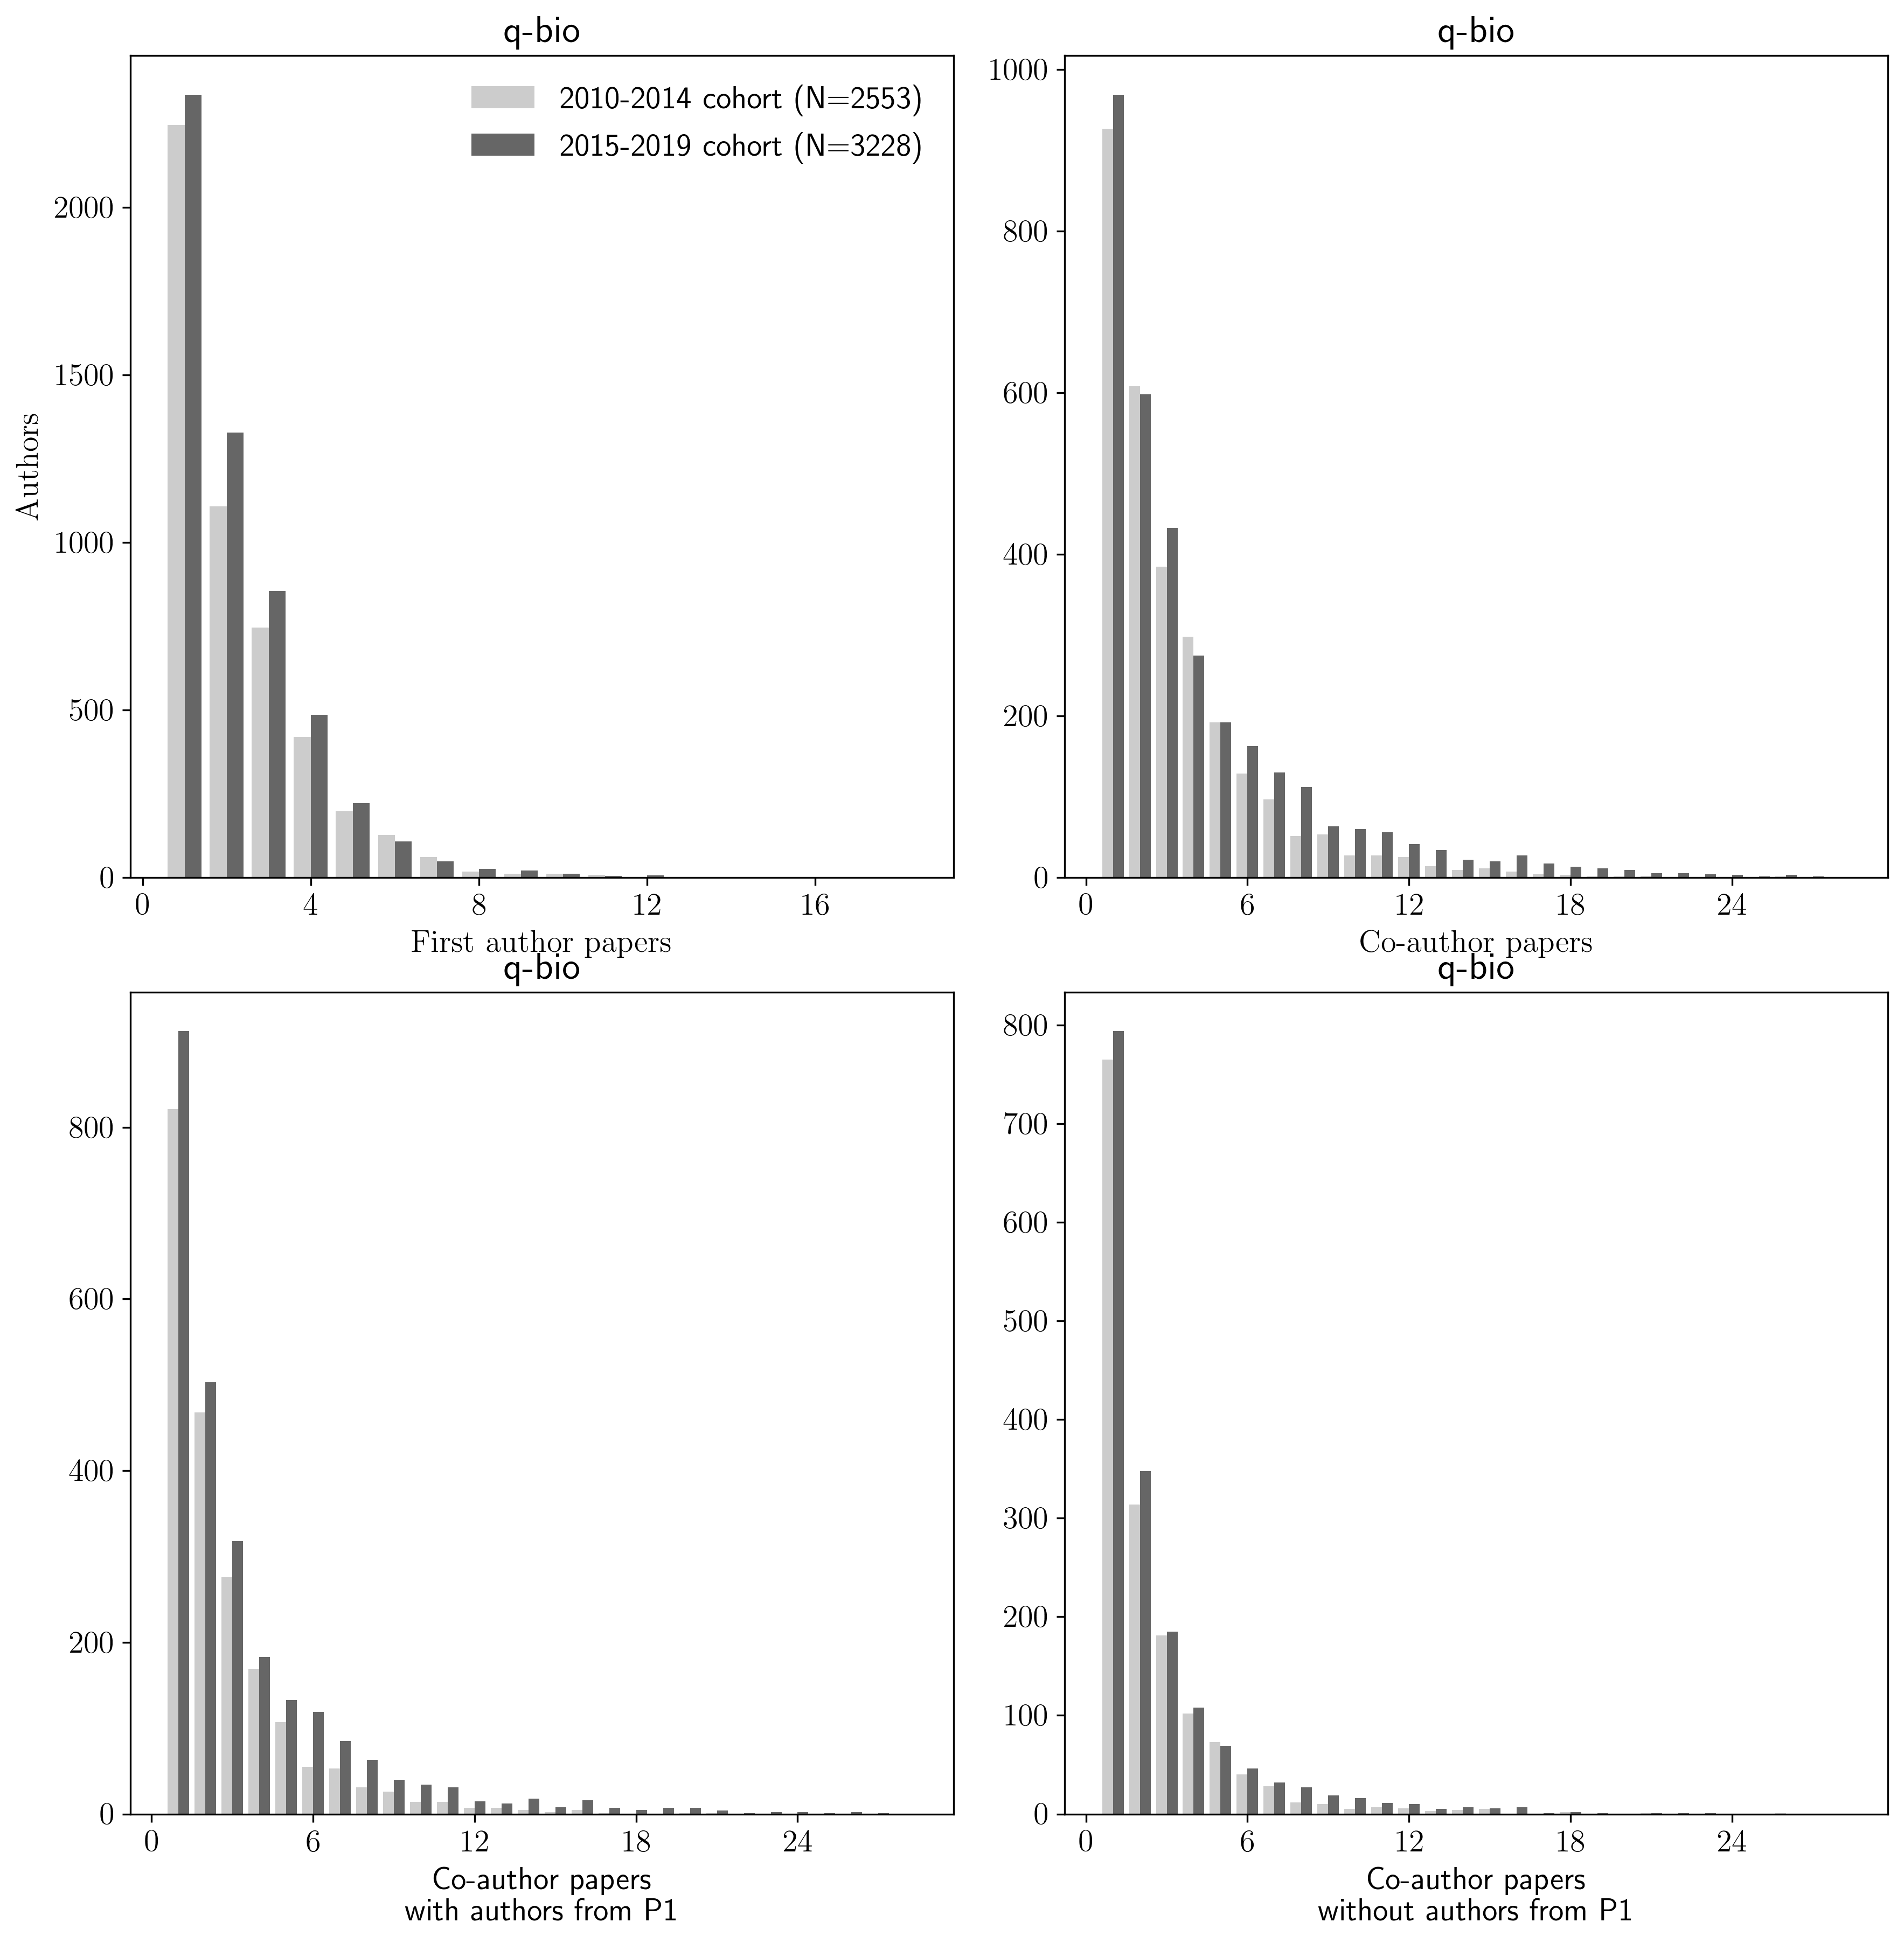

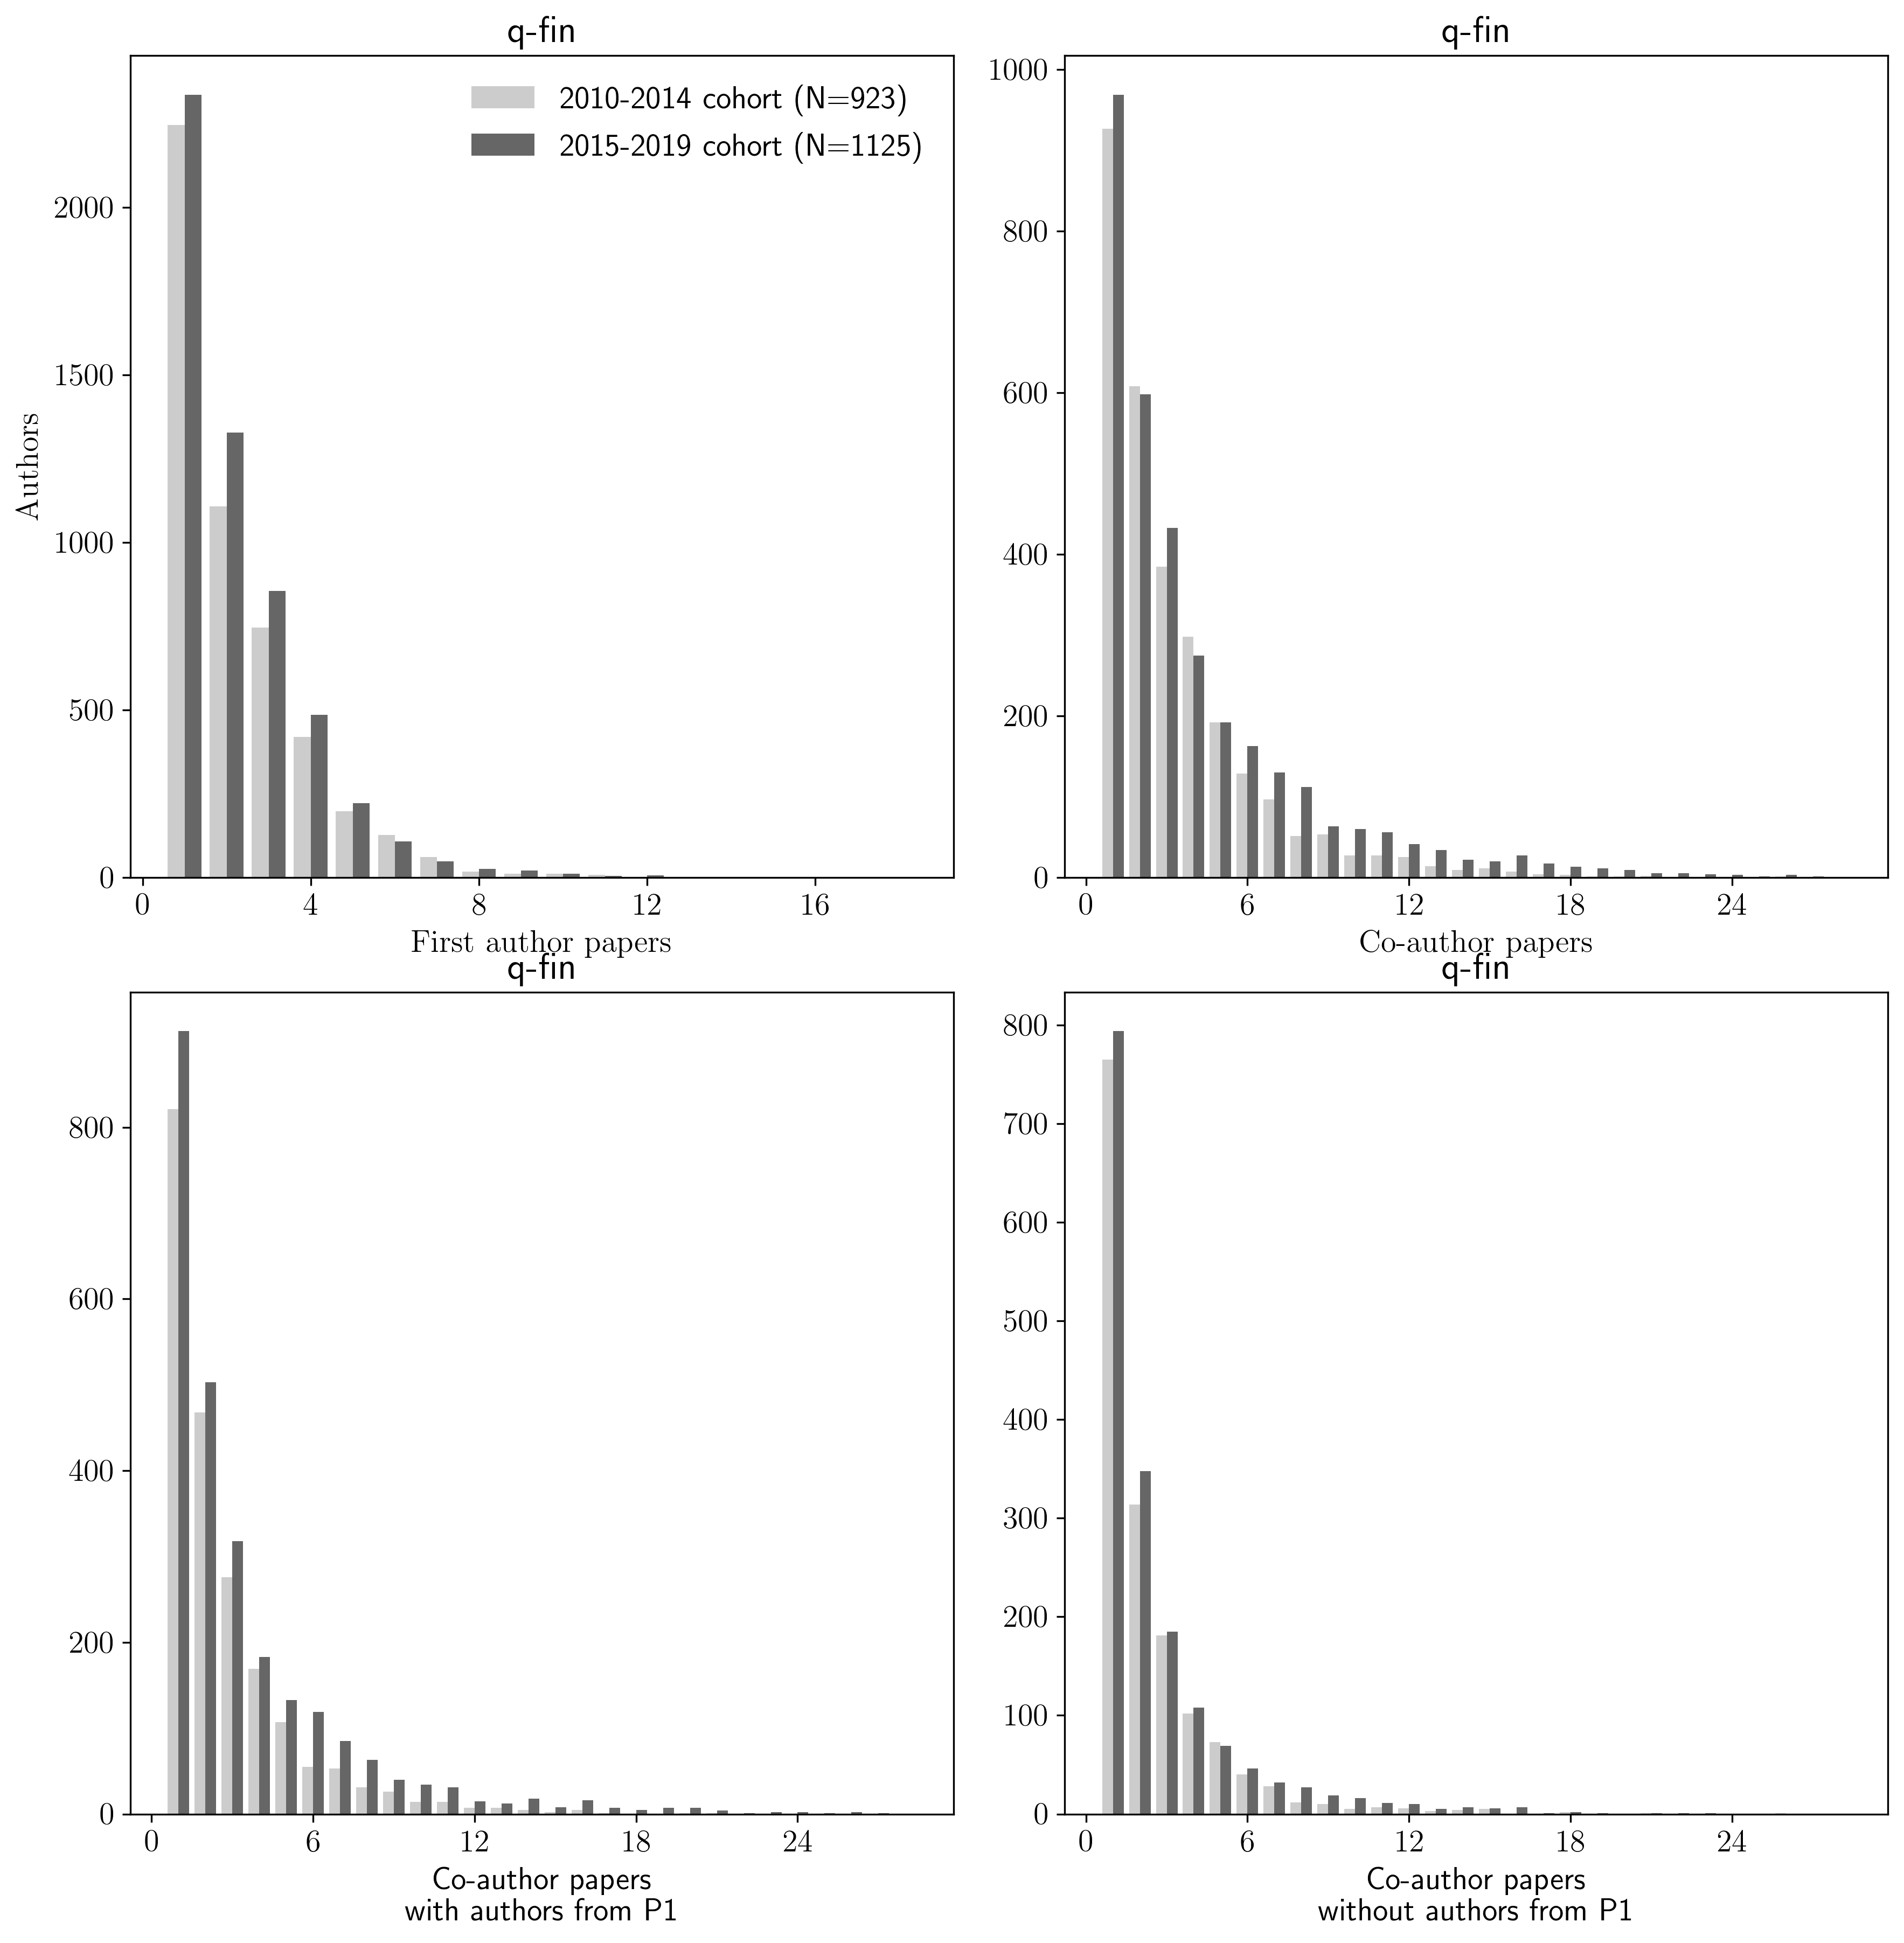

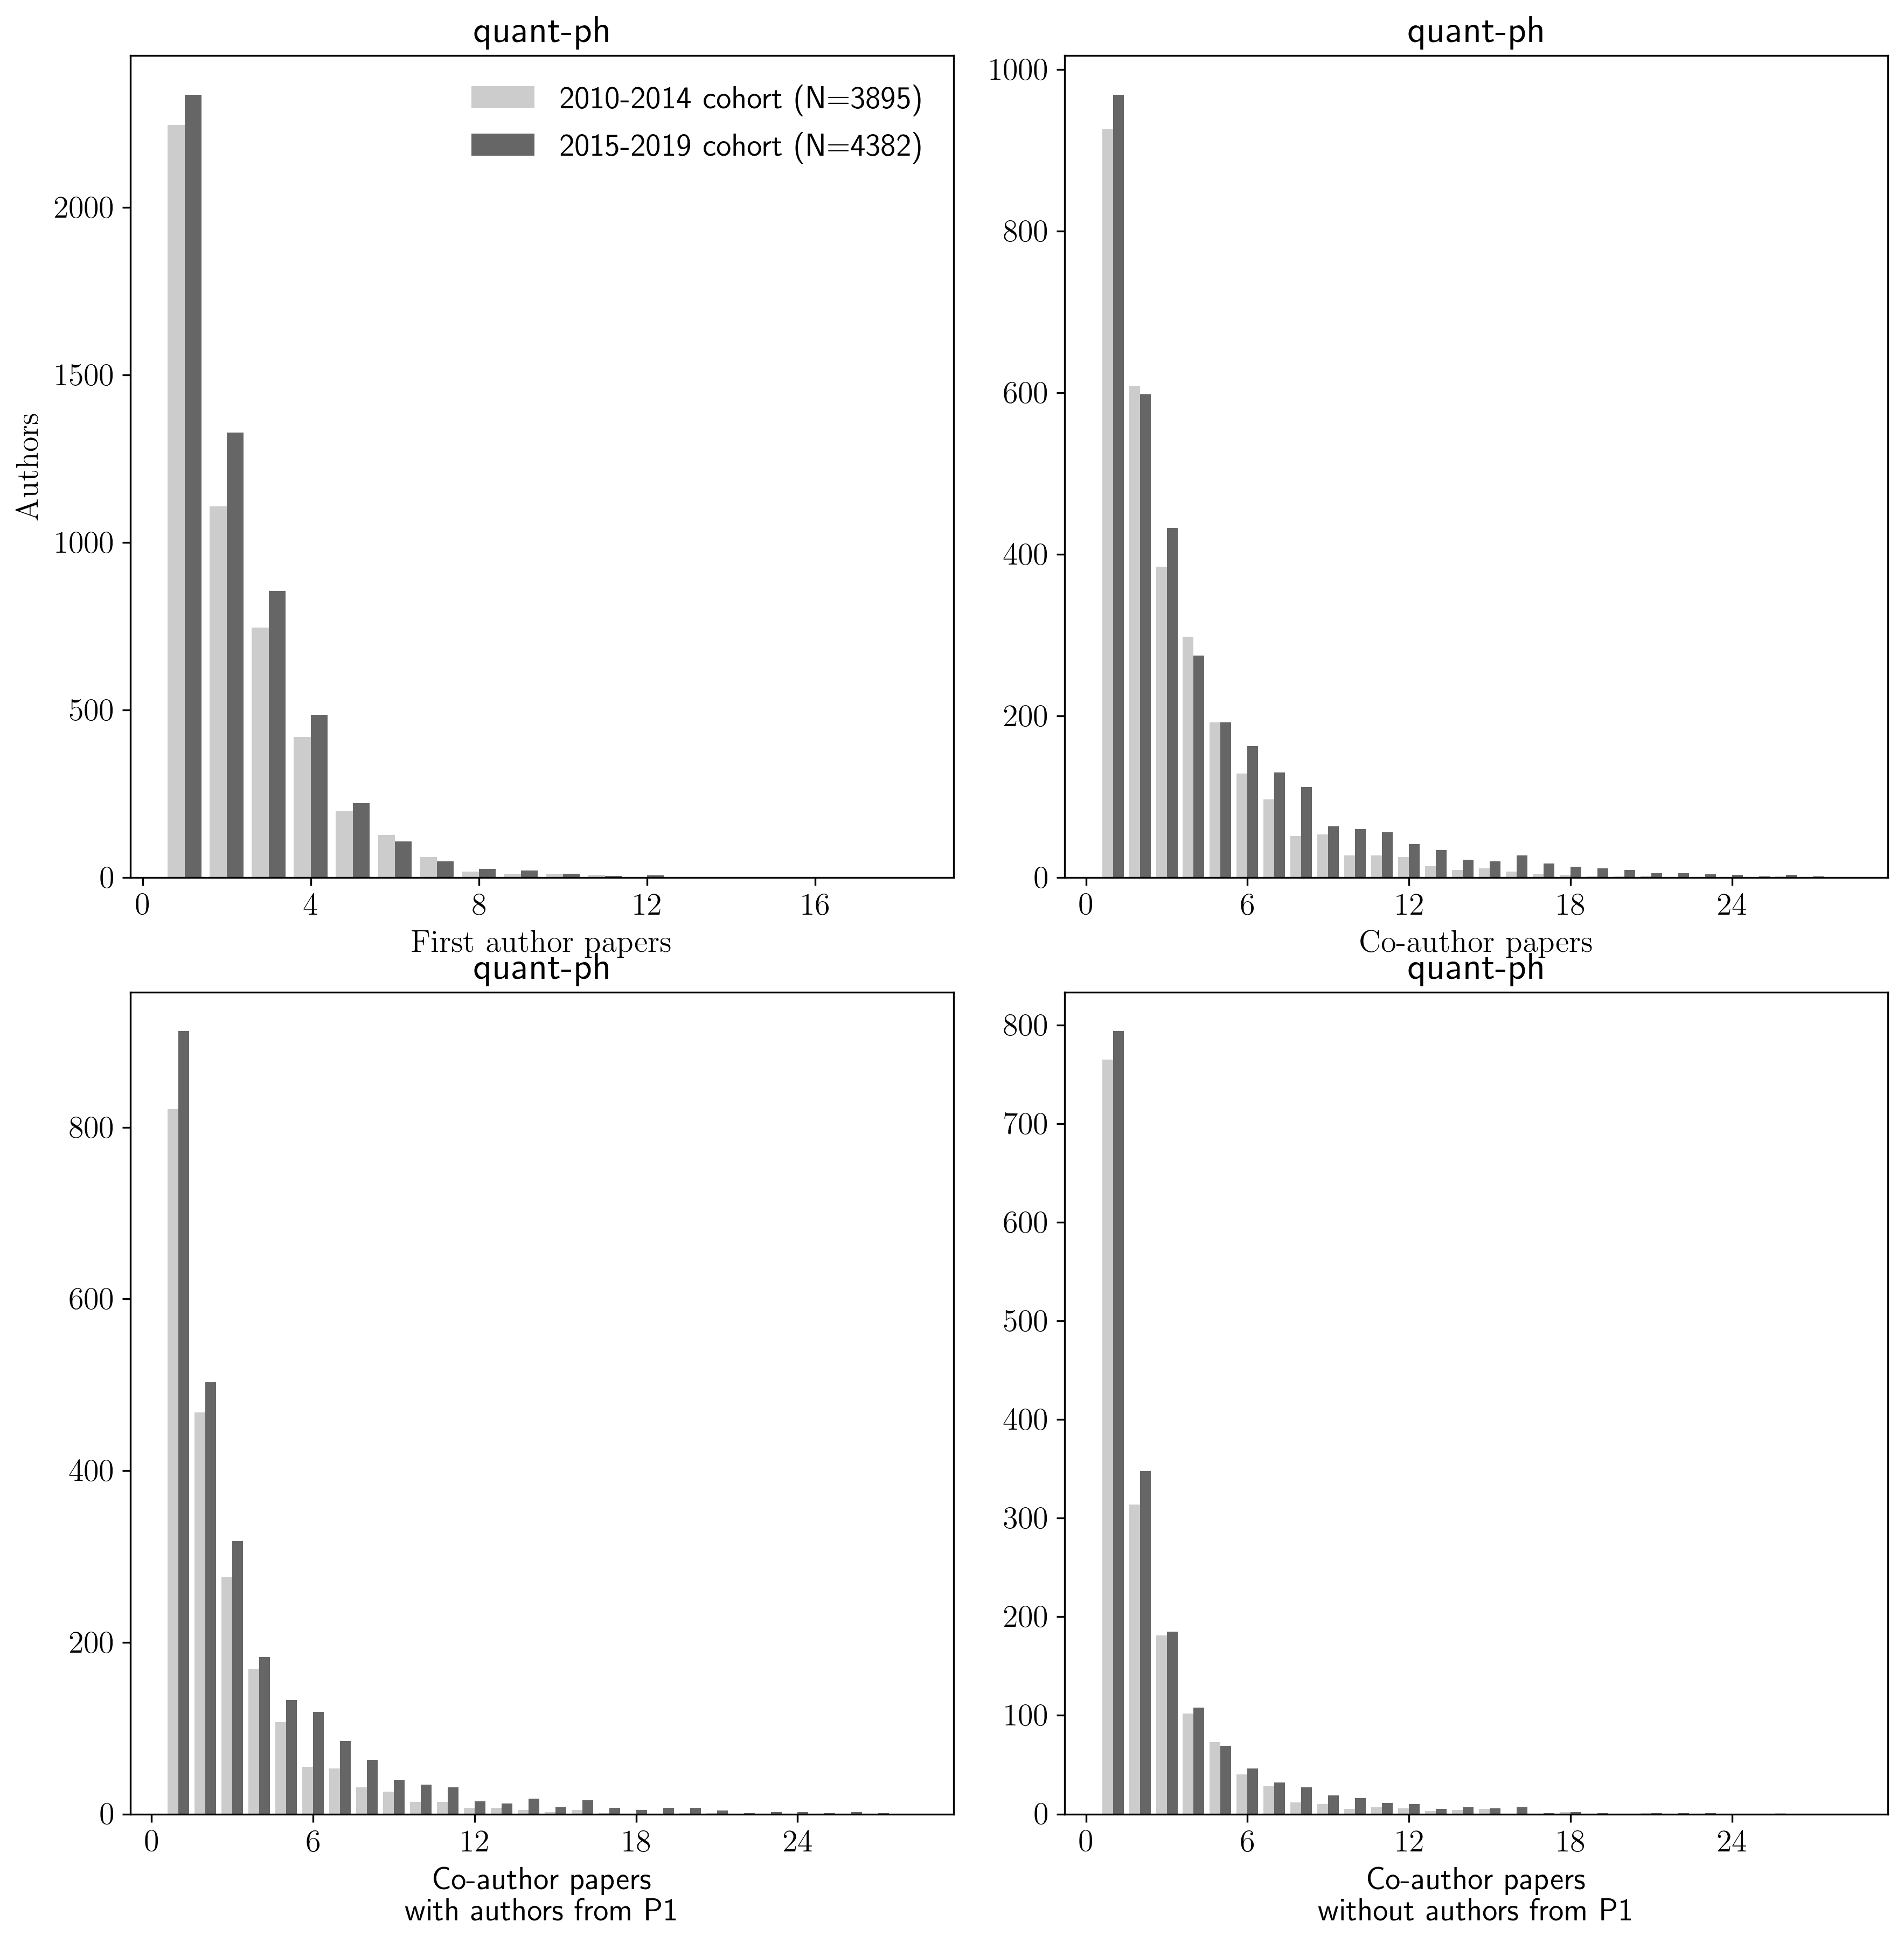

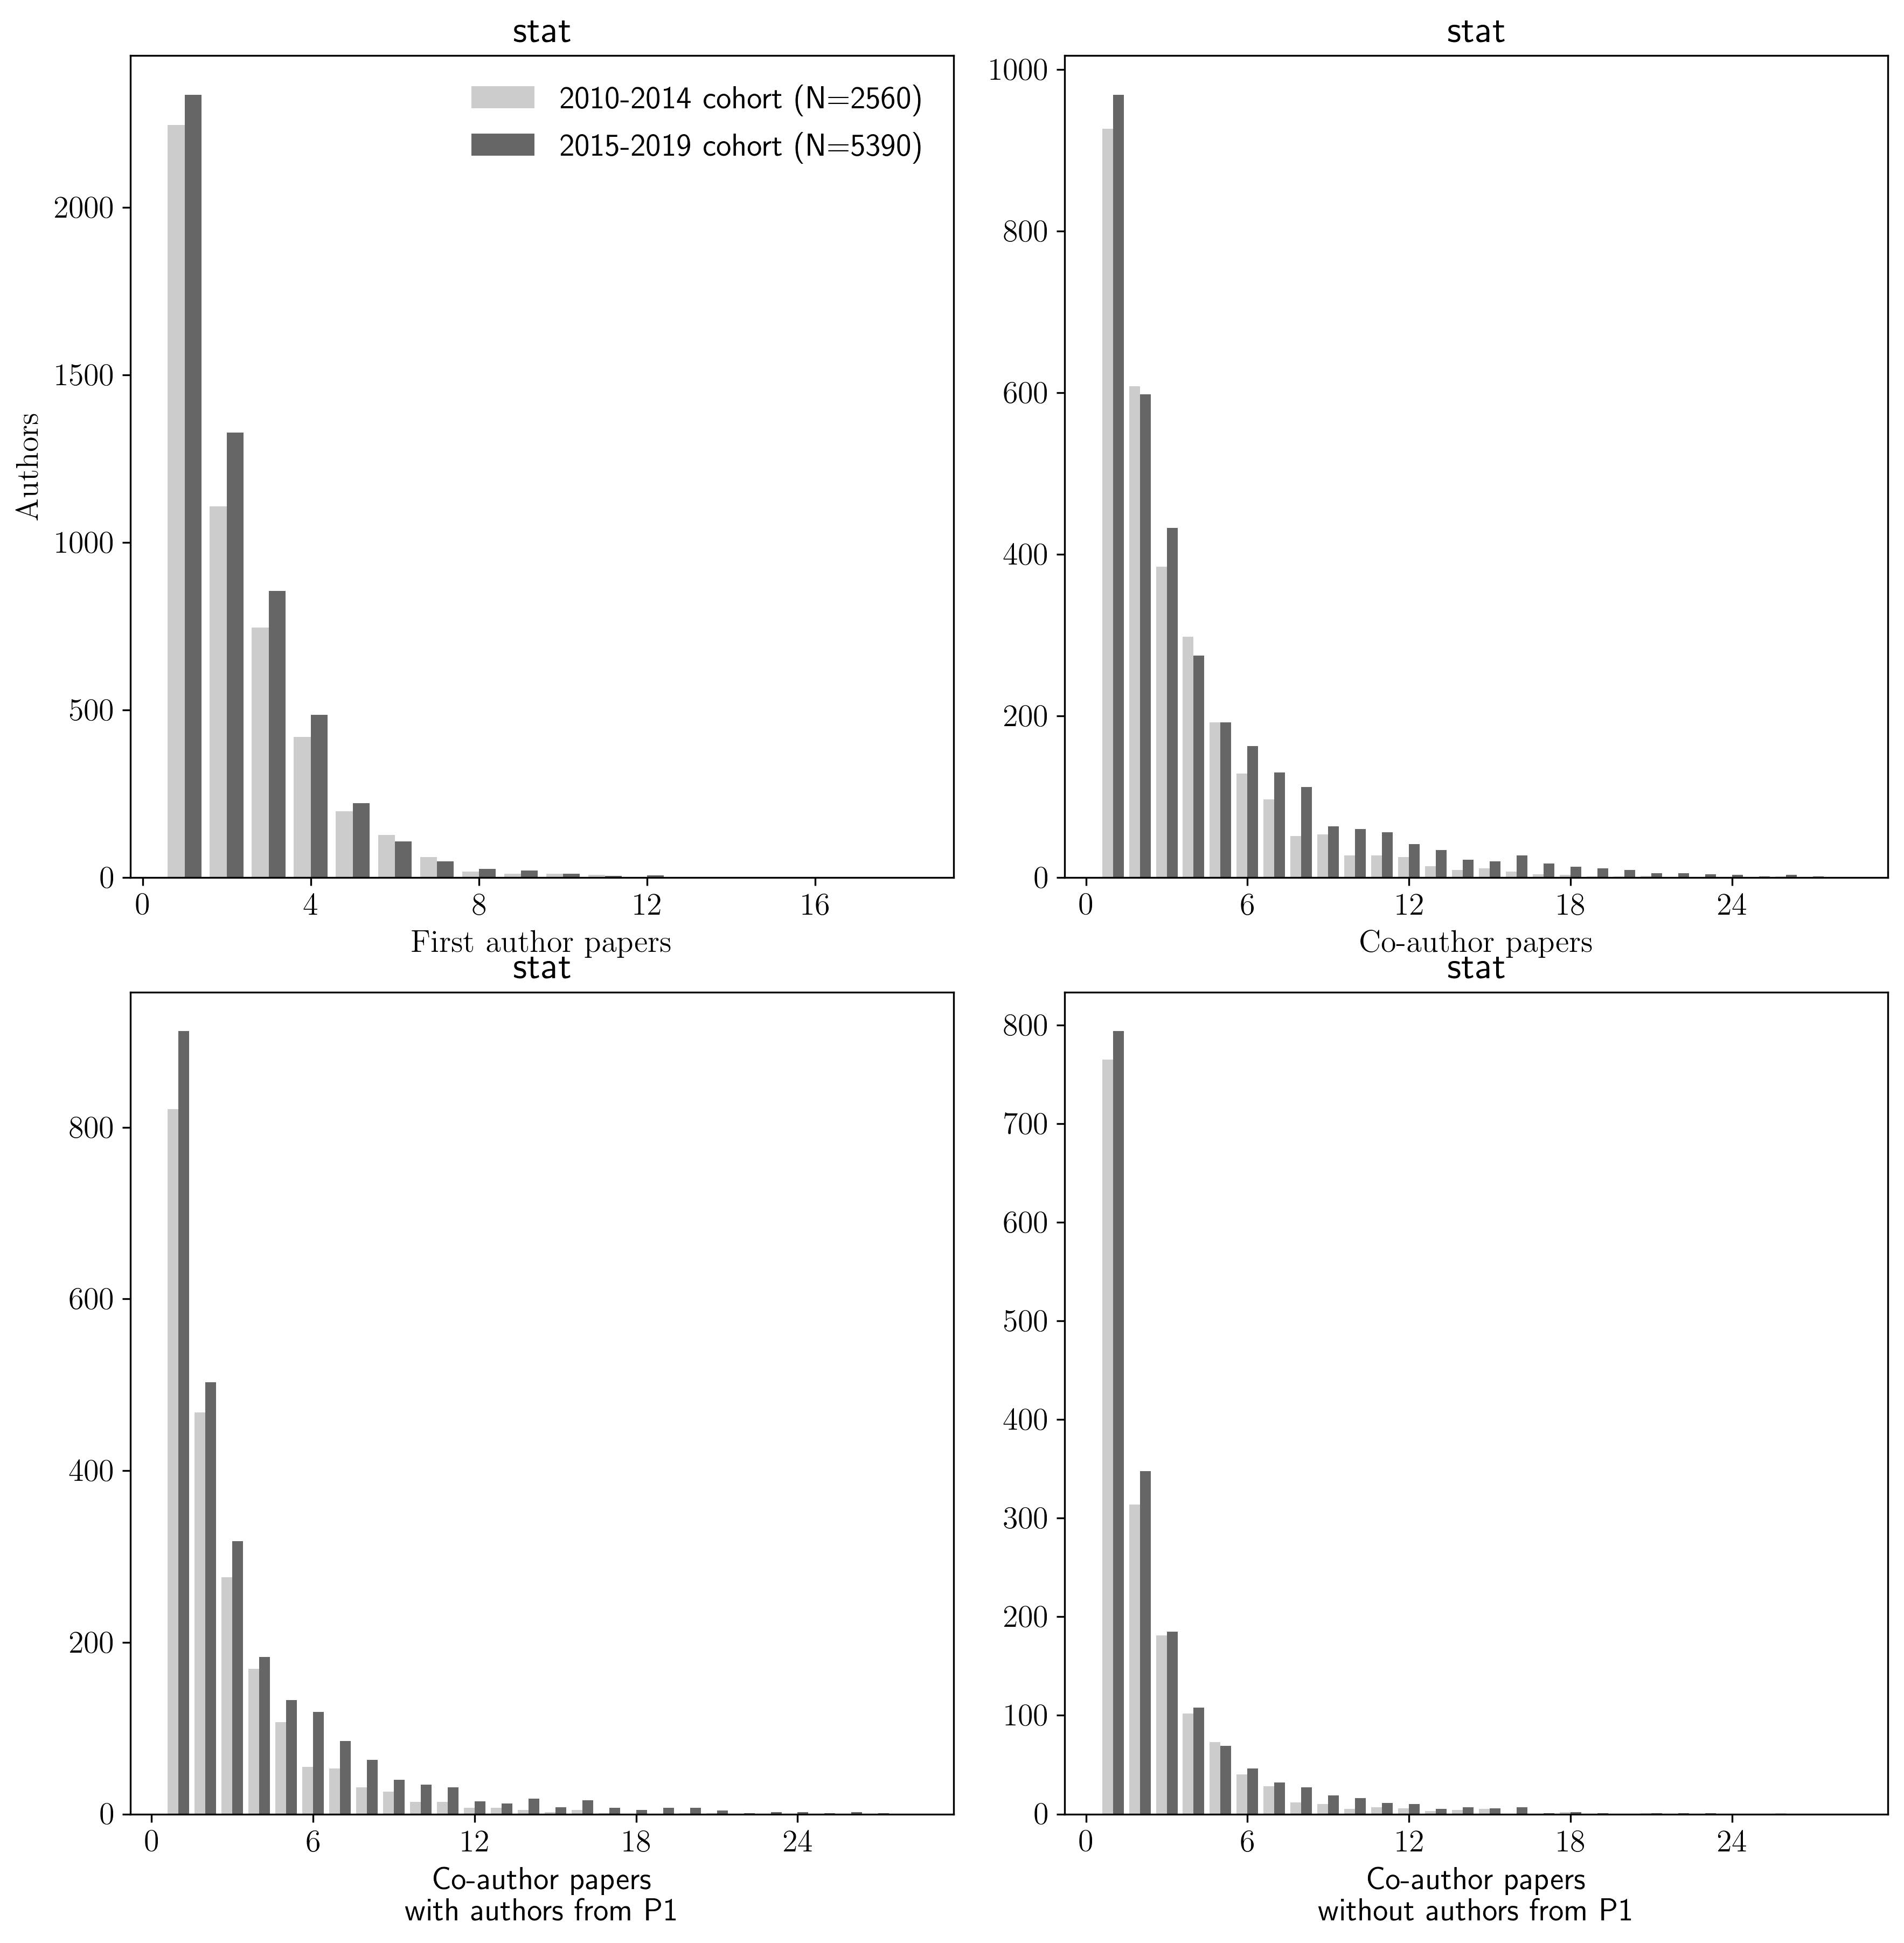

In [85]:
# Make plots for a few interesting ones
show_ppcs = ("hep-th", "astro-ph")
show_ppcs = ppcs
for ppc in show_ppcs:
    ca, cb = cohort_abs[ppc]
    label = [f"{a_start}-{a_end} cohort (N={len(ca)})", f"{b_start}-{b_end} cohort (N={len(cb)})"]
    fig = plot_cohort_comparisons(ca, cb, label=label, log=False, density=False)
    for ax in fig.axes:
        ax.set_title(ppc)


In [97]:
for ppc in ppcs:
    
    ca, cb = cohort_abs[ppc]
        
    A_first = np.array([each["n_first_author"] for each in cohort_a.values()])
    B_first = np.array([each["n_first_author"] for each in cohort_b.values()])    
        
    A_nth = np.array([each["n_nth_author"] for each in cohort_a.values()])
    B_nth = np.array([each["n_nth_author"] for each in cohort_b.values()])
    
    
    A_nth_with_overlap = np.array([each["n_author_overlap_with_p1"] for each in cohort_a.values()])
    B_nth_with_overlap = np.array([each["n_author_overlap_with_p1"] for each in cohort_b.values()])

    A_nth_without_overlap = np.array([each["n_nth_author"] - each["n_author_overlap_with_p1"] for each in cohort_a.values()])
    B_nth_without_overlap = np.array([each["n_nth_author"] - each["n_author_overlap_with_p1"] for each in cohort_b.values()])
    
    K_first = stats.ks_2samp(A_first, B_first)
    K_nth = stats.ks_2samp(A_nth, B_nth)
    K_nth_with = stats.ks_2samp(A_nth_with_overlap, B_nth_with_overlap)
    K_nth_without = stats.ks_2samp(A_nth_without_overlap, B_nth_without_overlap)
    
    print(f"{ppc}")
    print(f"first author papers: {K_first.pvalue}")
    print(f"nth-author papers: {K_nth.pvalue}")
    print(f"nth-author with overlap: {K_nth_with.pvalue}")
    print(f"nth-author without overlap: {K_nth_without.pvalue}")


astro-ph
first author papers: 1.0
nth-author papers: 1.0
nth-author with overlap: 1.0
nth-author without overlap: 1.0
cond-mat
first author papers: 1.0
nth-author papers: 1.0
nth-author with overlap: 1.0
nth-author without overlap: 1.0
cs
first author papers: 1.0
nth-author papers: 1.0
nth-author with overlap: 1.0
nth-author without overlap: 1.0
econ
first author papers: 1.0
nth-author papers: 1.0
nth-author with overlap: 1.0
nth-author without overlap: 1.0
eess
first author papers: 1.0
nth-author papers: 1.0
nth-author with overlap: 1.0
nth-author without overlap: 1.0
gr-qc
first author papers: 1.0
nth-author papers: 1.0
nth-author with overlap: 1.0
nth-author without overlap: 1.0
hep-ex
first author papers: 1.0
nth-author papers: 1.0
nth-author with overlap: 1.0
nth-author without overlap: 1.0
hep-lat
first author papers: 1.0
nth-author papers: 1.0
nth-author with overlap: 1.0
nth-author without overlap: 1.0
hep-ph
first author papers: 1.0
nth-author papers: 1.0
nth-author with overl